In [159]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from fpdf import FPDF
import shutil

In [160]:
def load_images_from_folder(folder, size=(64,64)):
    images = []
    X = []
    filenames = sorted(os.listdir(folder))
    for fname in filenames:
        img_path = os.path.join(folder, fname)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, size)
        img = img.astype(np.float64) / 255.0  # Normalize to [0, 1]
        images.append(img)
        X.append(img.flatten())
    return images, np.array(X), filenames

In [161]:

def plot_eigenspectrum(eigenvalues, title):
    plt.figure()
    plt.plot(np.sort(eigenvalues)[::-1], marker='o')
    plt.title(title)
    plt.xlabel('Component index')
    plt.ylabel('Eigenvalue')
    plt.tight_layout()
    plt.show()
    plt.close()

In [162]:
def binarize_image(img, thresh=0.5):
    return np.where(img >= thresh, 1, 0)



In [163]:
def perform_pca(X):
    mean_img = np.mean(X, axis=0)
    X_centered = X - mean_img
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    eigenvectors = Vt.T    # Each column is an eigenvector
    eigenvalues = (S**2) / X.shape[0]
    return mean_img, eigenvalues, eigenvectors

def reconstruct_pca(x, mean_img, eigenvectors, num_components=3):
    x_centered = x - mean_img
    coeffs = np.dot(x_centered, eigenvectors[:, :num_components])
    reconstruction = mean_img + np.dot(coeffs, eigenvectors[:, :num_components].T)
    reconstruction = np.clip(reconstruction, 0, 1)
    return binarize_image(reconstruction)

In [164]:
def gaussian_kernel(X, sigma):
    n_samples = X.shape[0]
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            diff = X[i] - X[j]
            K[i, j] = np.exp(-np.dot(diff, diff) / (2 * sigma**2))
    return K

def center_kernel(K):
    n = K.shape[0]
    one_n = np.ones((n, n)) / n
    return K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

def perform_kernel_pca(X, sigma, num_components=3):
    K = gaussian_kernel(X, sigma)
    K_centered = center_kernel(K)
    eigenvalues, eigenvectors = np.linalg.eigh(K_centered)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    # Normalize eigenvectors in feature space.
    for i in range(eigenvectors.shape[1]):
        eigenvectors[:, i] /= np.sqrt(eigenvalues[i] + 1e-8)
    return eigenvalues, eigenvectors, K_centered

def preimage_kernel(x_init, X_train, sigma, tol=1e-5, max_iter=100):
    x_prev = x_init.copy()
    for _ in range(max_iter):
        weights = np.array([np.exp(-np.linalg.norm(x_prev - xi)**2 / (2 * sigma**2)) for xi in X_train])
        if np.sum(weights) == 0:
            break
        x_new = np.sum(weights[:, None] * X_train, axis=0) / np.sum(weights)
        if np.linalg.norm(x_new - x_prev) < tol:
            break
        x_prev = x_new
    x_prev = np.clip(x_prev, 0, 1)
    return binarize_image(x_prev)

def reconstruct_kernel_pca(x, X_train, sigma, eigenvectors, eigenvalues, K_centered_train, num_components=3):
    preimg = preimage_kernel(x, X_train, sigma)
    preimg = np.clip(preimg, 0, 1)
    return binarize_image(preimg)


In [165]:
# Settings:
sigma = 0.5         # Gaussian kernel bandwidth (adjustable)
num_components = 3
img_size = (64, 64)

Q4(a): PCA on Segmentation Images
Loaded 150 segmentation images.


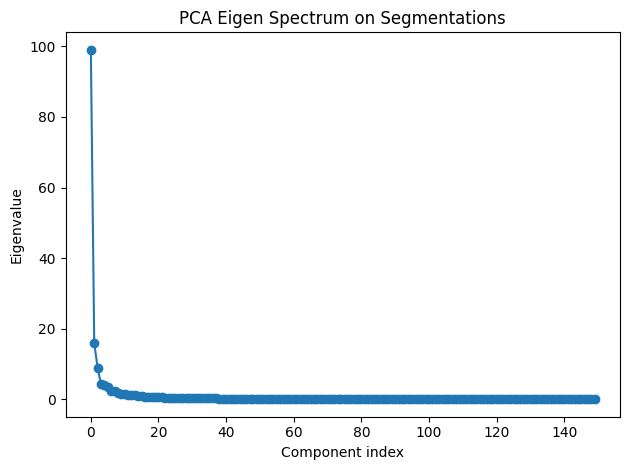

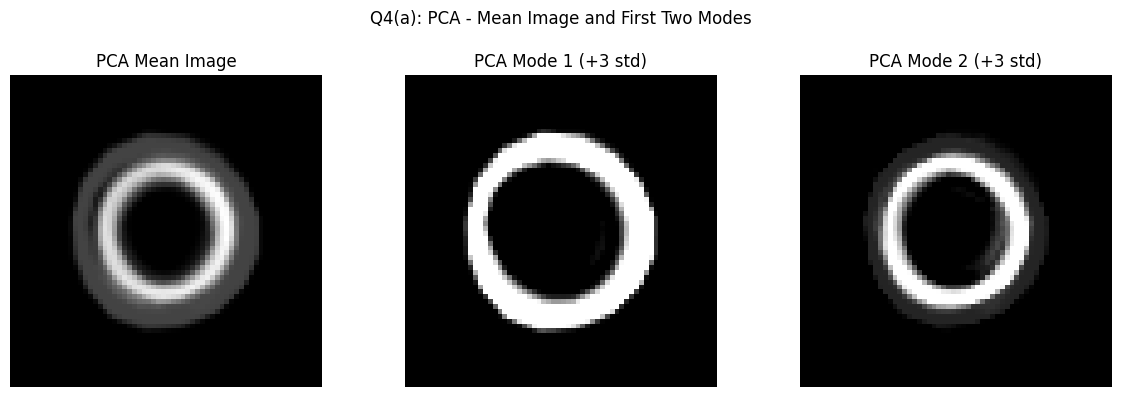

In [166]:
print("Q4(a): PCA on Segmentation Images")

seg_folder = 'data\\anatomicalSegmentations'
seg_images, X_seg, seg_filenames = load_images_from_folder(seg_folder, size=img_size)
print("Loaded {} segmentation images.".format(len(seg_images)))

# Compute PCA on segmentation images.
mean_seg, eigvals_pca, eigvecs_pca = perform_pca(X_seg)

# Display PCA eigen spectrum.
plot_eigenspectrum(eigvals_pca, 'PCA Eigen Spectrum on Segmentations')

# Display PCA mean image and first two modes (mean ± 3 std deviation).
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
mean_img = np.clip(mean_seg.reshape(img_size), 0, 1)
axs[0].imshow(mean_img, cmap='gray')
axs[0].set_title('PCA Mean Image')
axs[0].axis('off')
for i in range(2):
    mode = eigvecs_pca[:, i].reshape(img_size)
    std_dev = np.sqrt(eigvals_pca[i])
    img_mode = mean_img + 3 * std_dev * mode
    axs[i + 1].imshow(np.clip(img_mode, 0, 1), cmap='gray')
    axs[i + 1].set_title(f'PCA Mode {i+1} (+3 std)')
    axs[i + 1].axis('off')
plt.suptitle('Q4(a): PCA - Mean Image and First Two Modes')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Q4(b): Kernel PCA on Segmentation Images


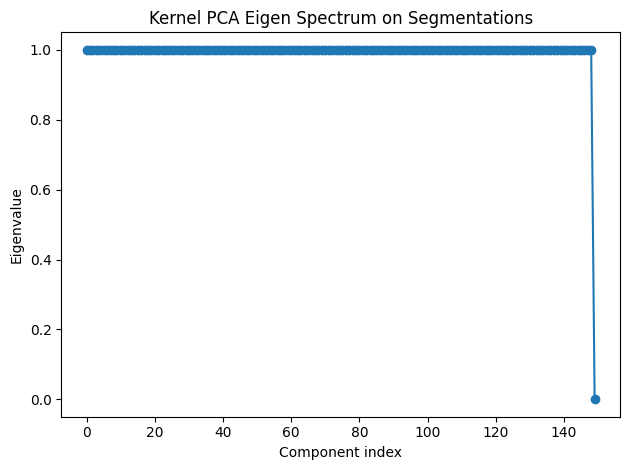

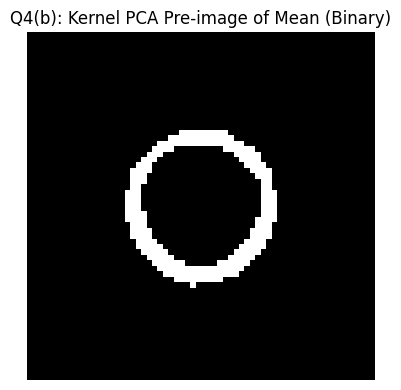

In [167]:
print("Q4(b): Kernel PCA on Segmentation Images")

# Compute kernel PCA on segmentation images.
eigvals_kpca, eigvecs_kpca, K_centered_train = perform_kernel_pca(X_seg, sigma, num_components)

# Display Kernel PCA eigen spectrum.
plot_eigenspectrum(eigvals_kpca, 'Kernel PCA Eigen Spectrum on Segmentations')

# Compute and display the pre-image of the mean in RKHS (binary).
preimg_mean = preimage_kernel(np.mean(X_seg, axis=0), X_seg, sigma)
plt.figure(figsize=(4, 4))
plt.imshow(preimg_mean.reshape(img_size), cmap='gray')
plt.title('Q4(b): Kernel PCA Pre-image of Mean (Binary)')
plt.axis('off')
plt.tight_layout()
plt.show()

Q4(c): Correcting Distorted Segmentation Images
Loaded 150 distorted segmentation images.


C:\Users\Admin\AppData\Local\Temp\ipykernel_21068\3255349472.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 3, figsize=(12, 4))


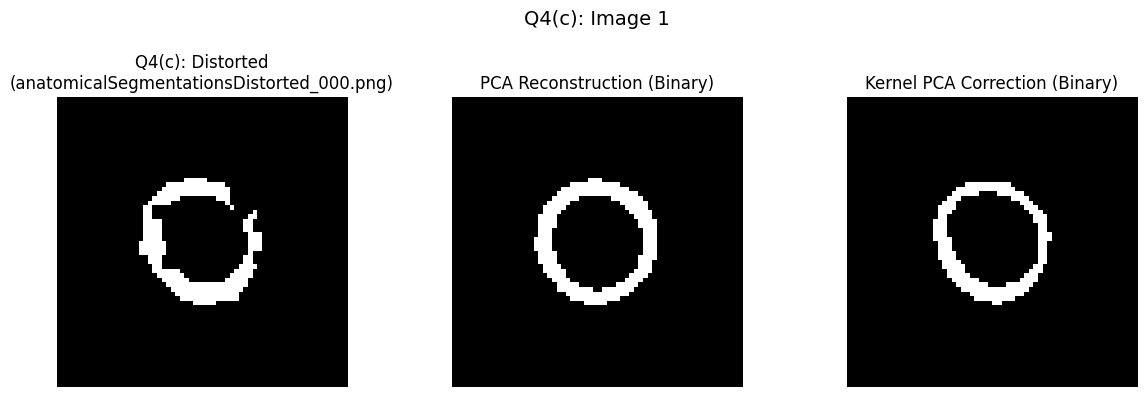

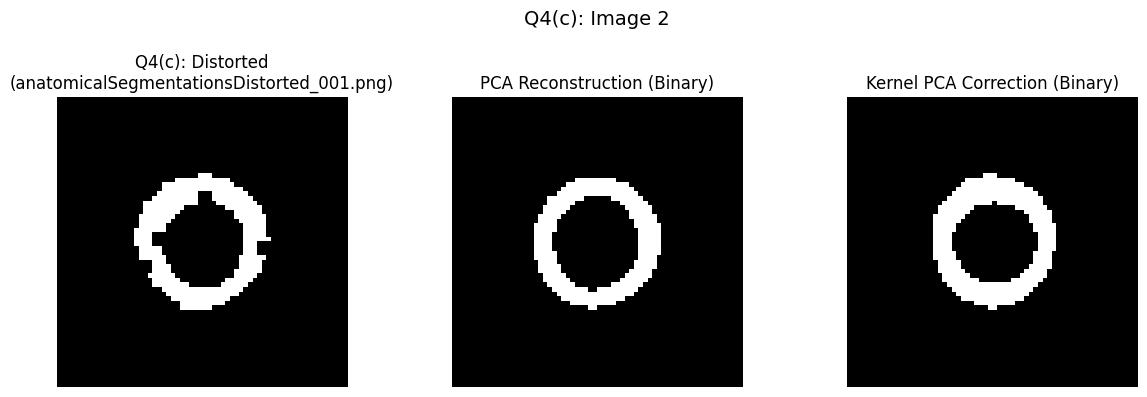

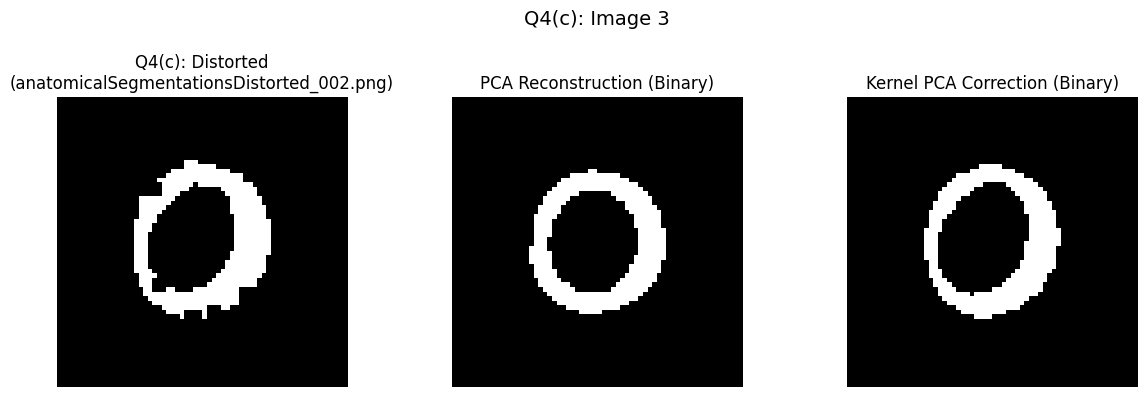

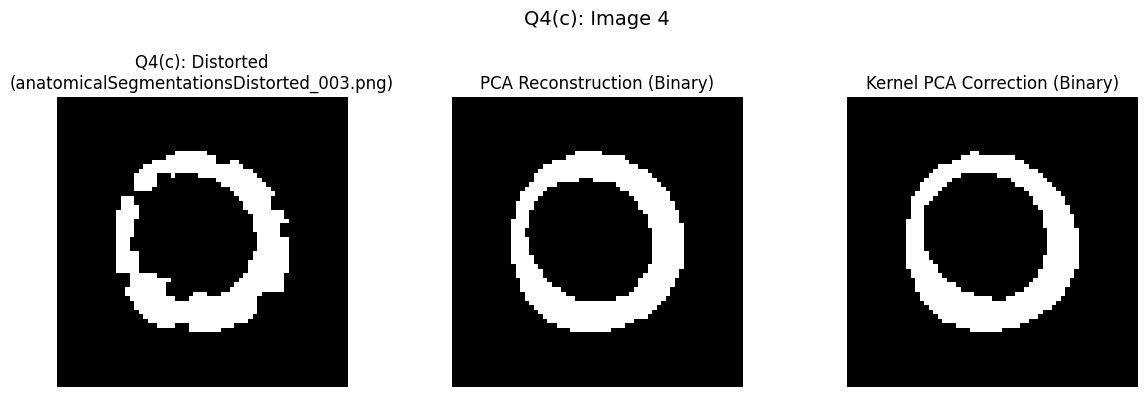

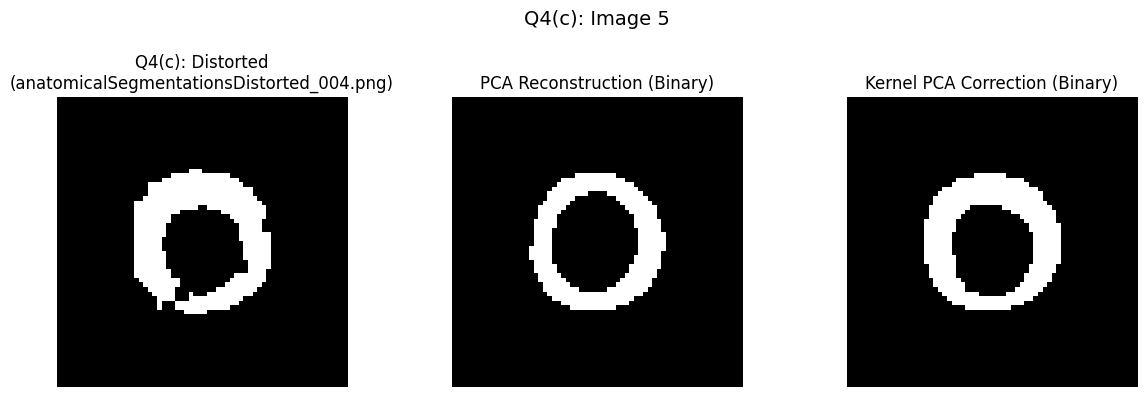

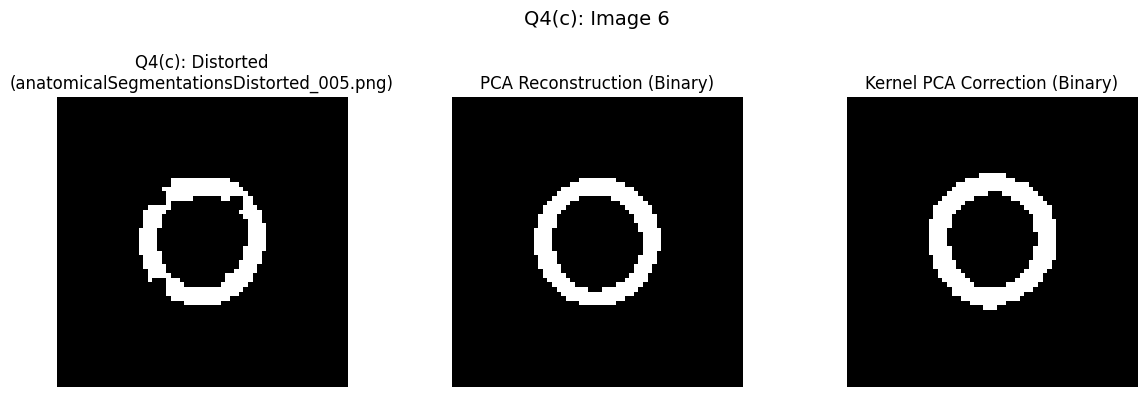

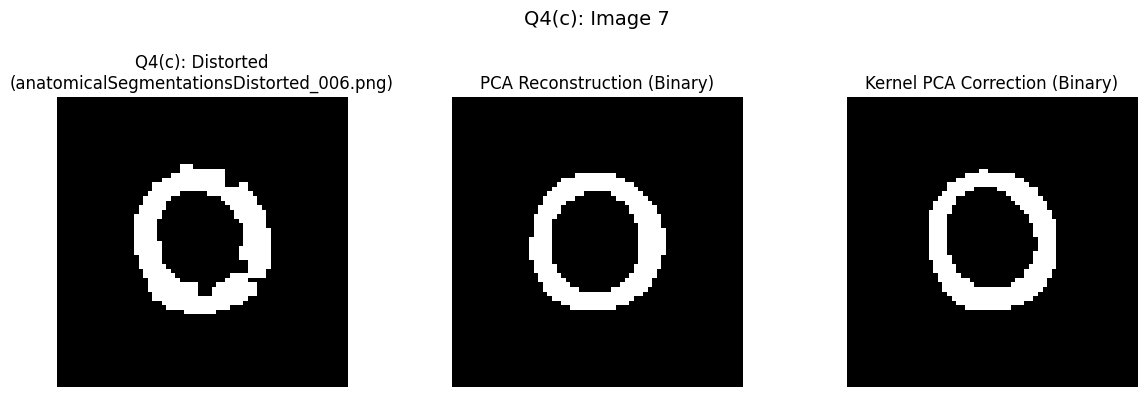

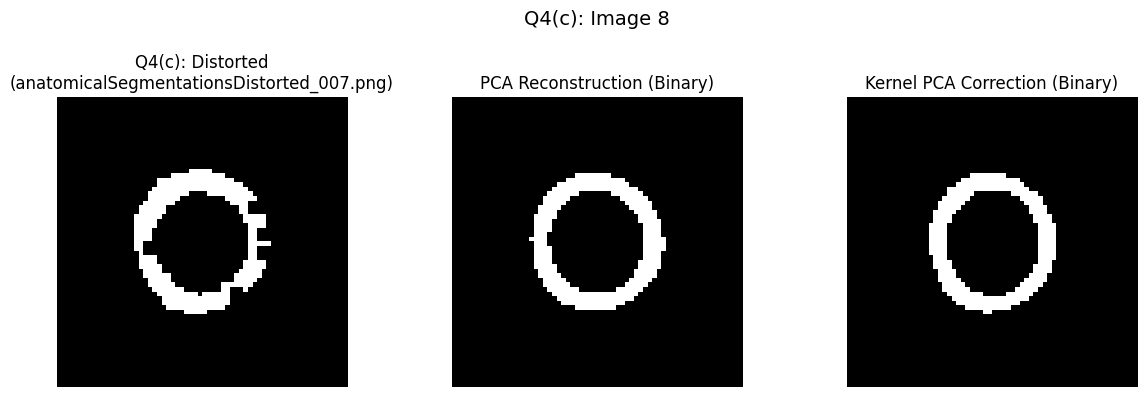

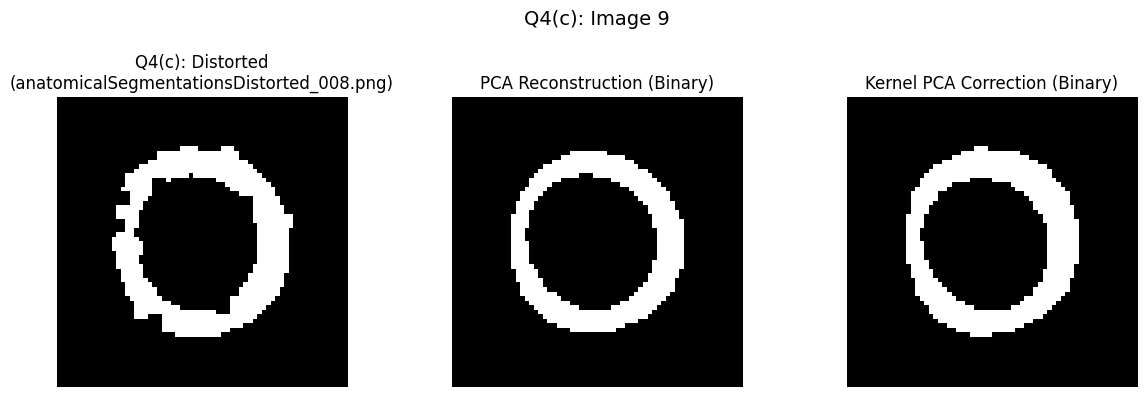

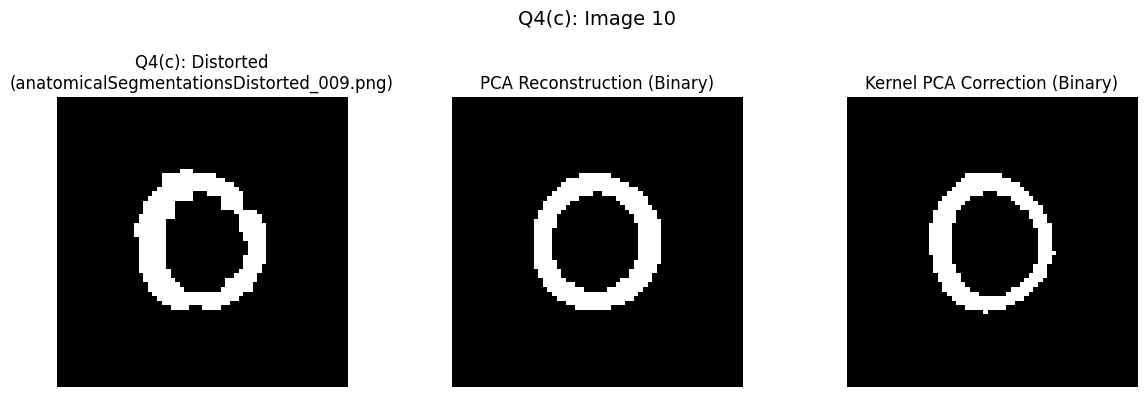

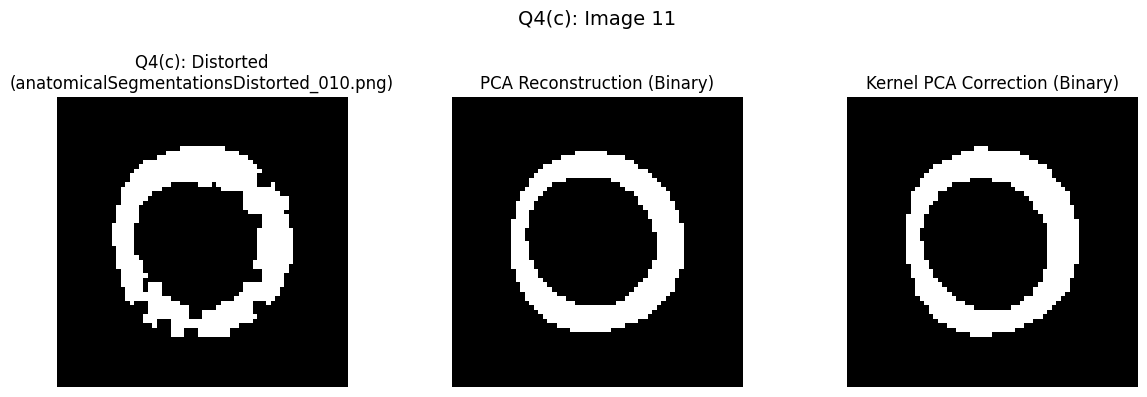

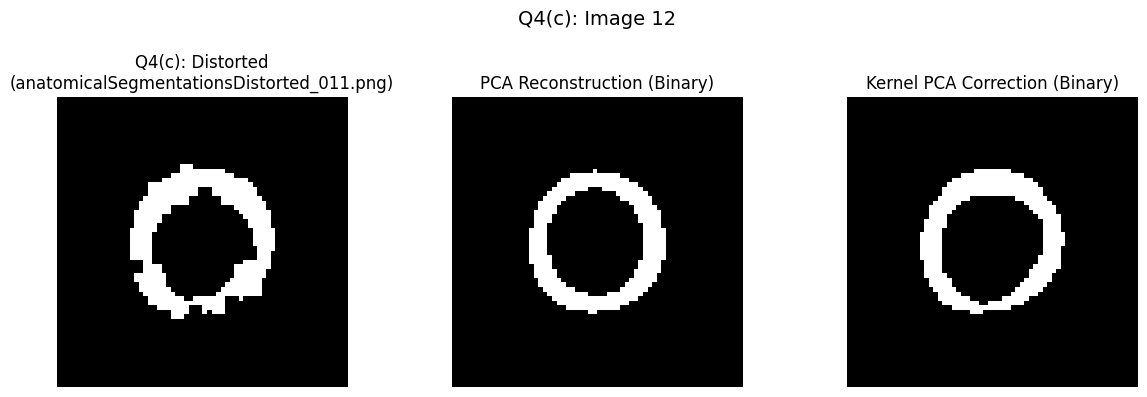

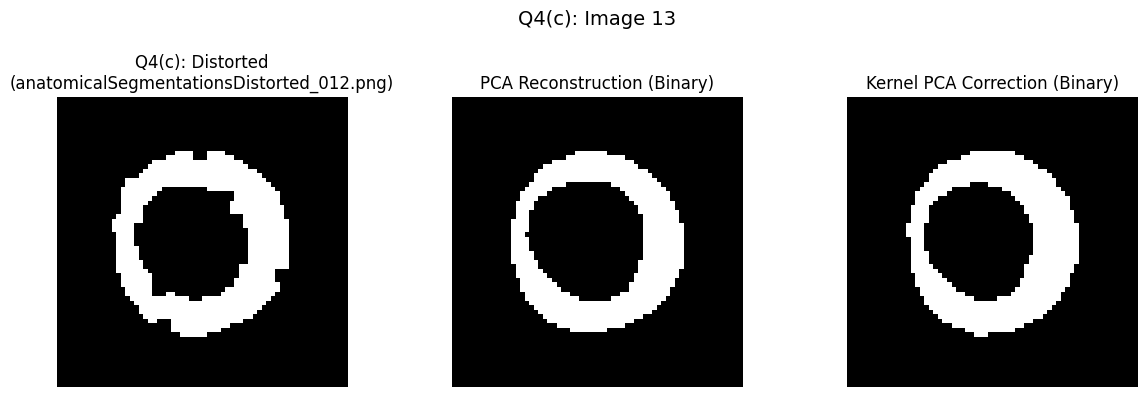

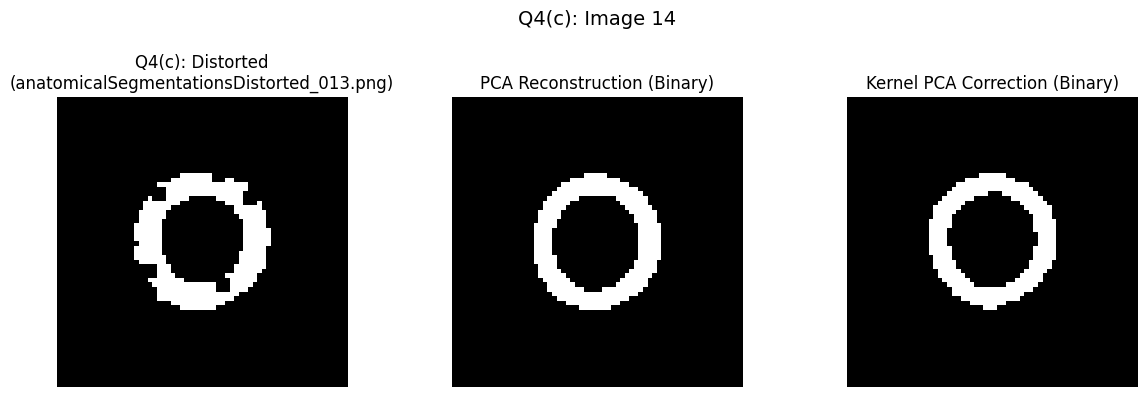

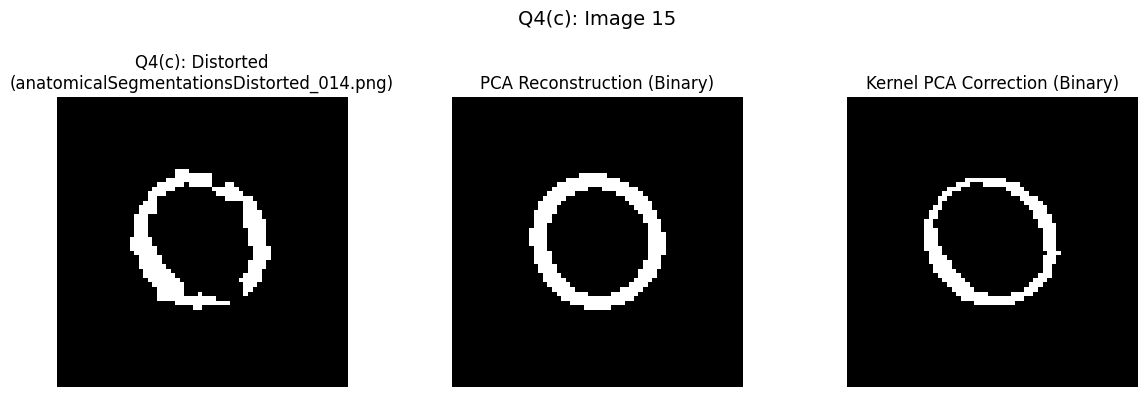

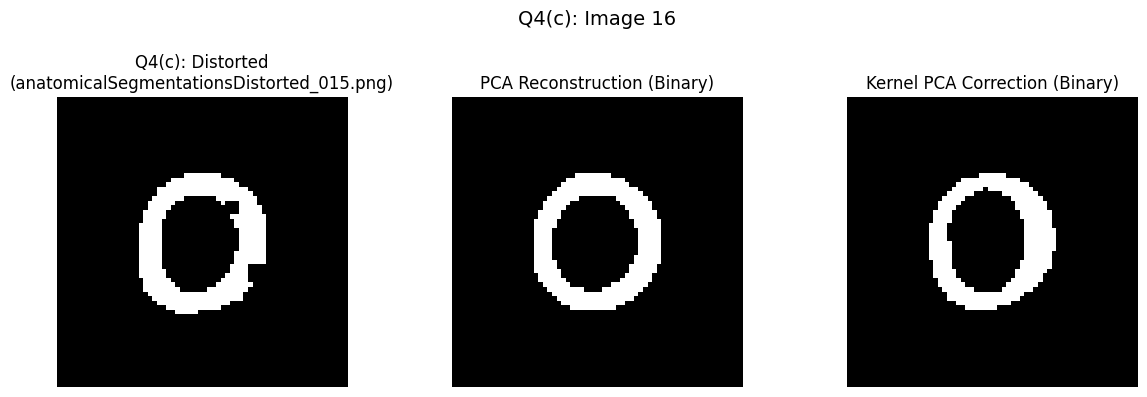

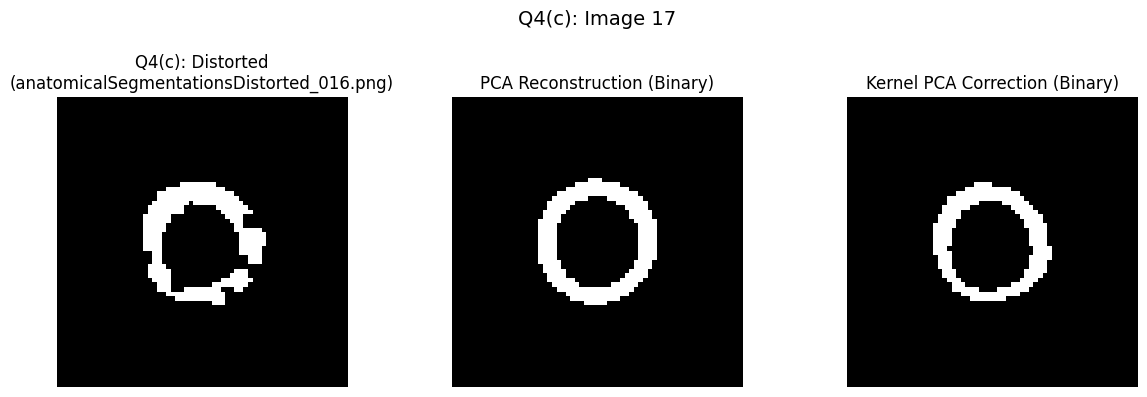

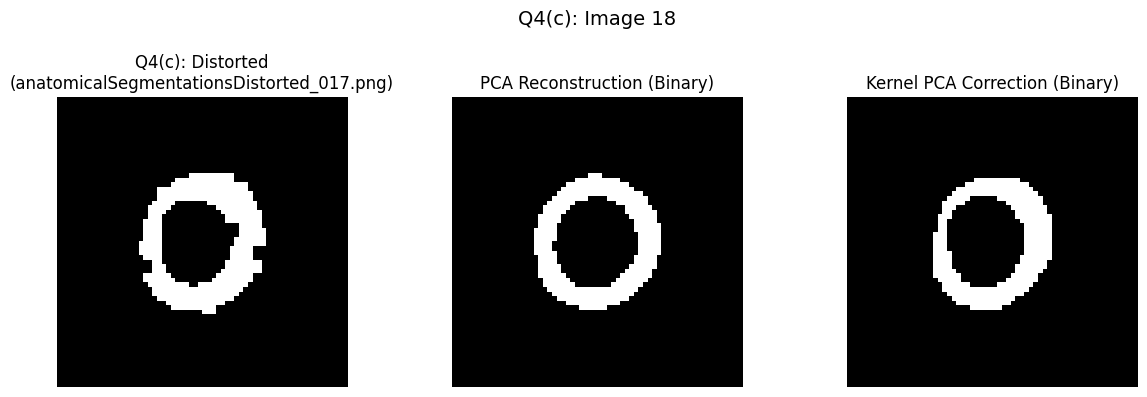

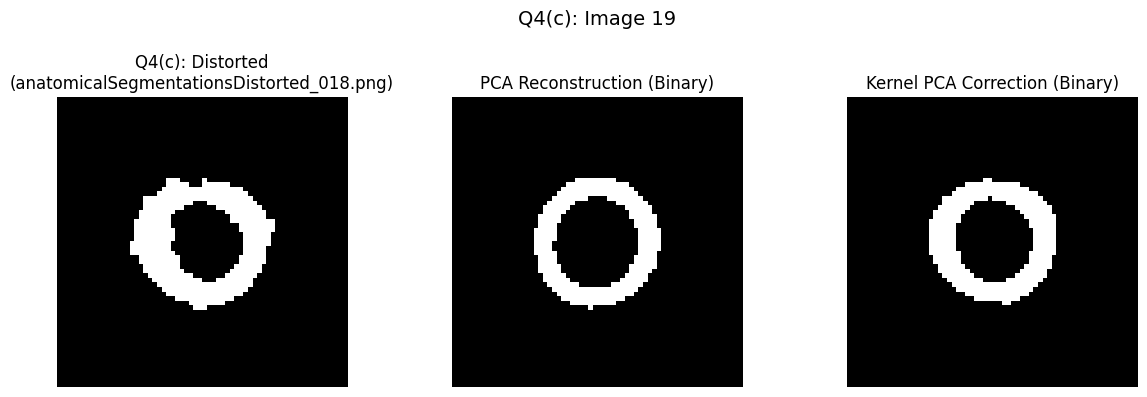

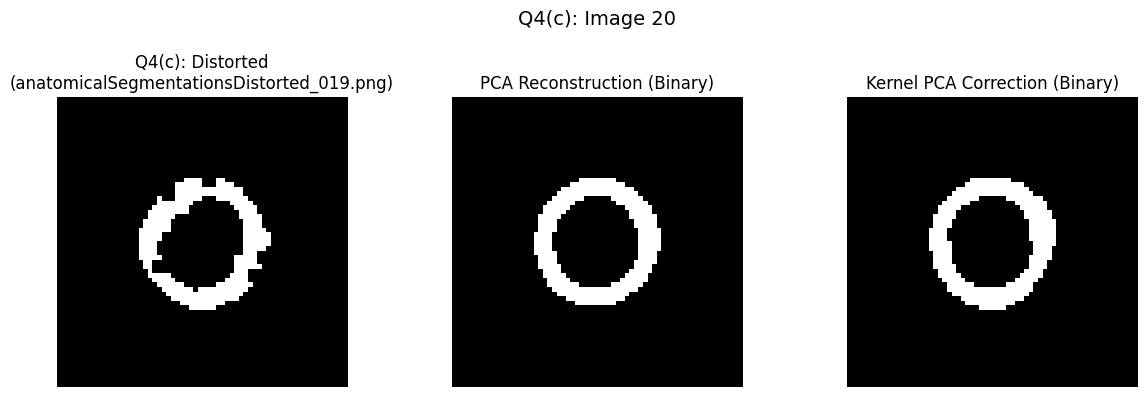

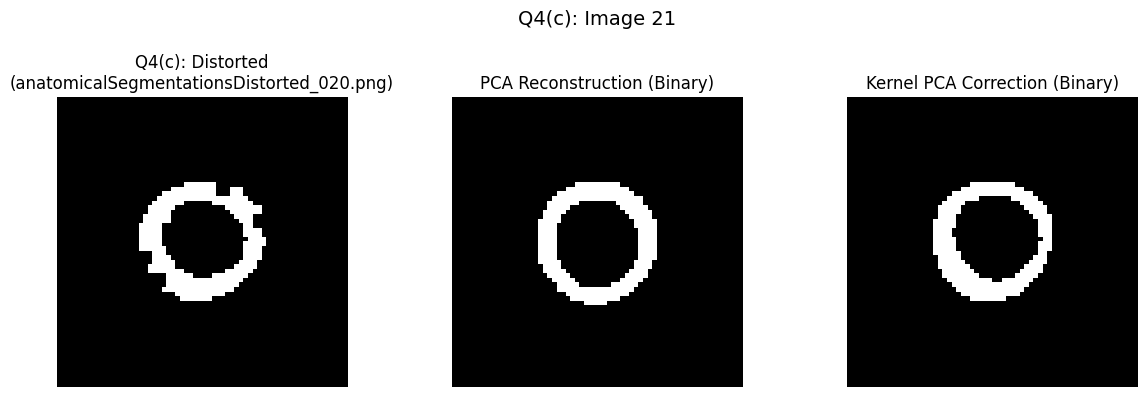

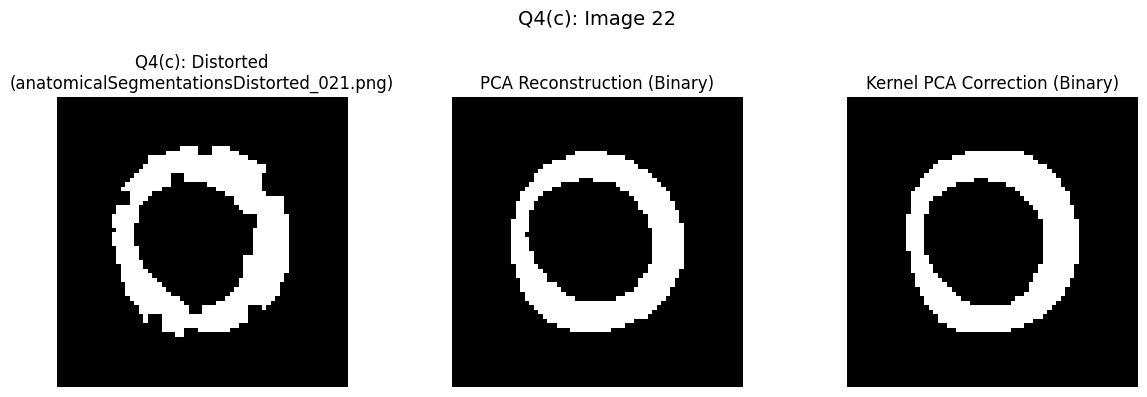

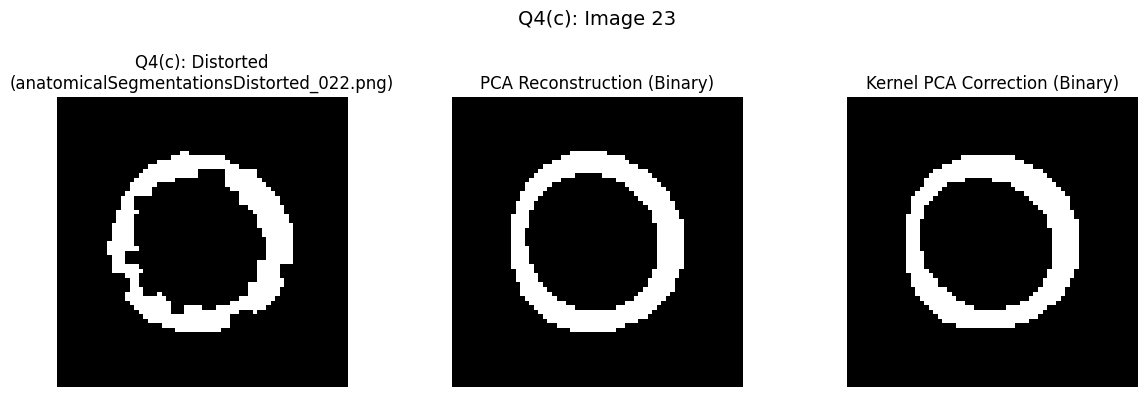

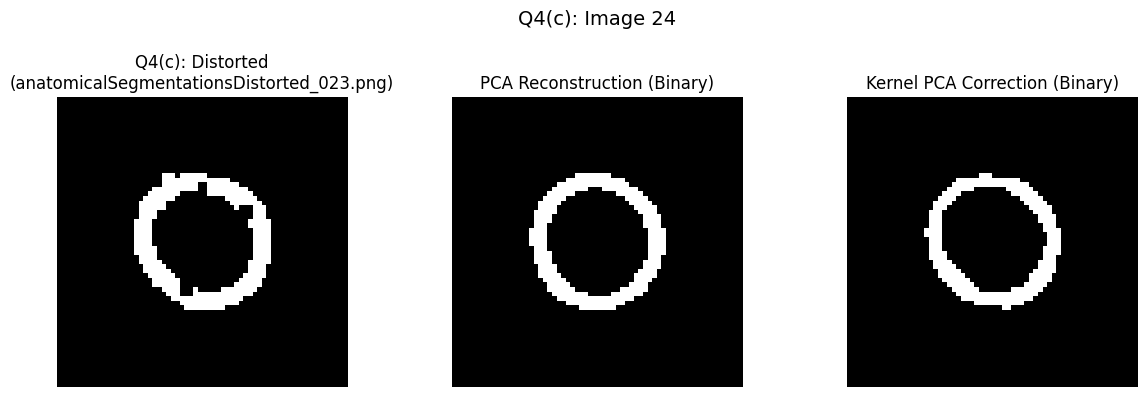

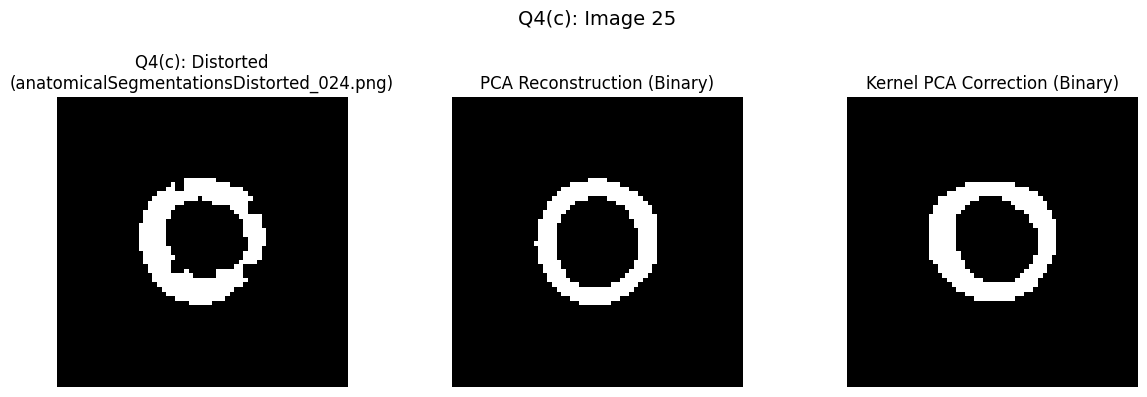

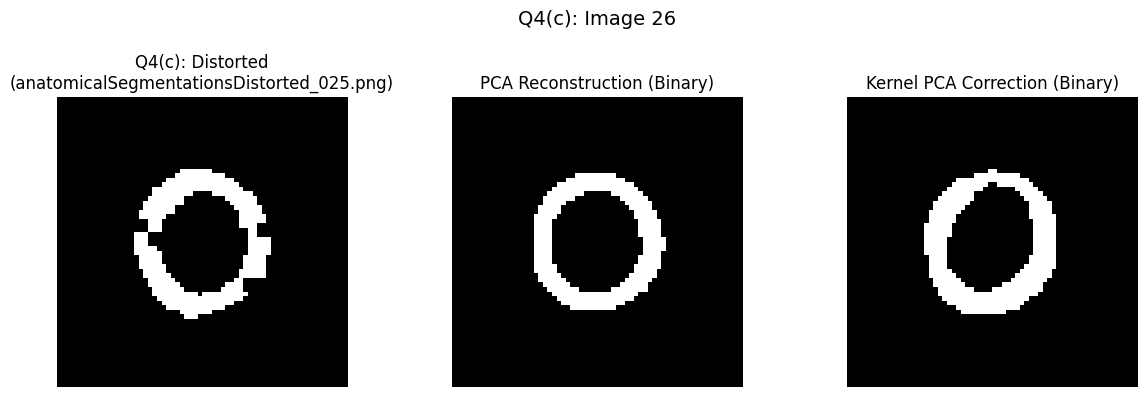

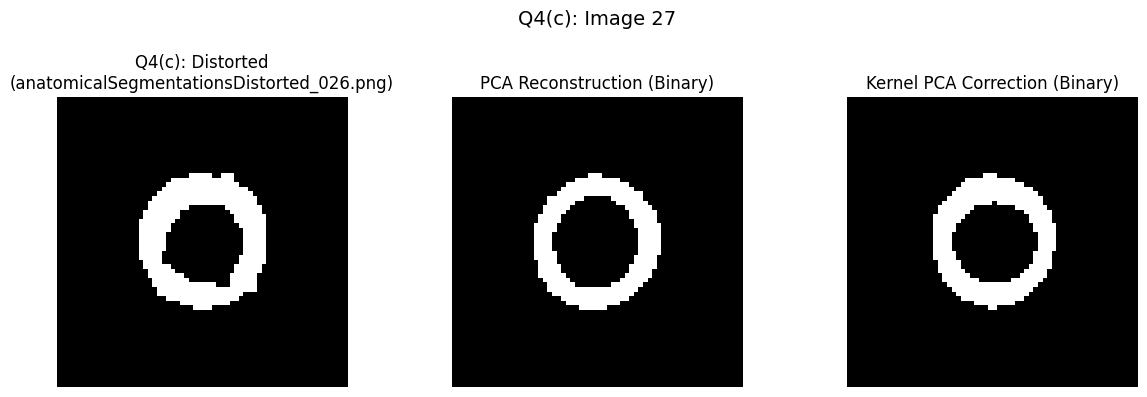

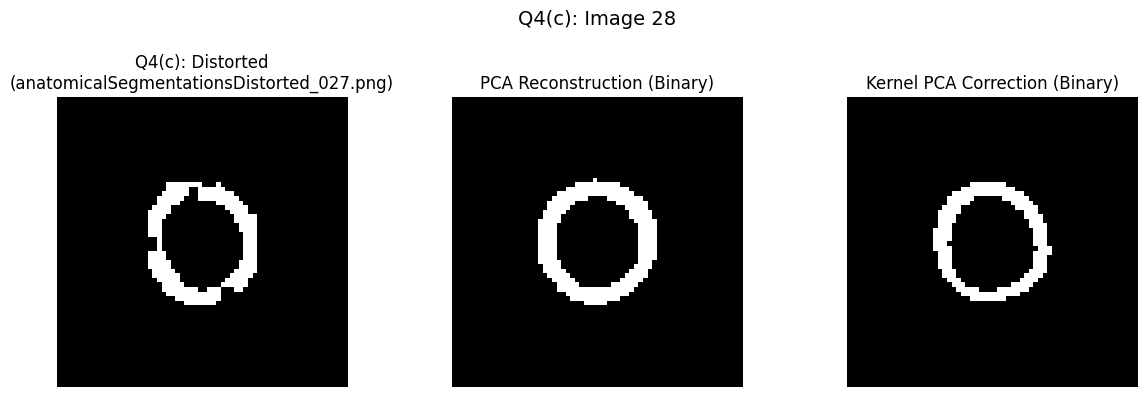

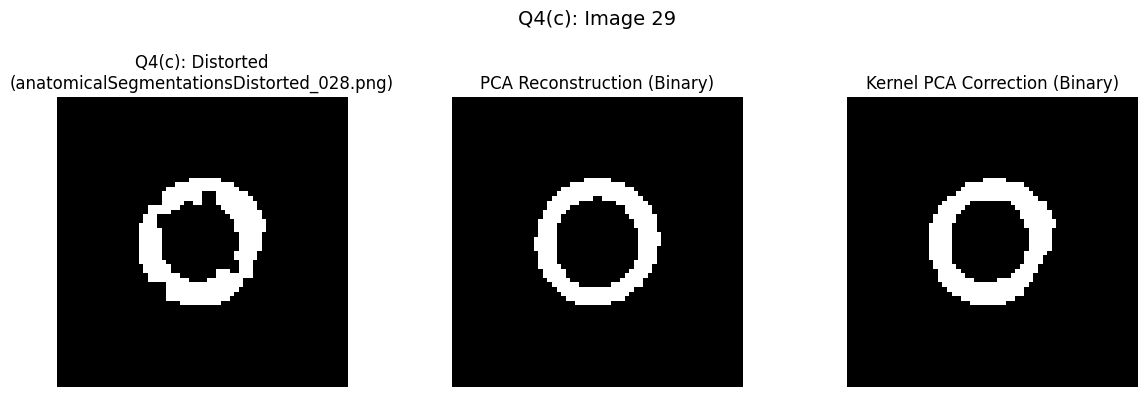

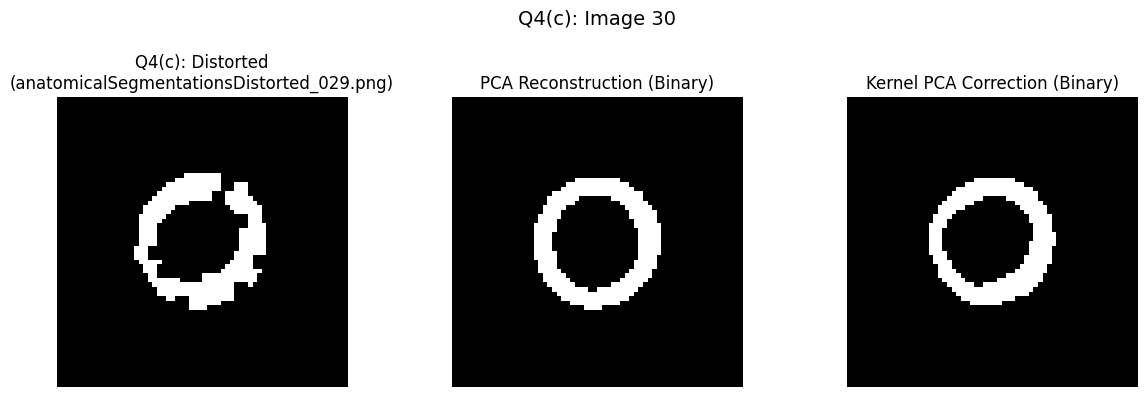

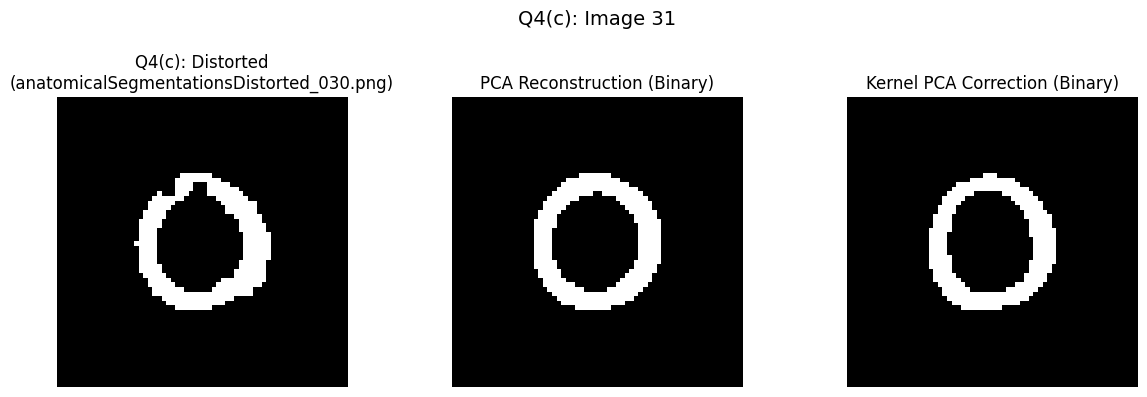

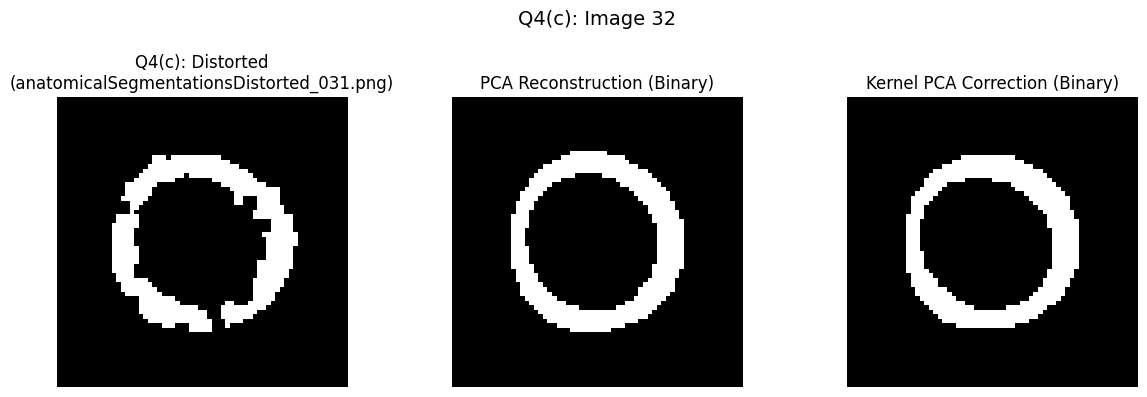

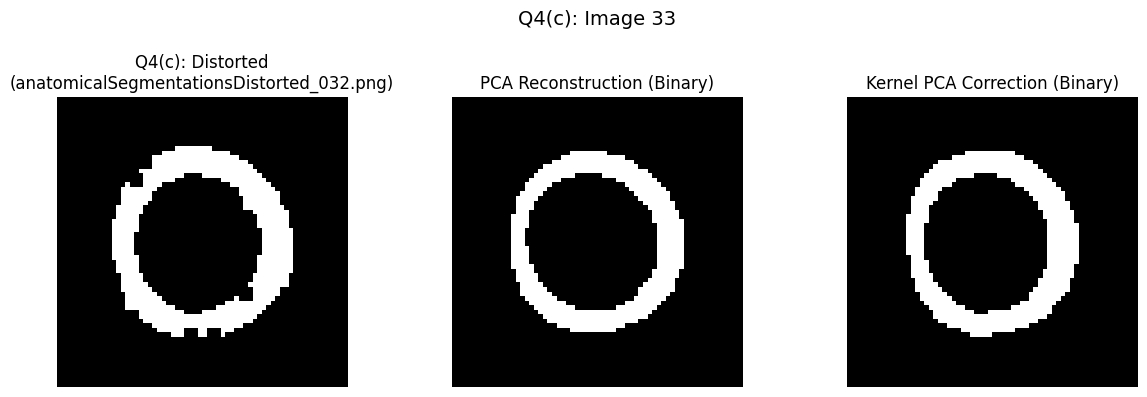

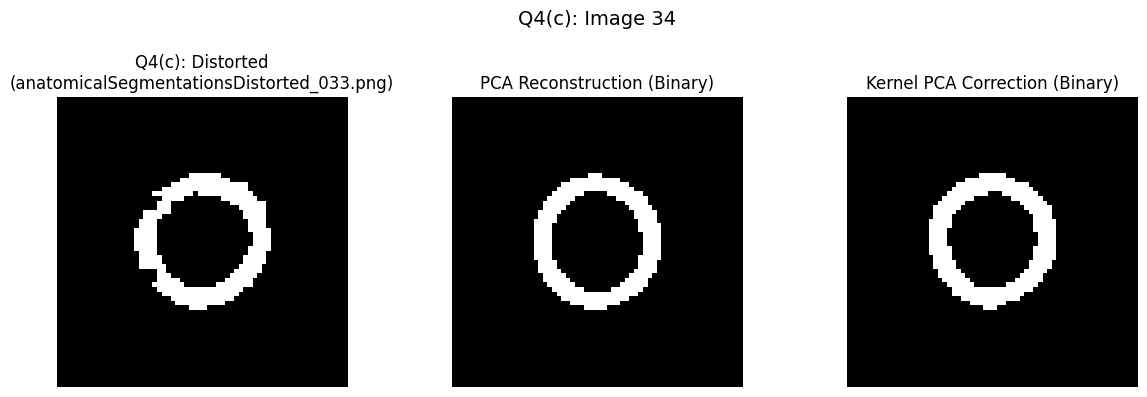

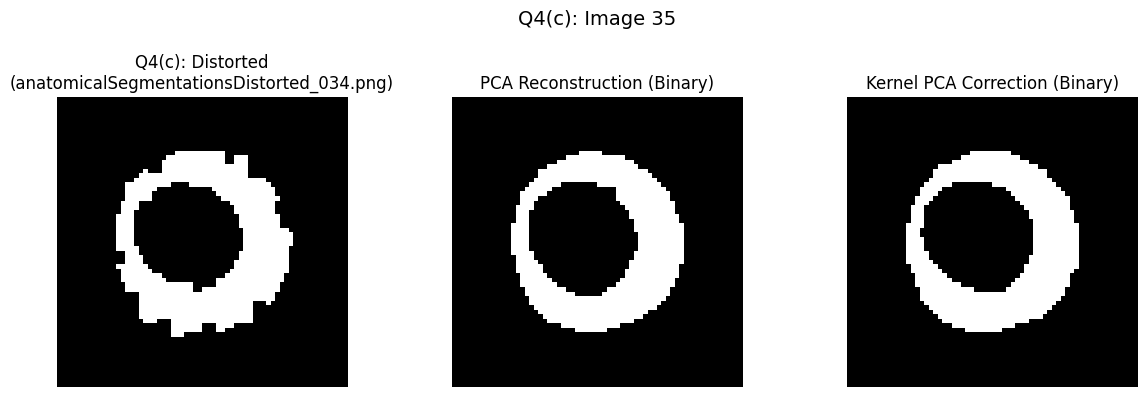

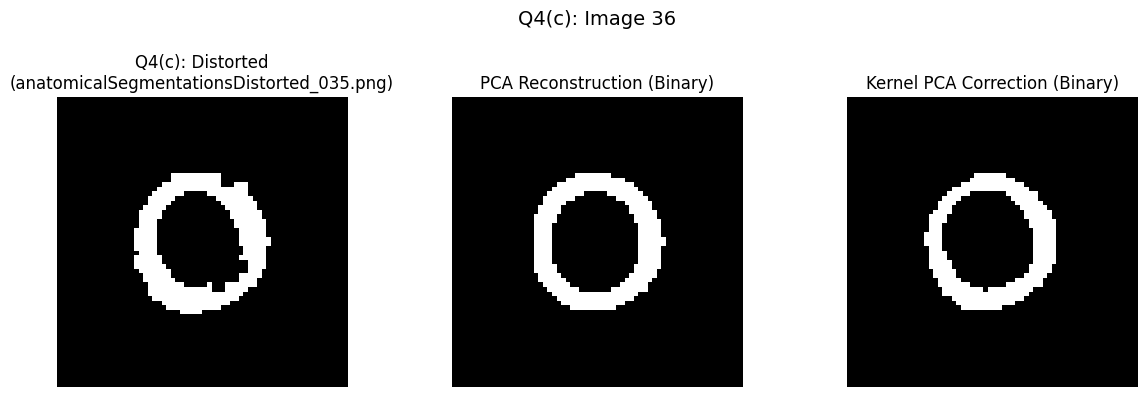

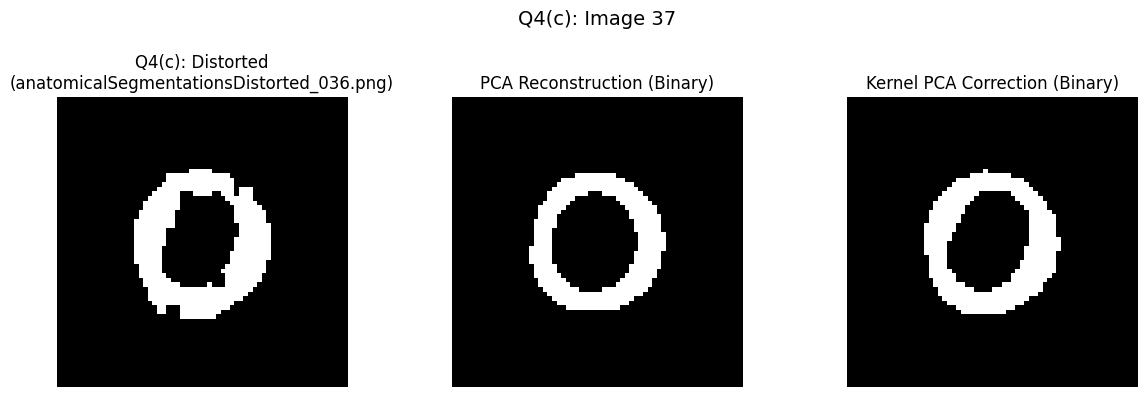

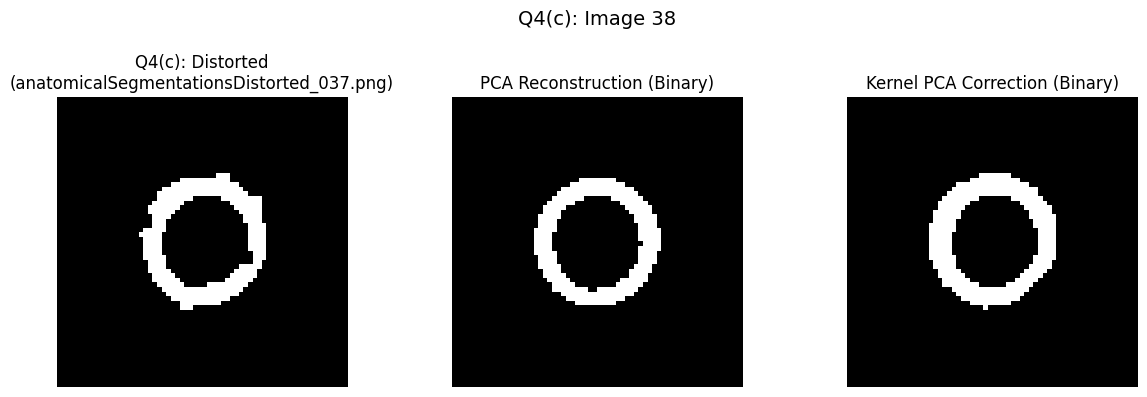

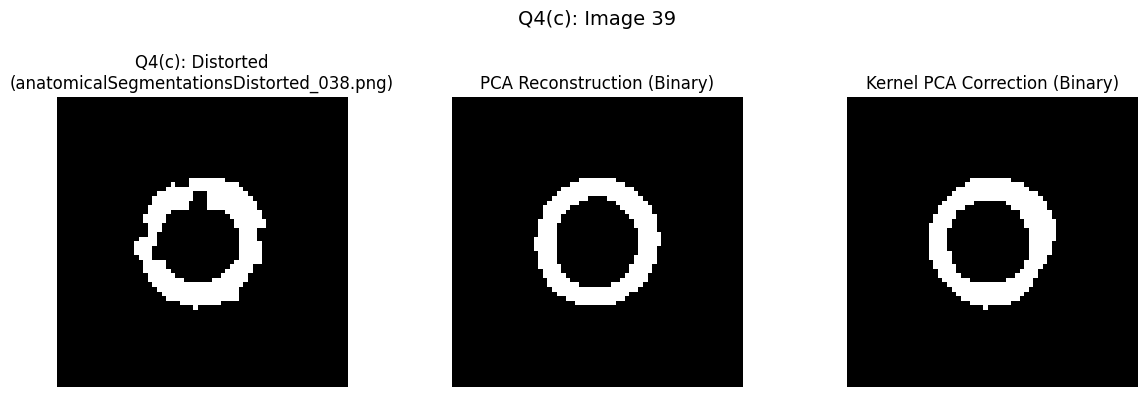

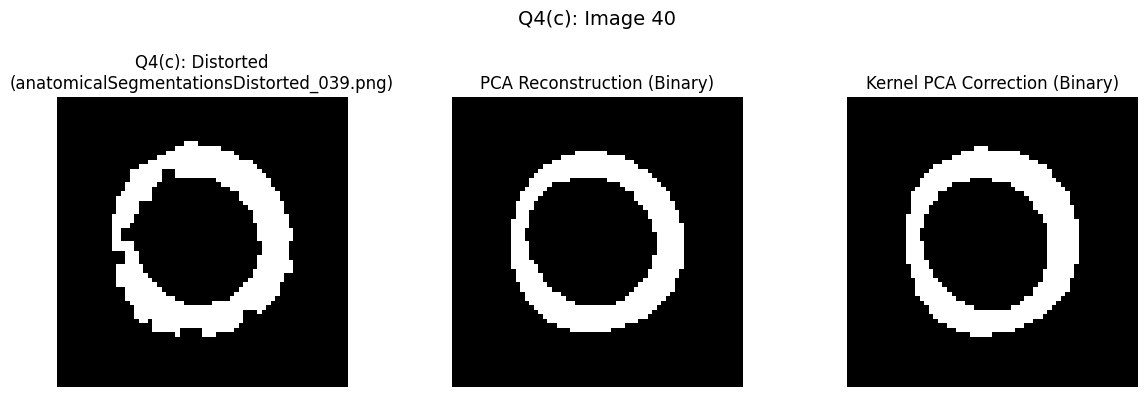

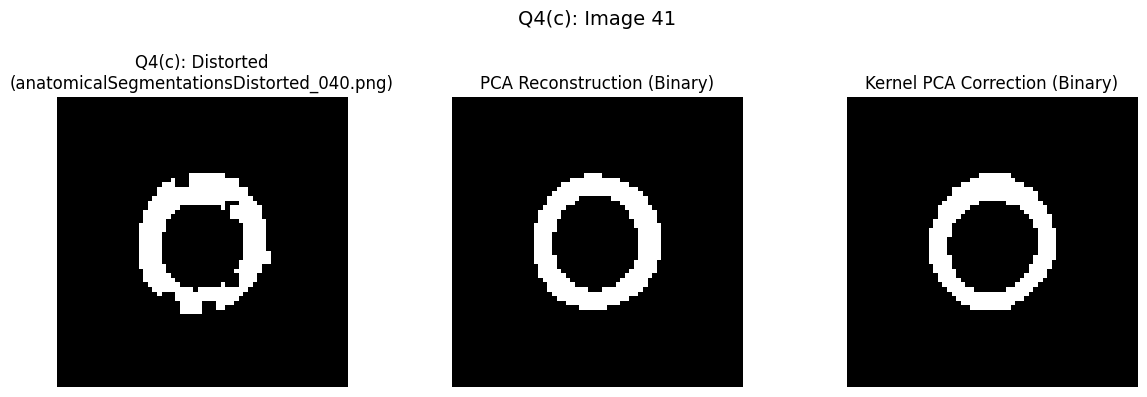

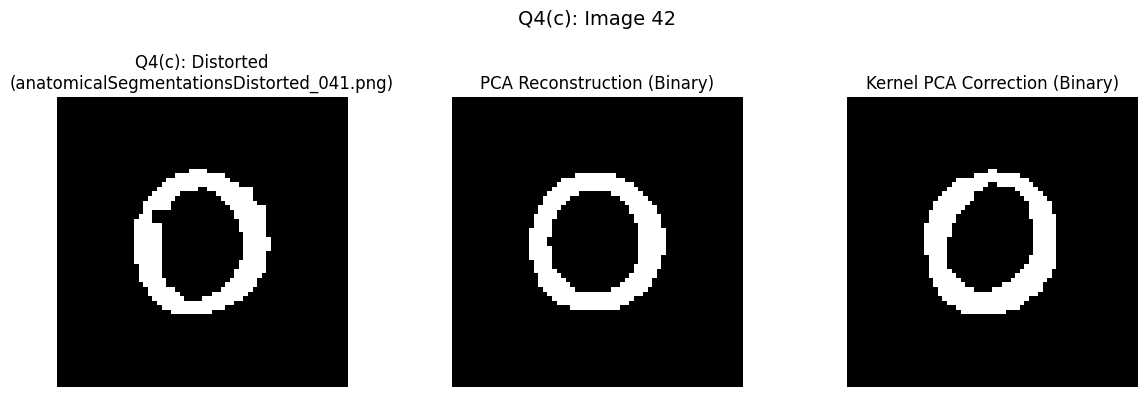

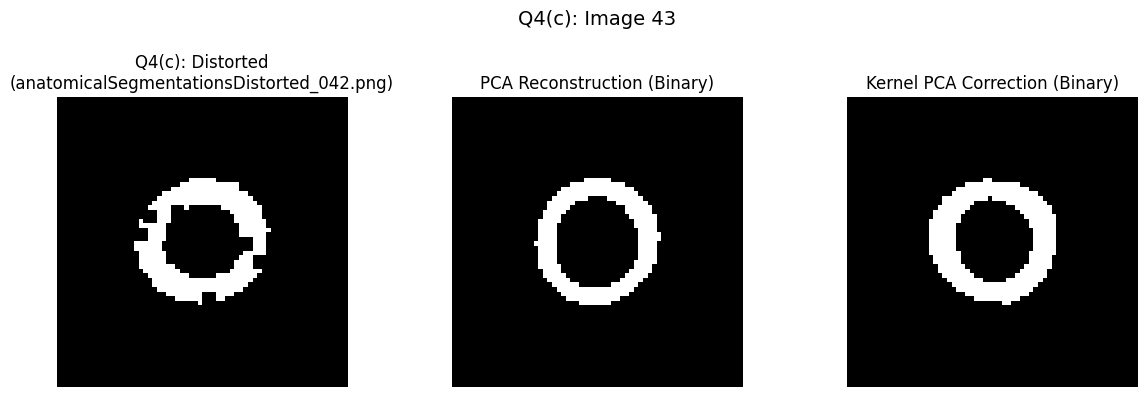

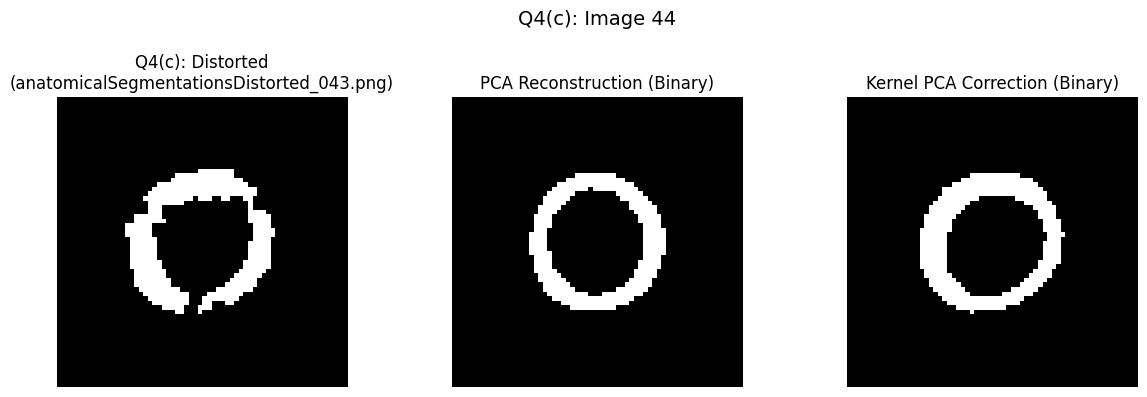

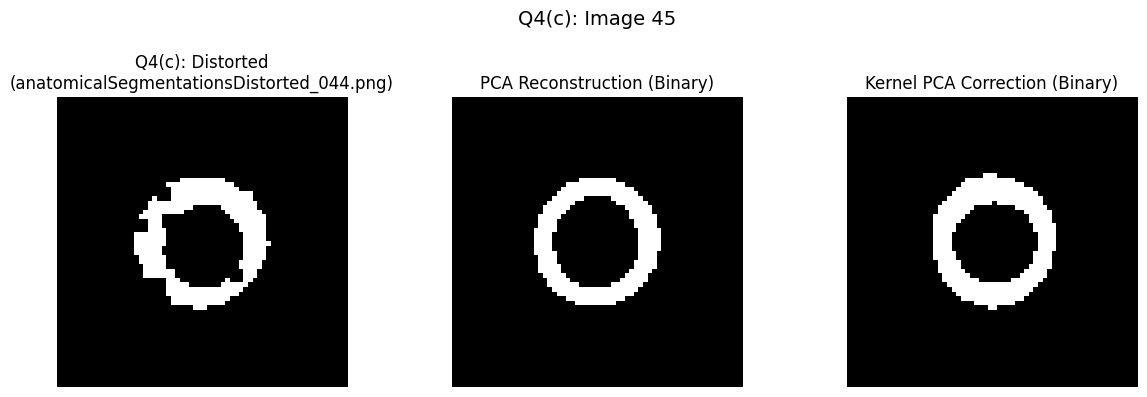

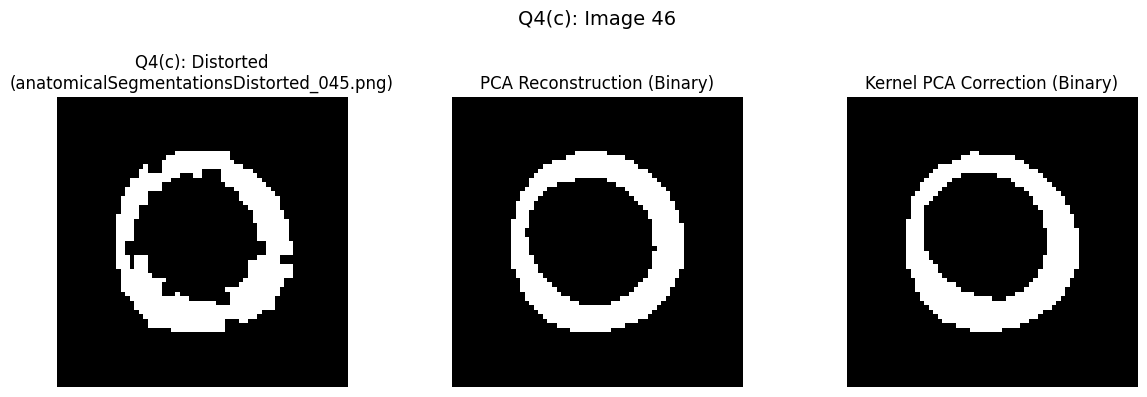

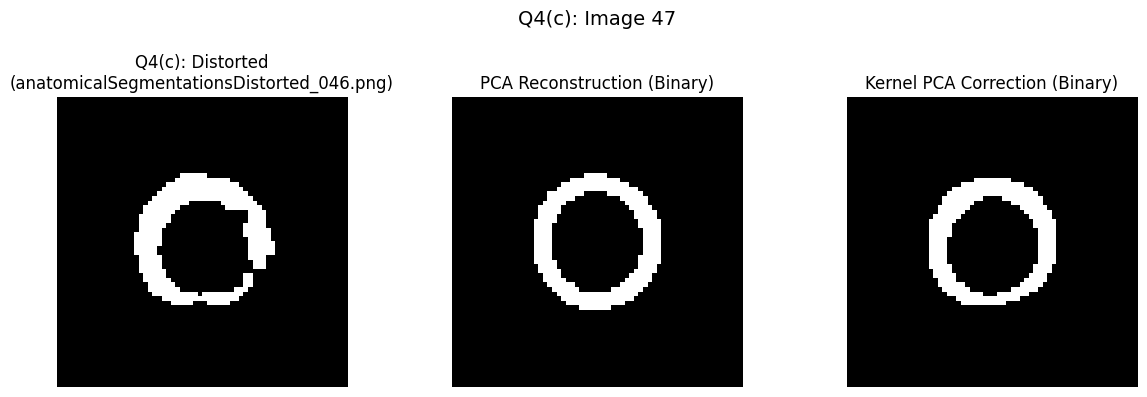

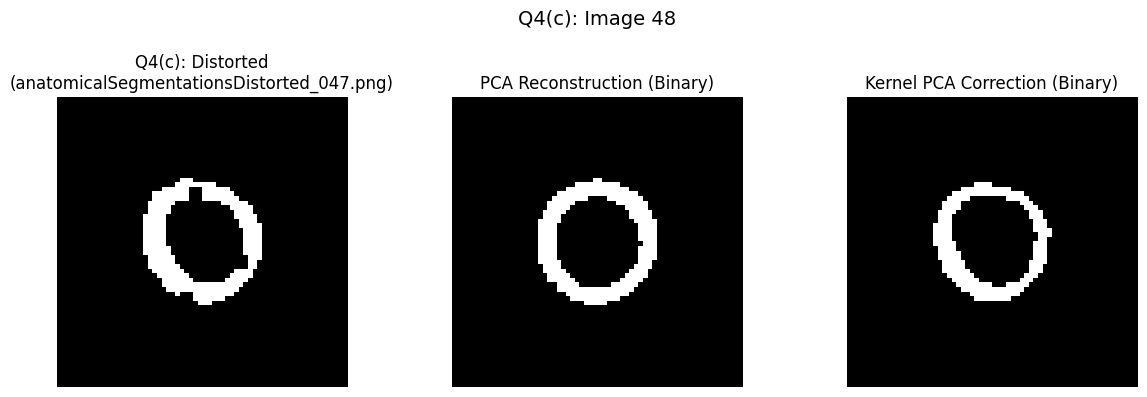

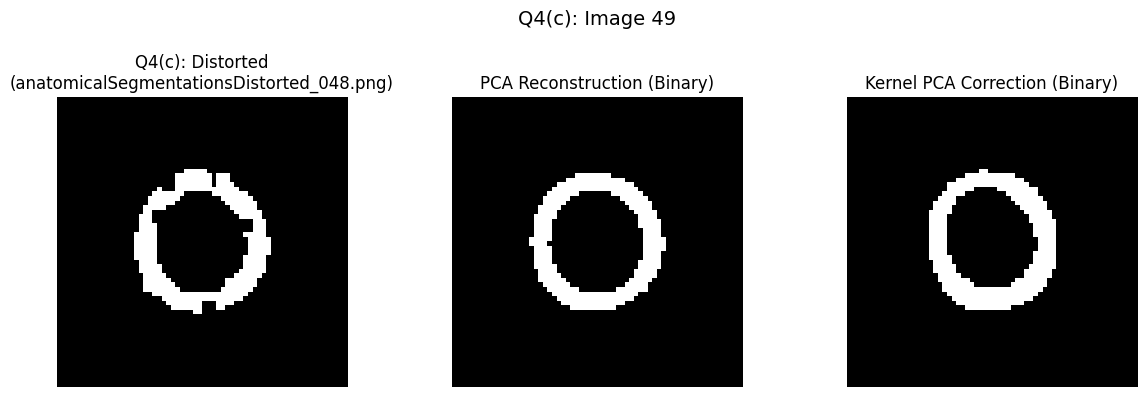

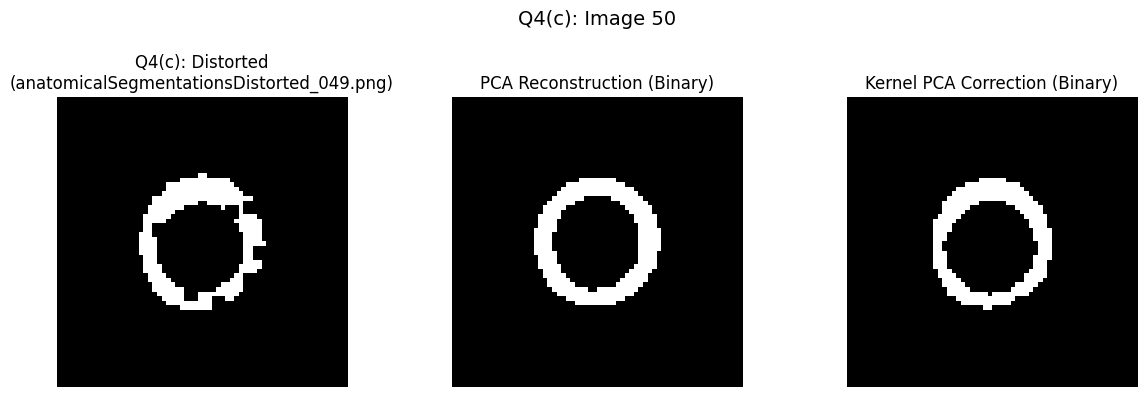

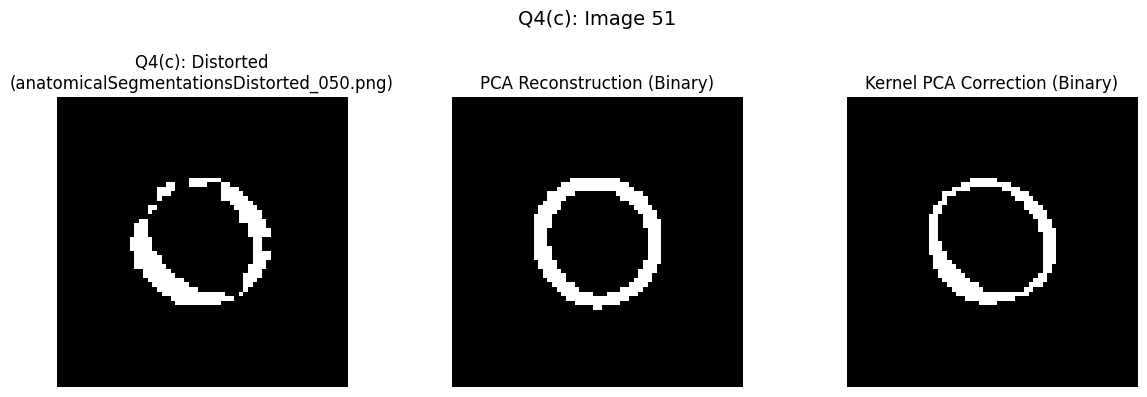

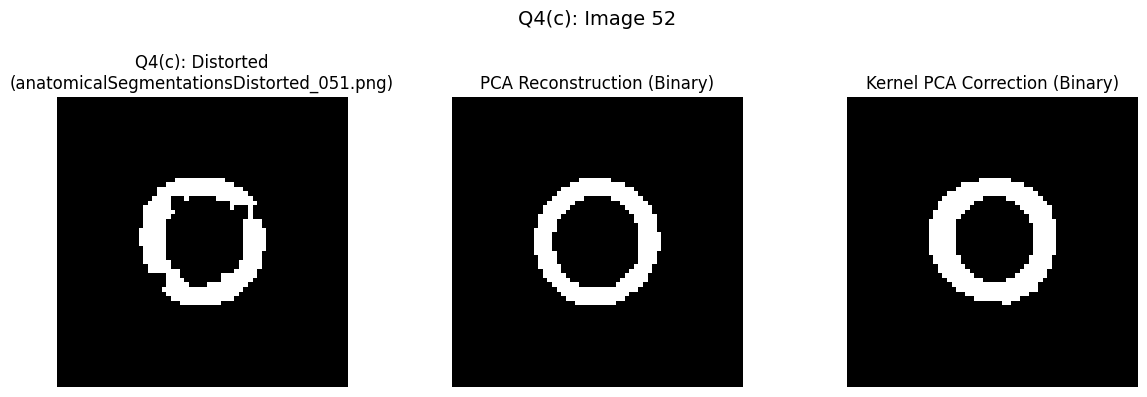

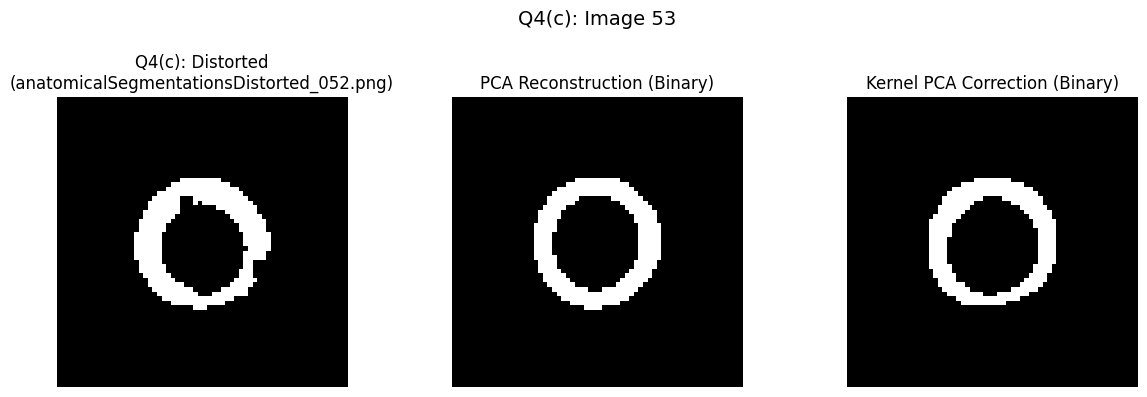

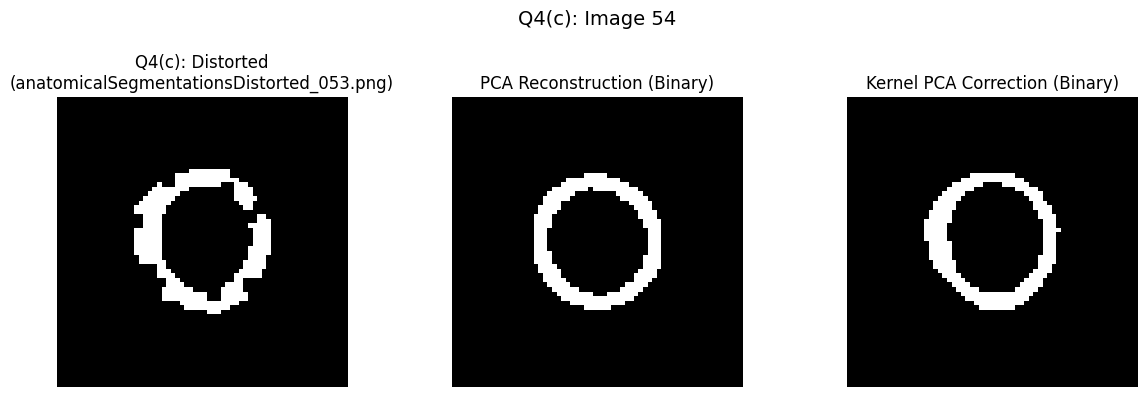

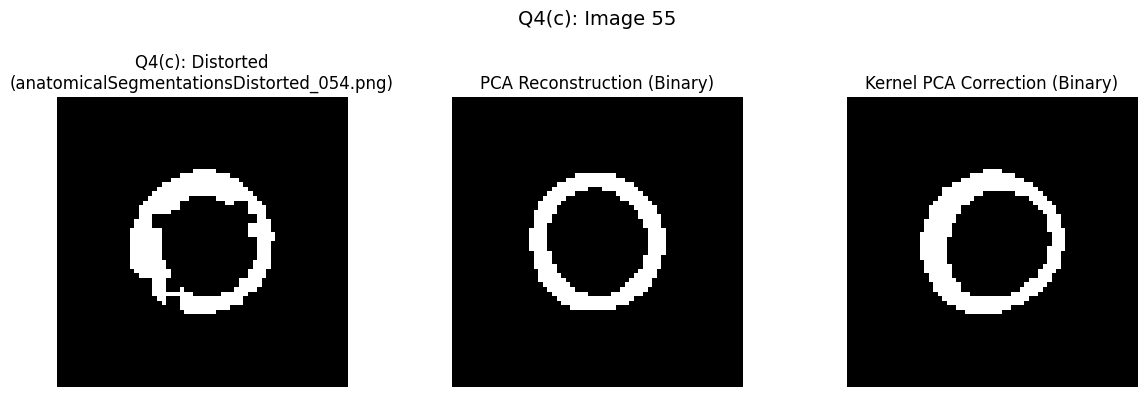

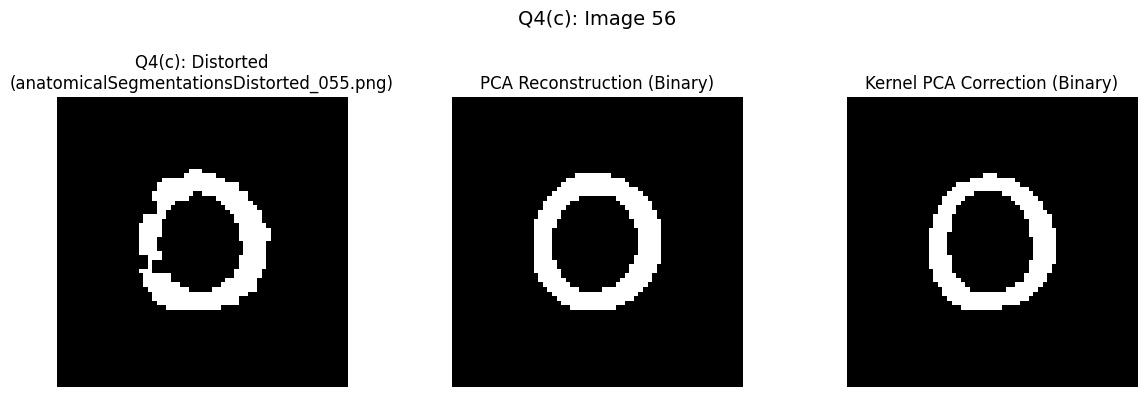

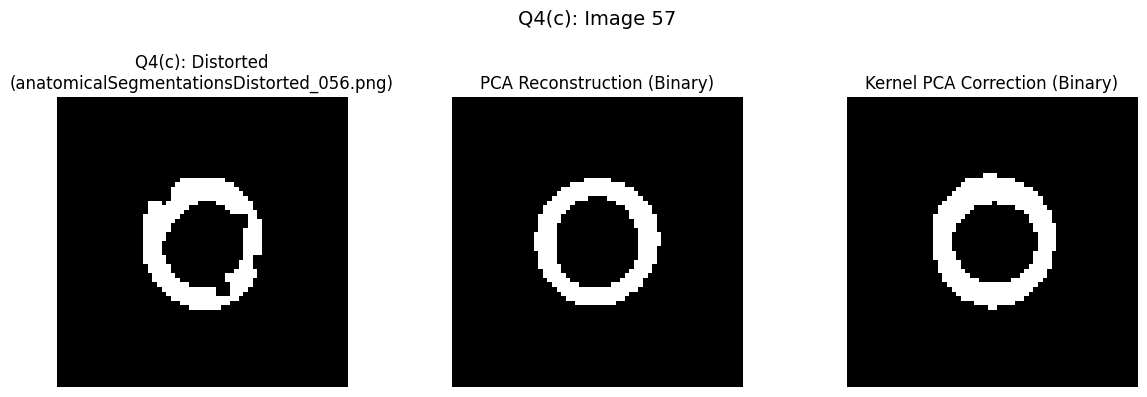

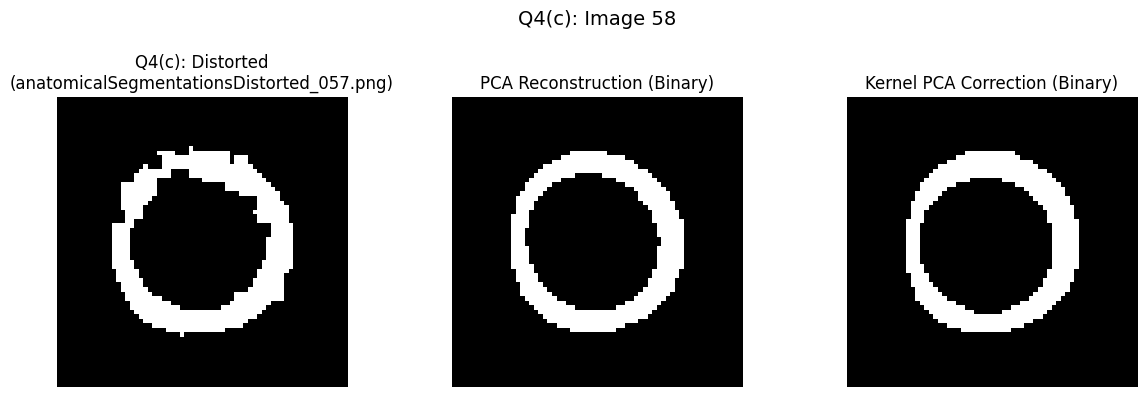

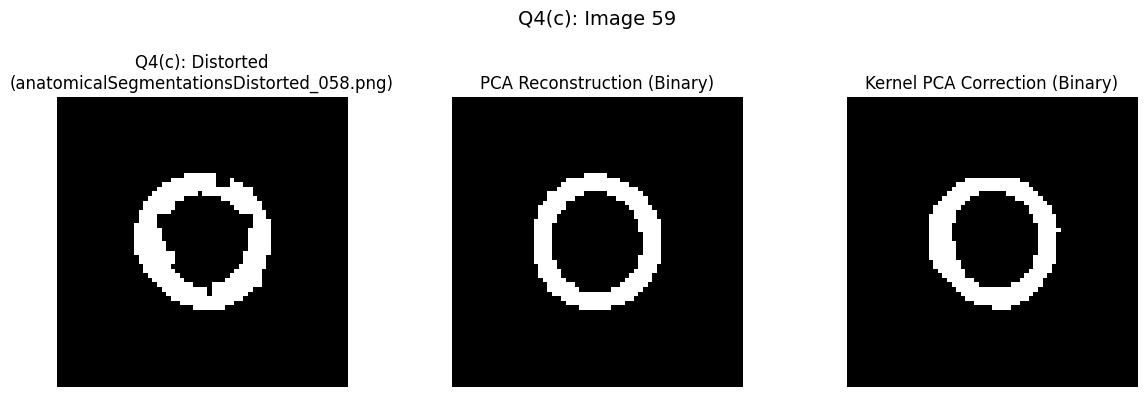

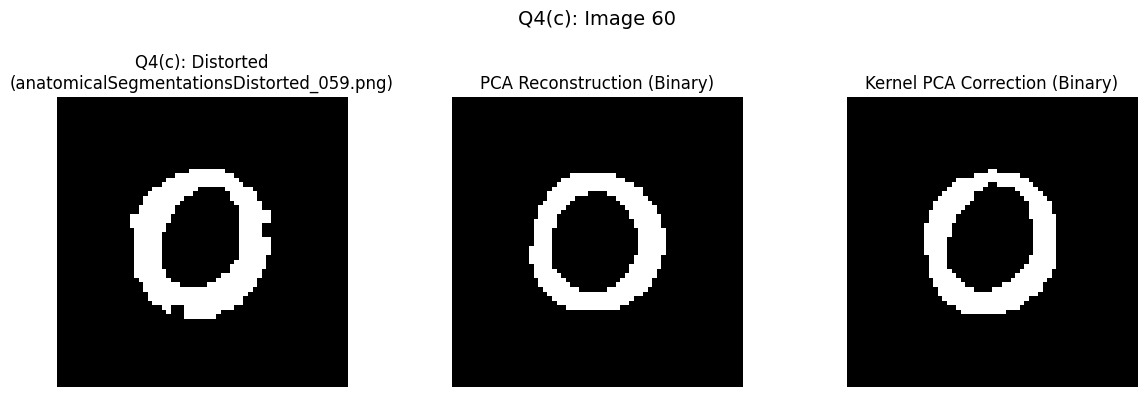

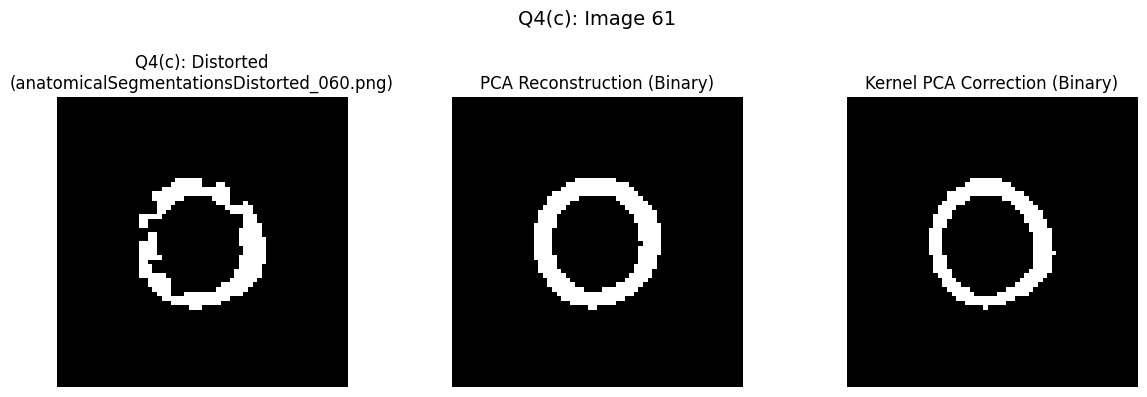

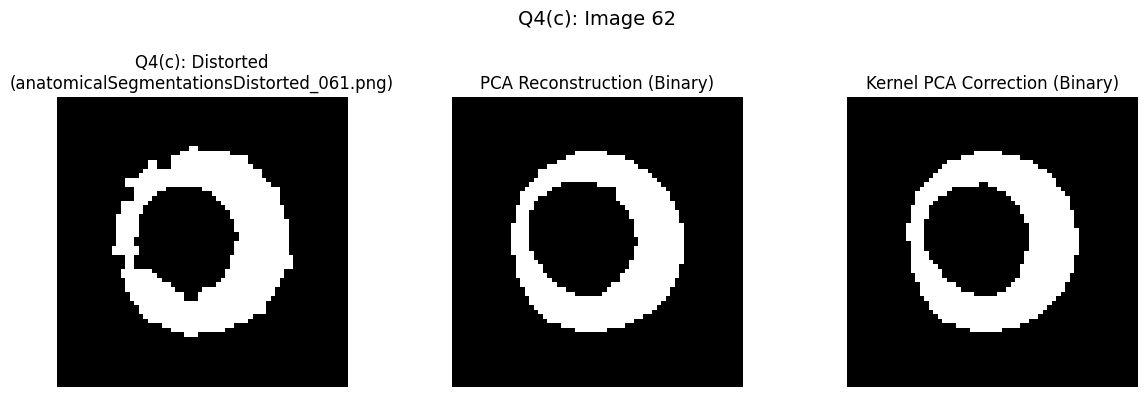

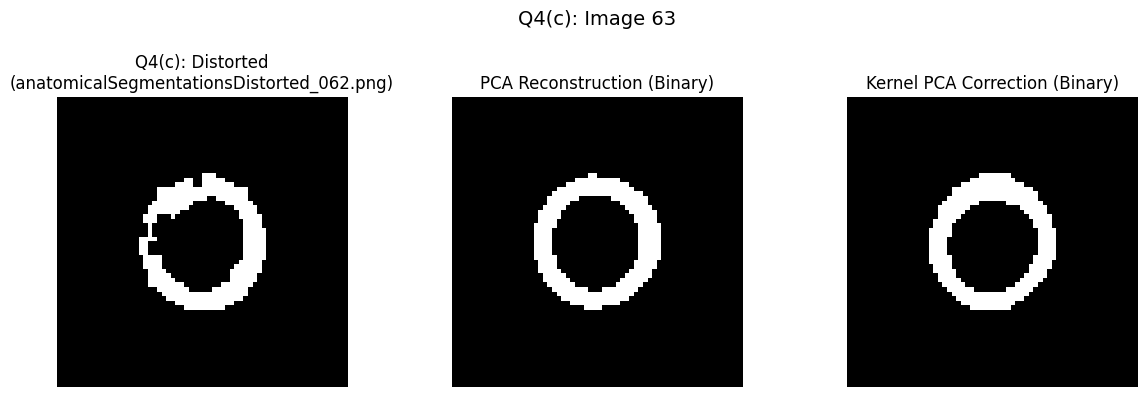

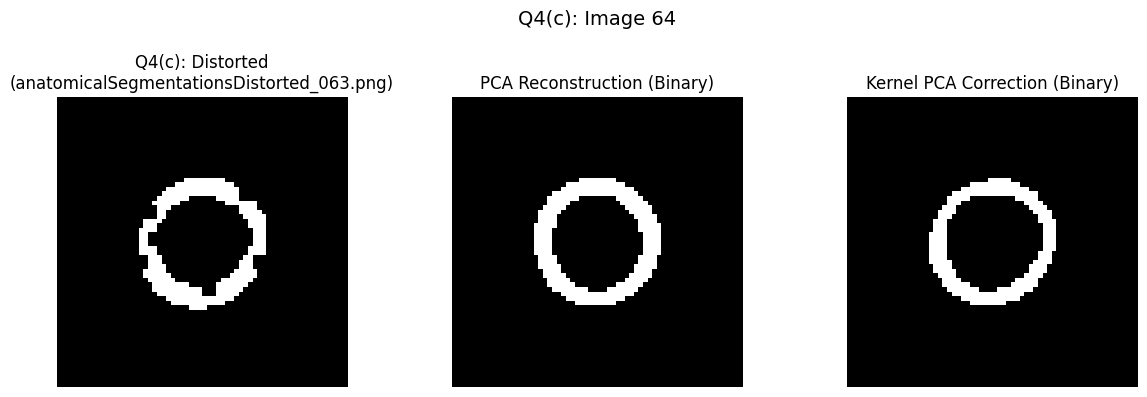

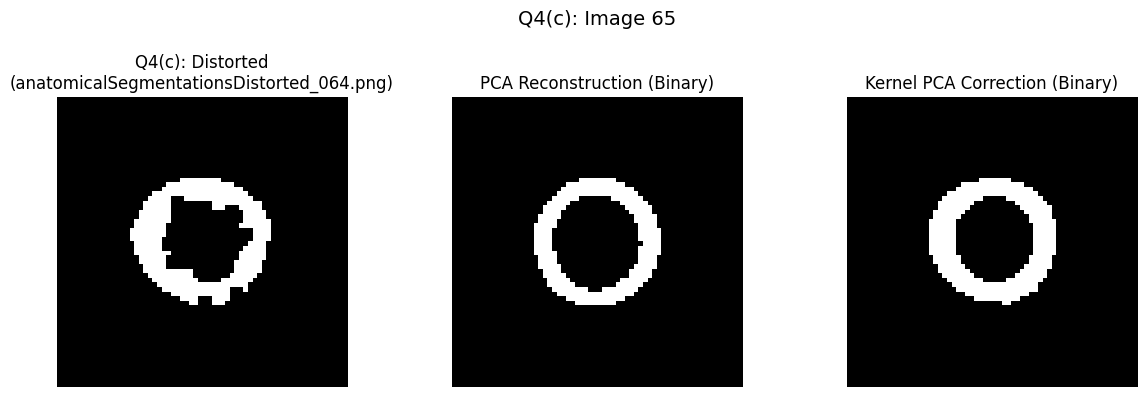

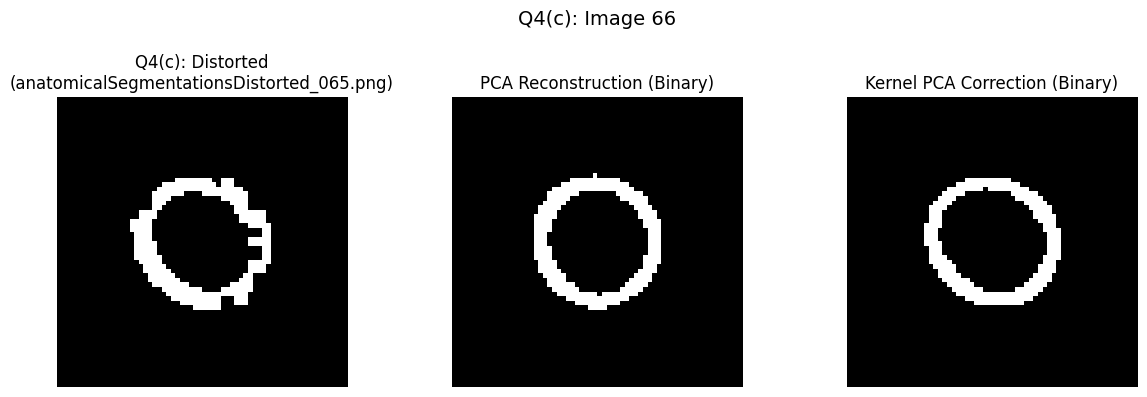

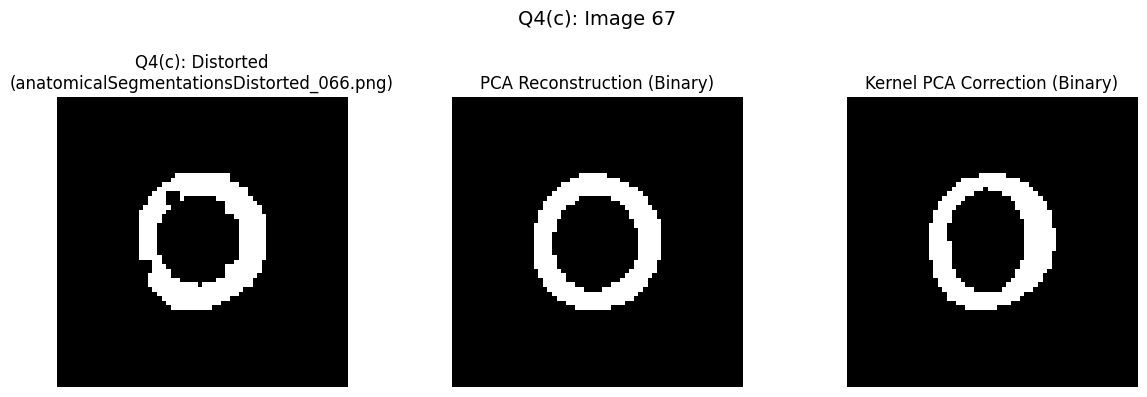

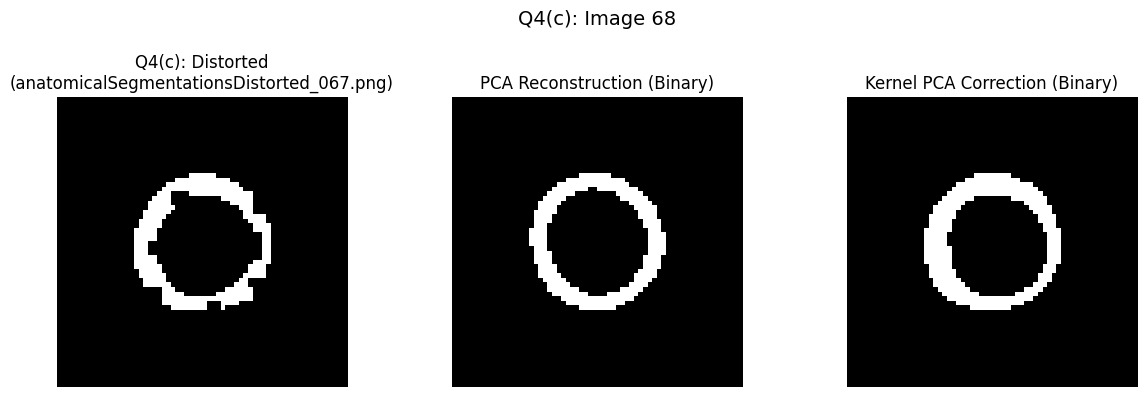

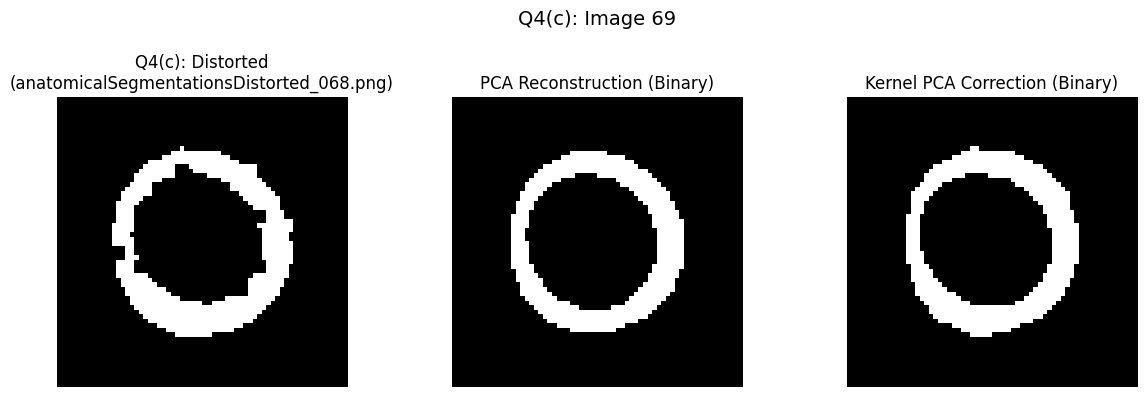

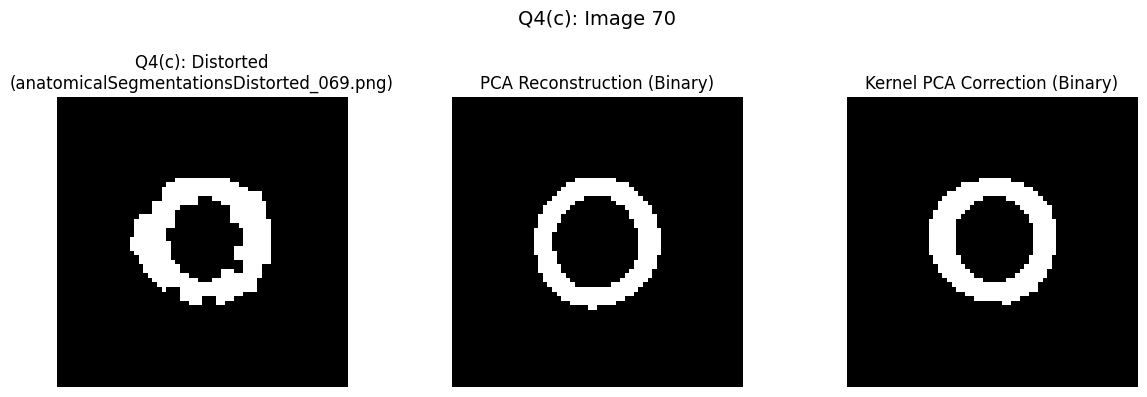

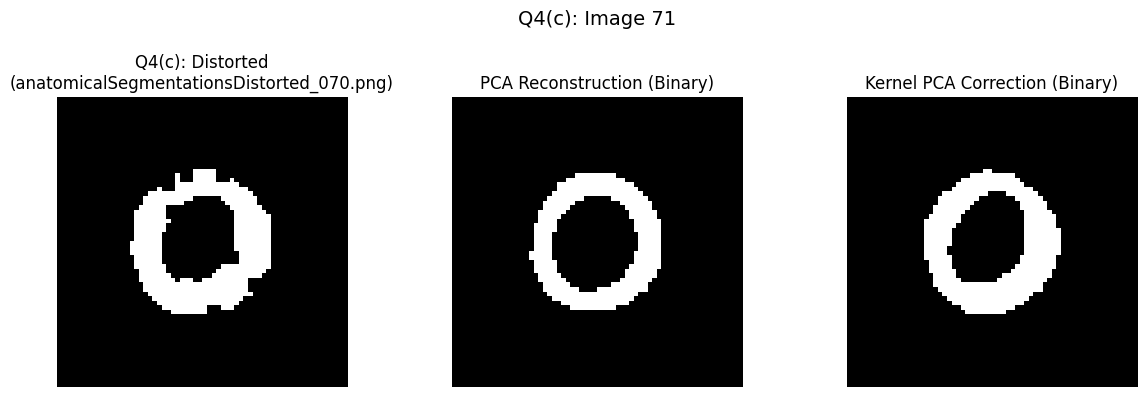

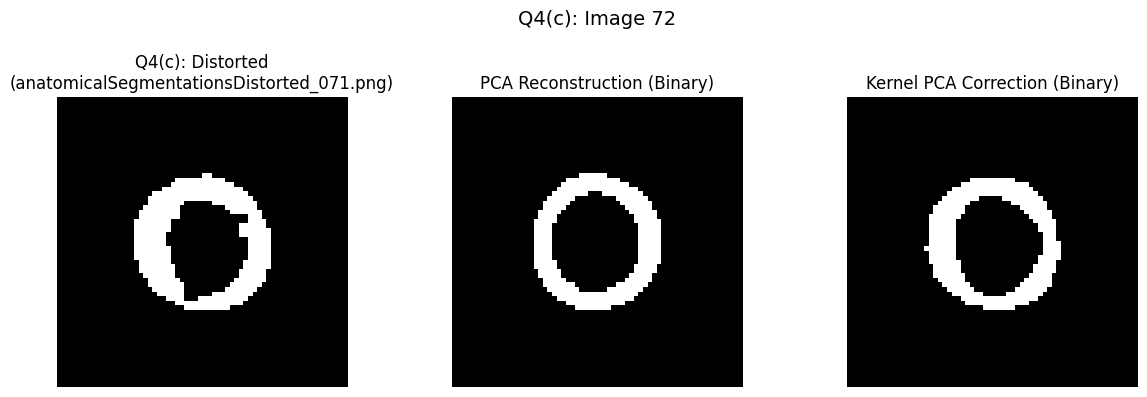

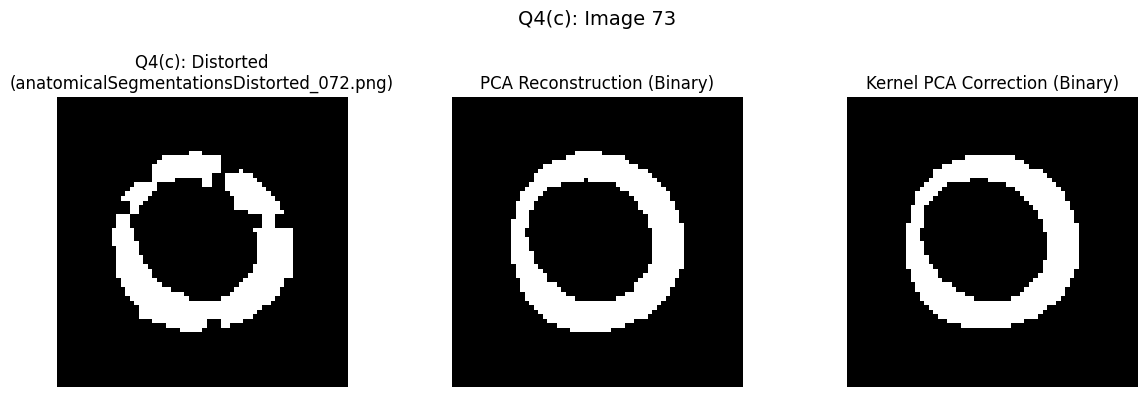

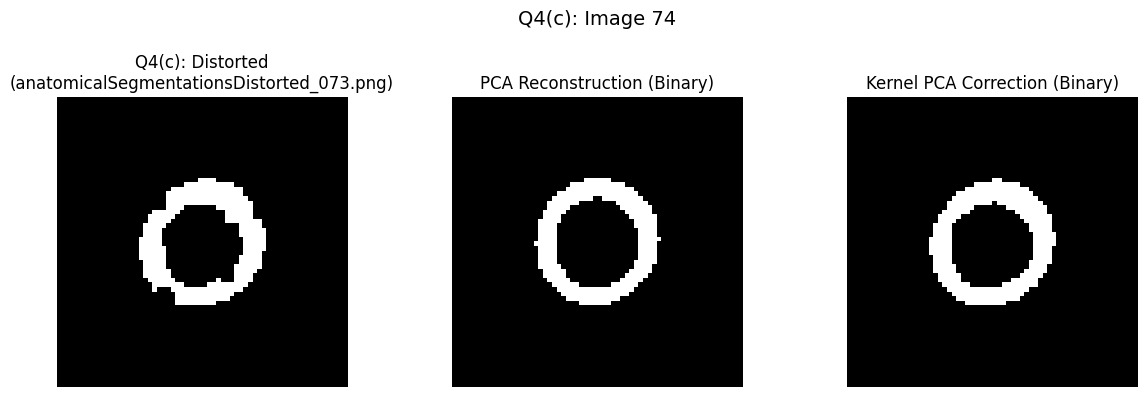

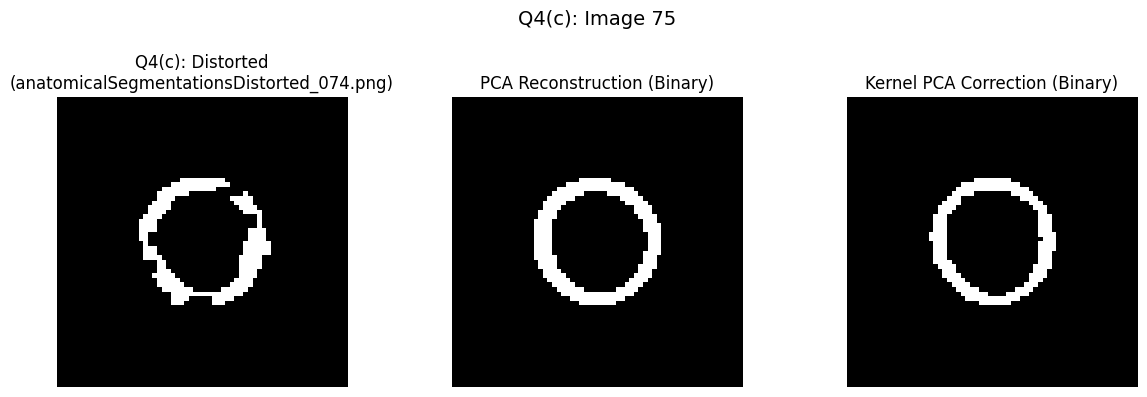

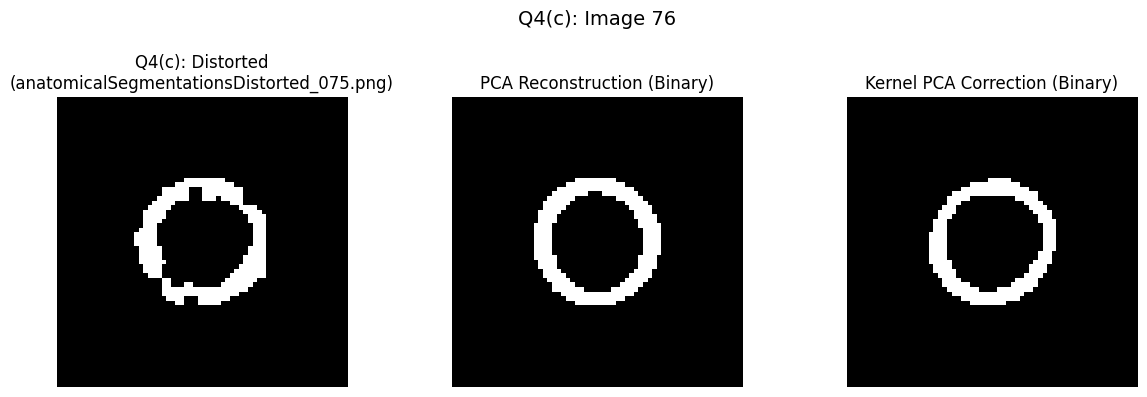

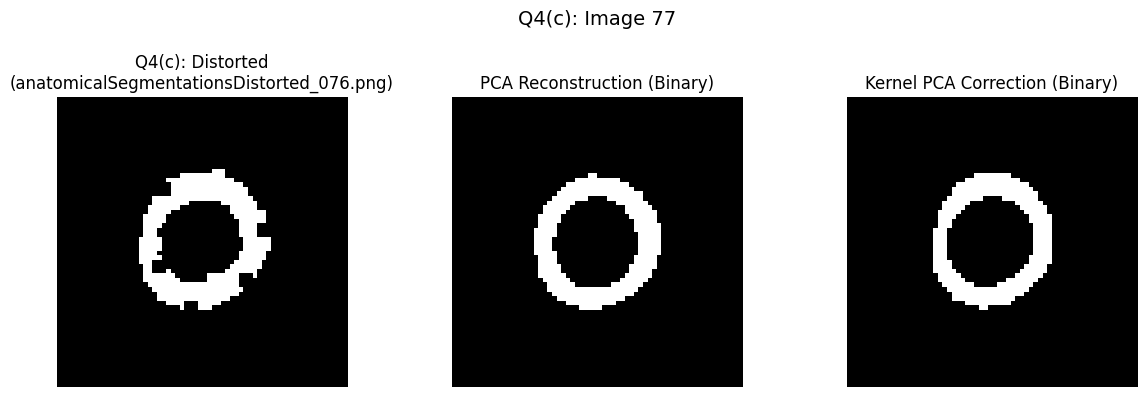

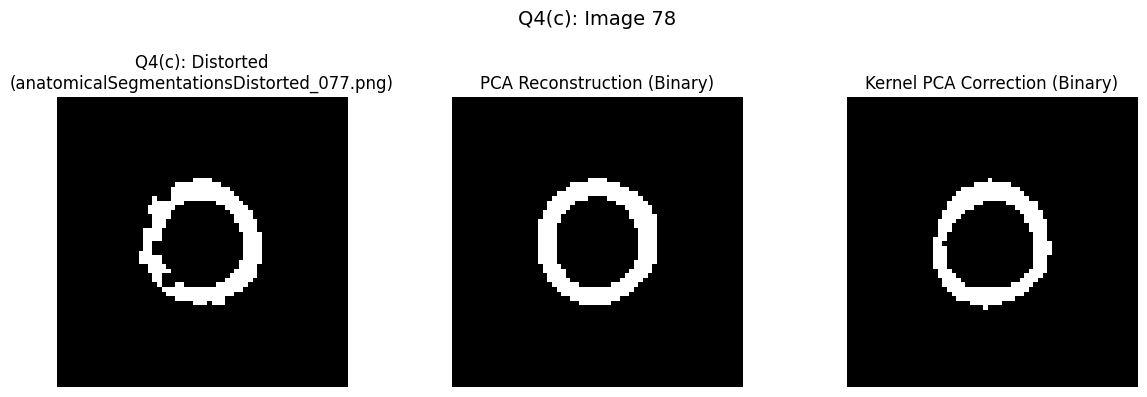

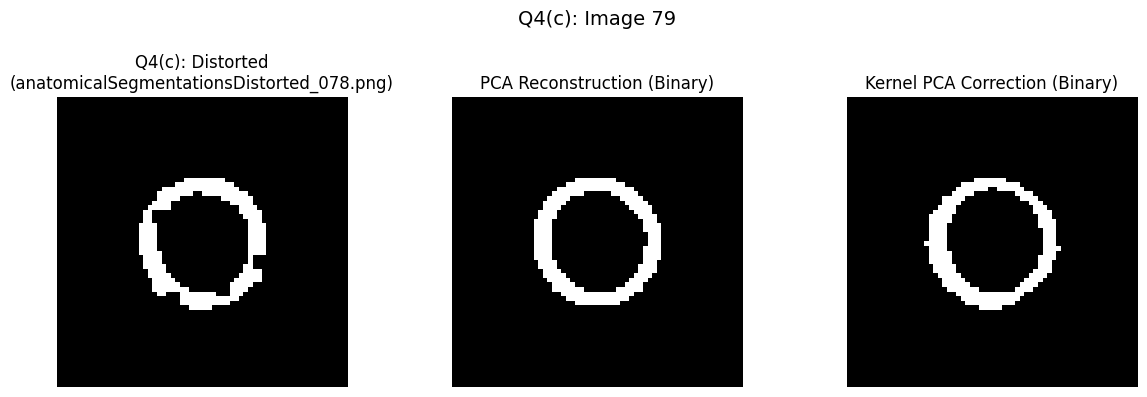

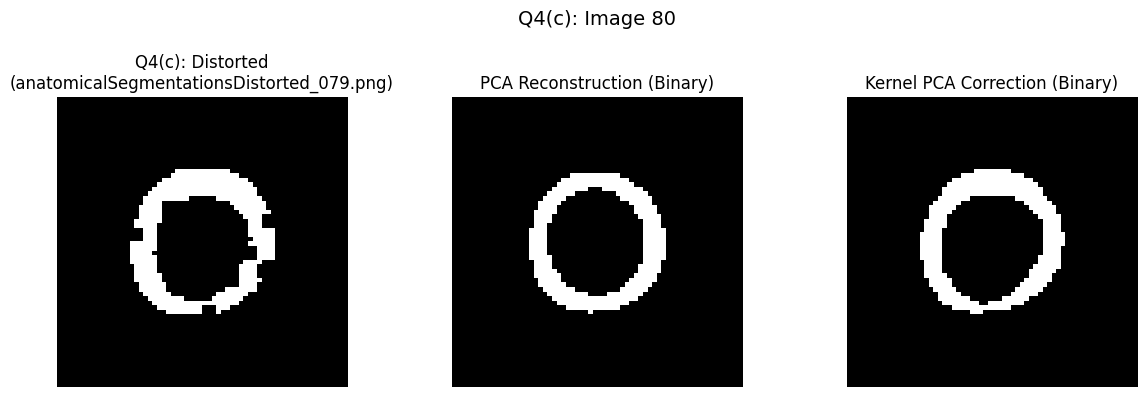

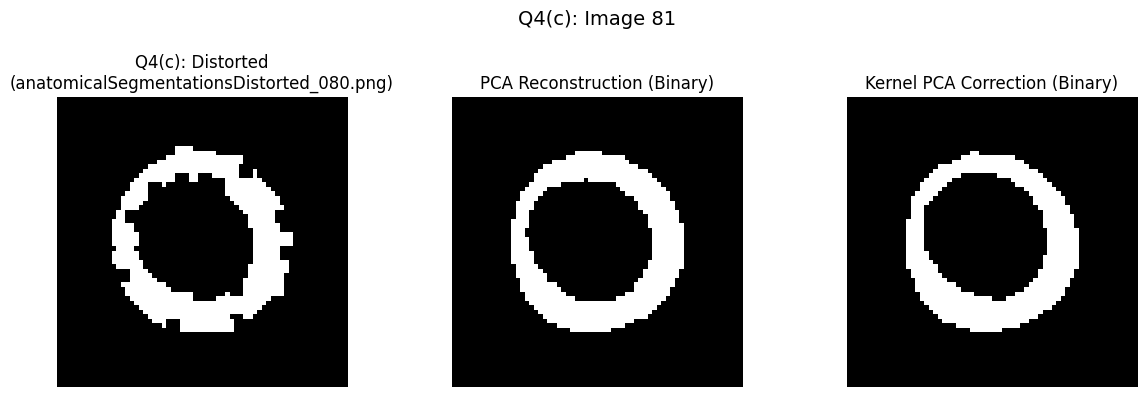

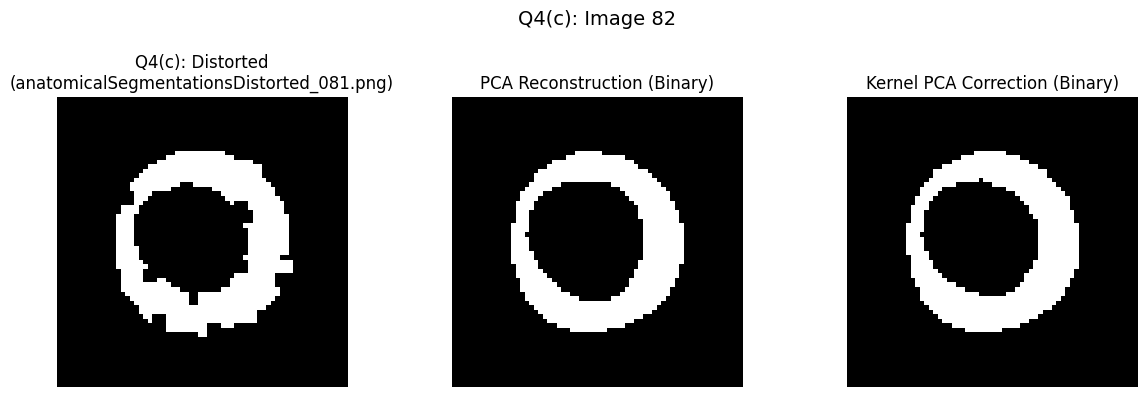

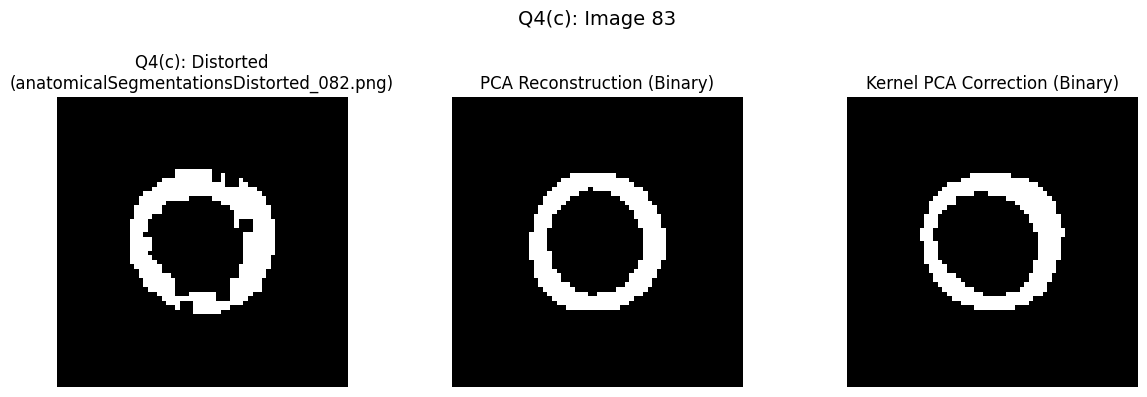

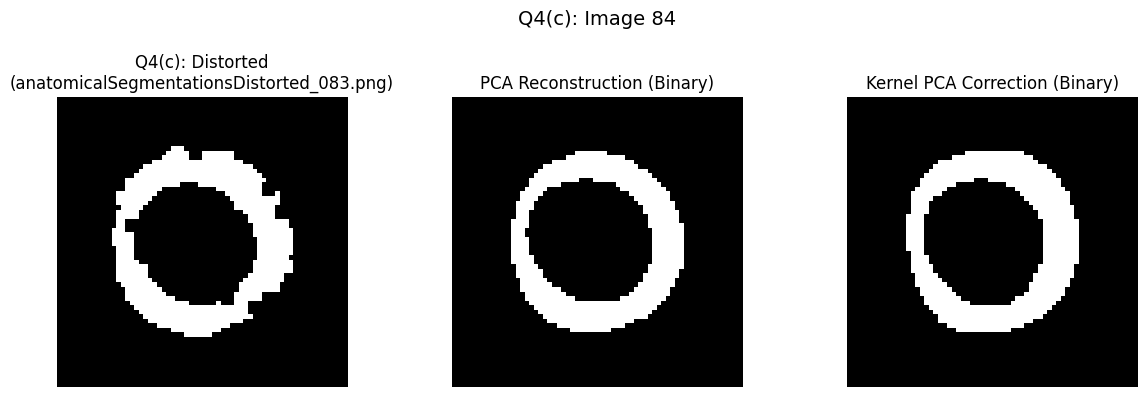

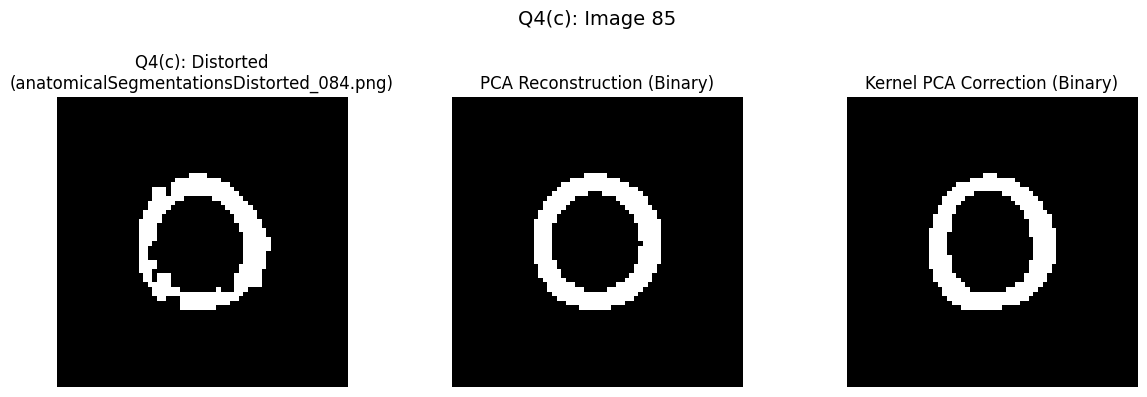

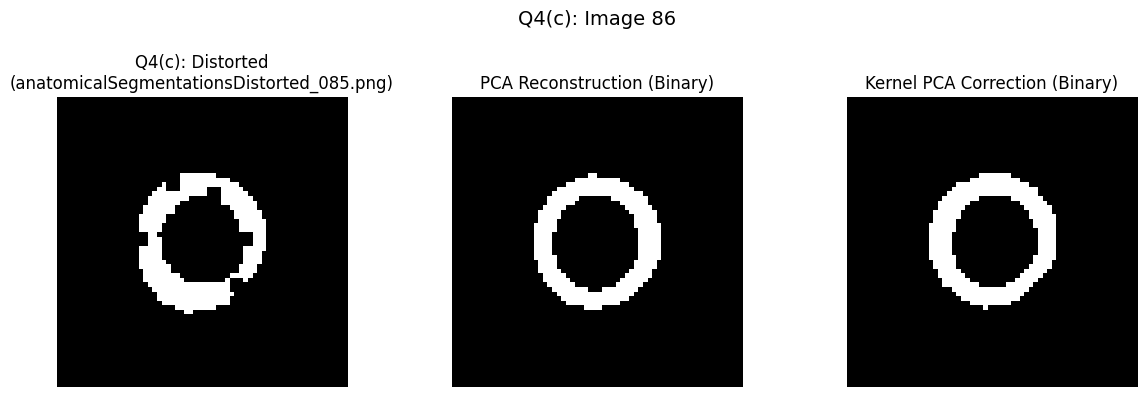

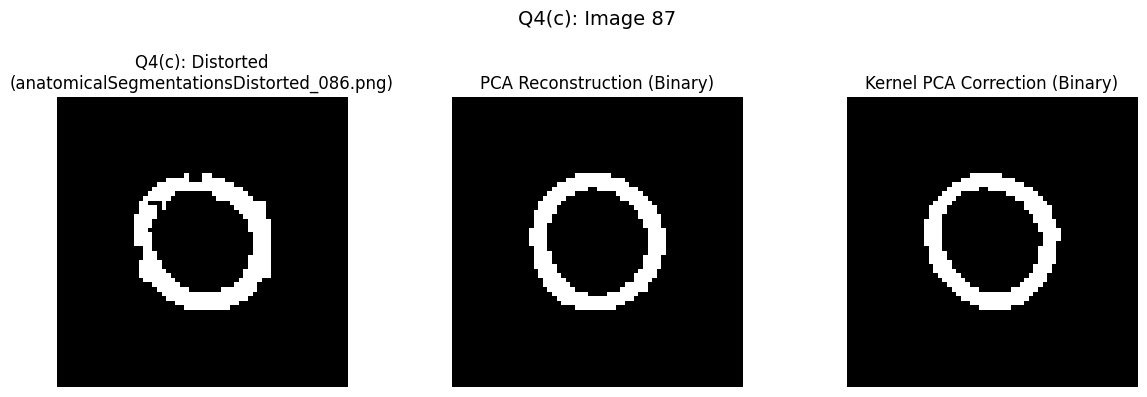

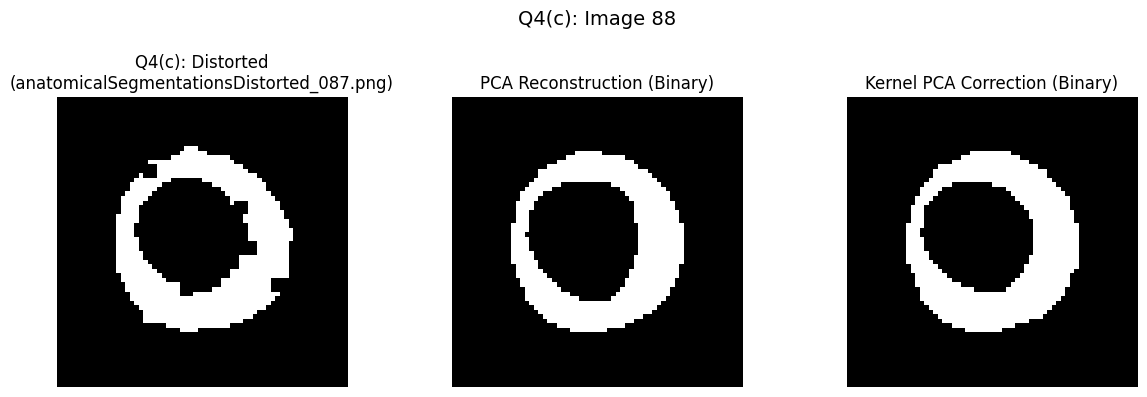

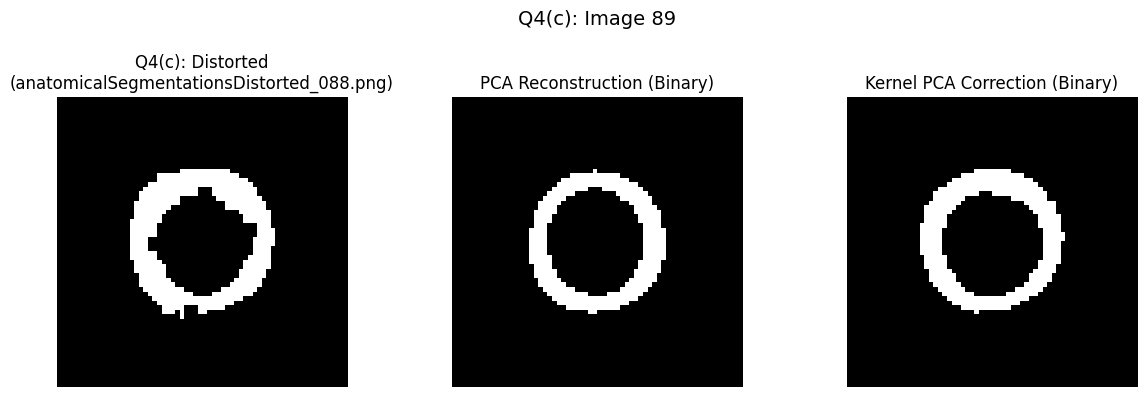

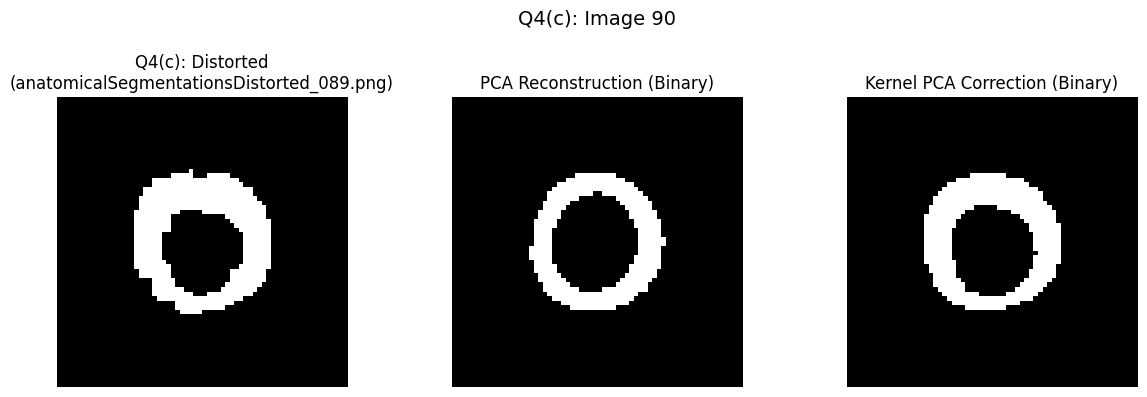

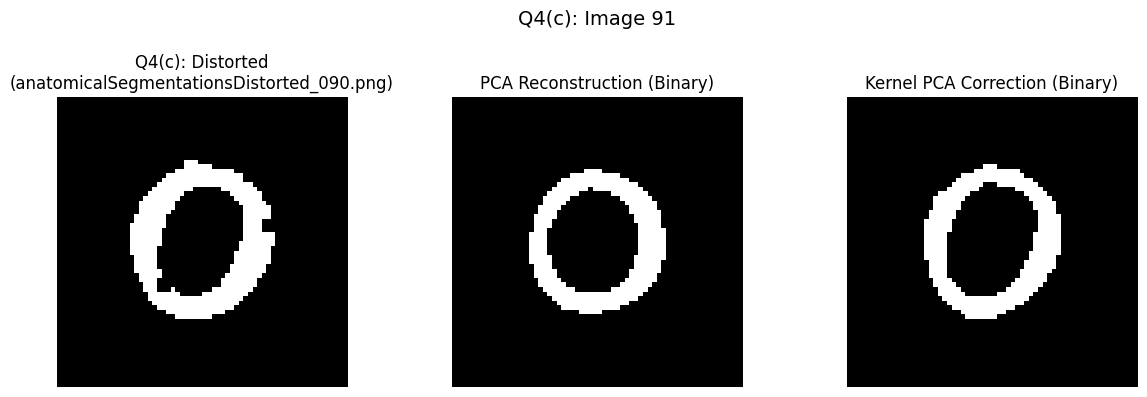

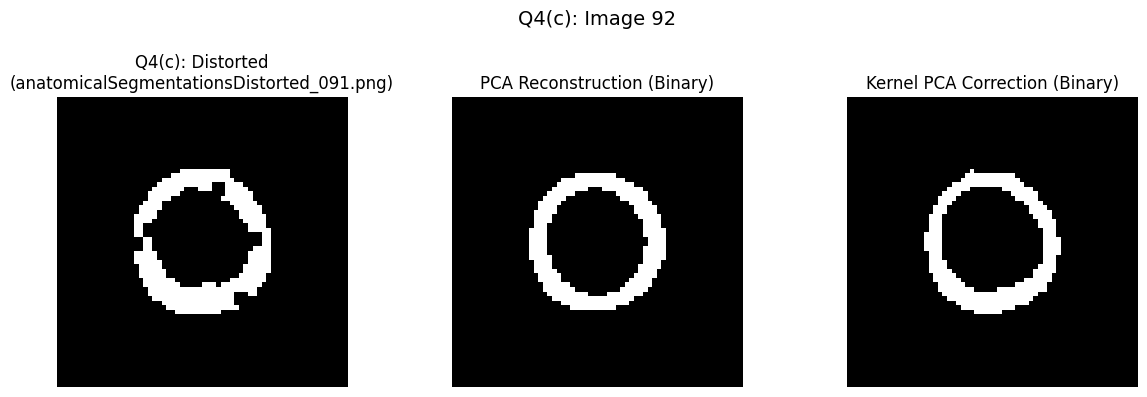

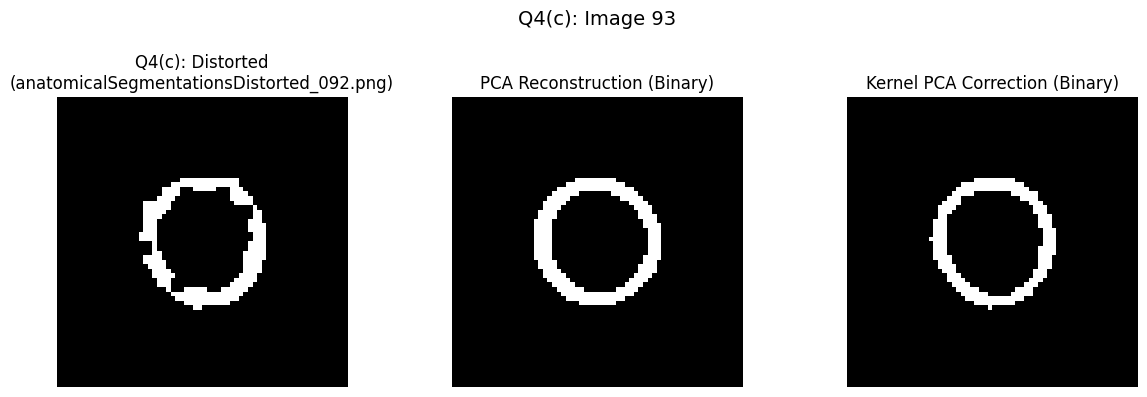

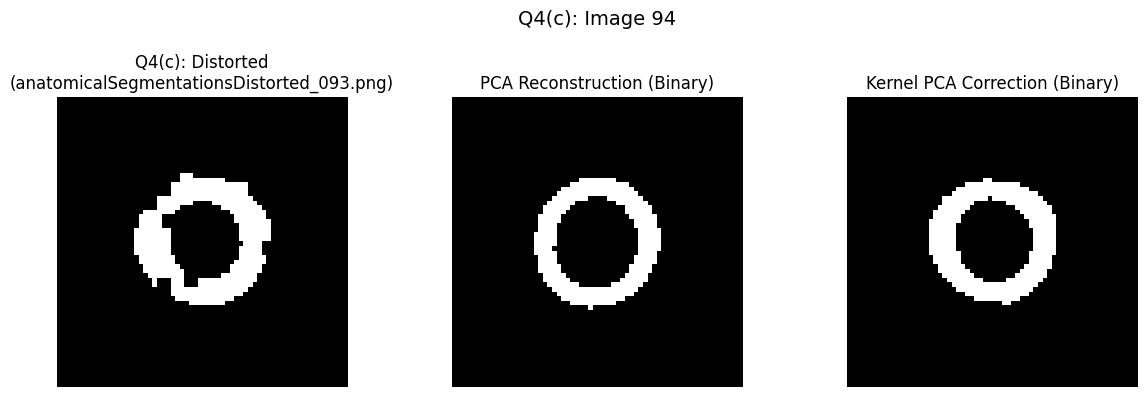

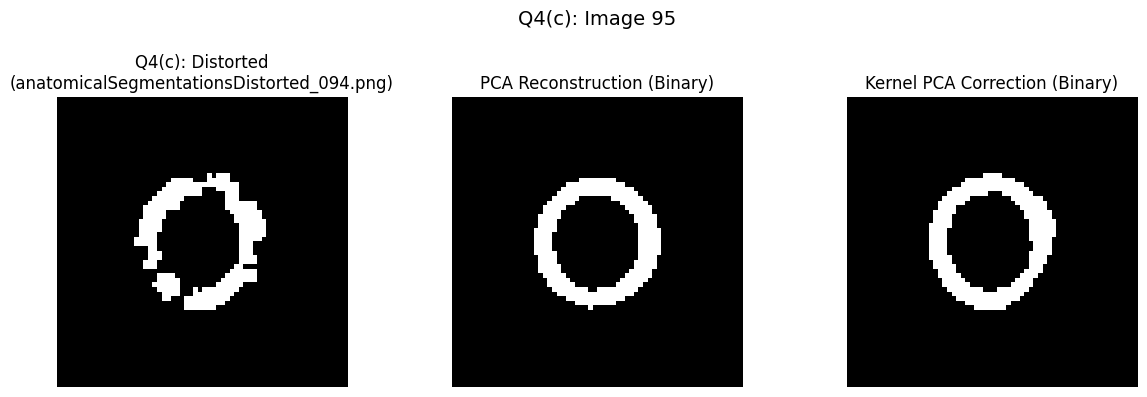

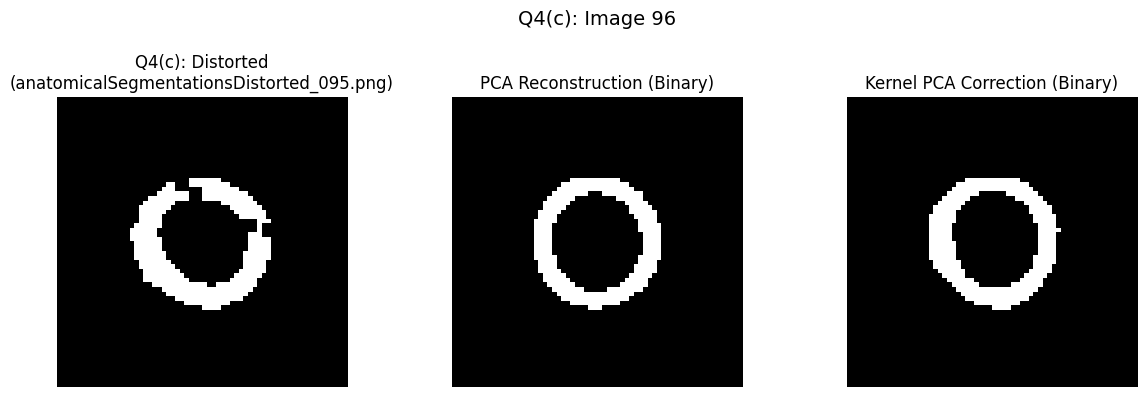

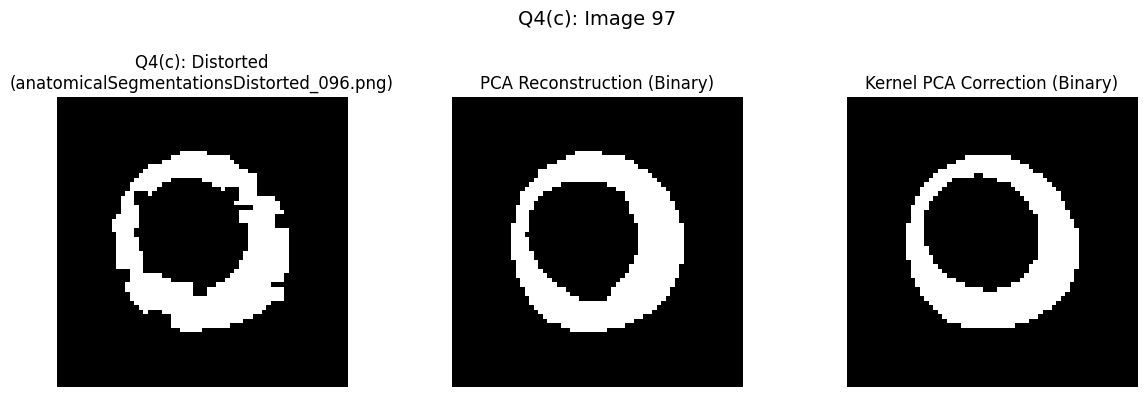

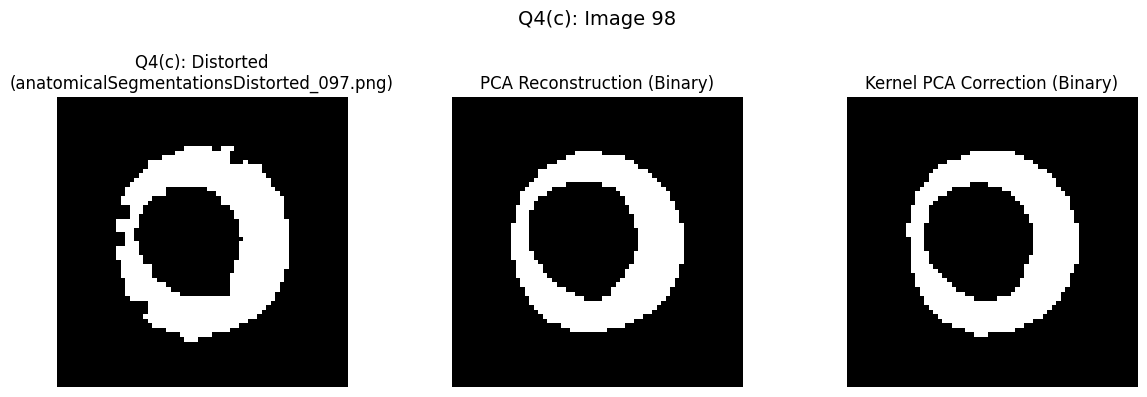

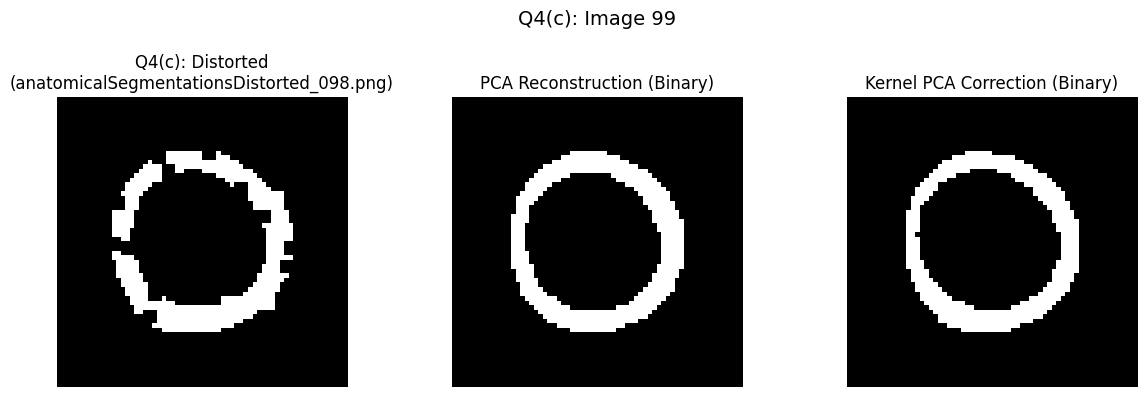

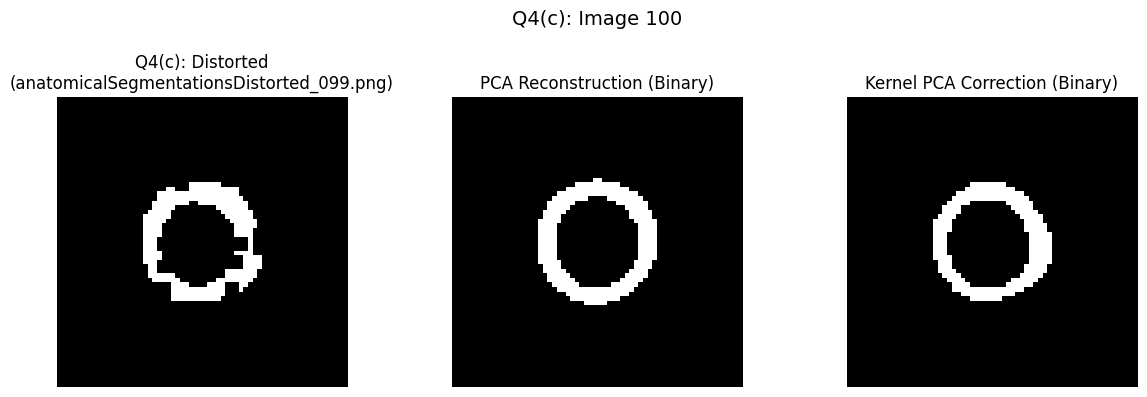

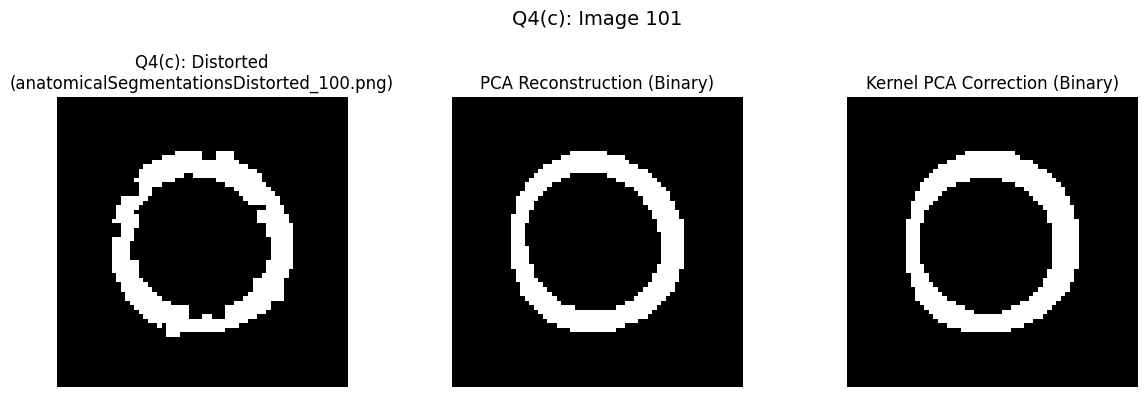

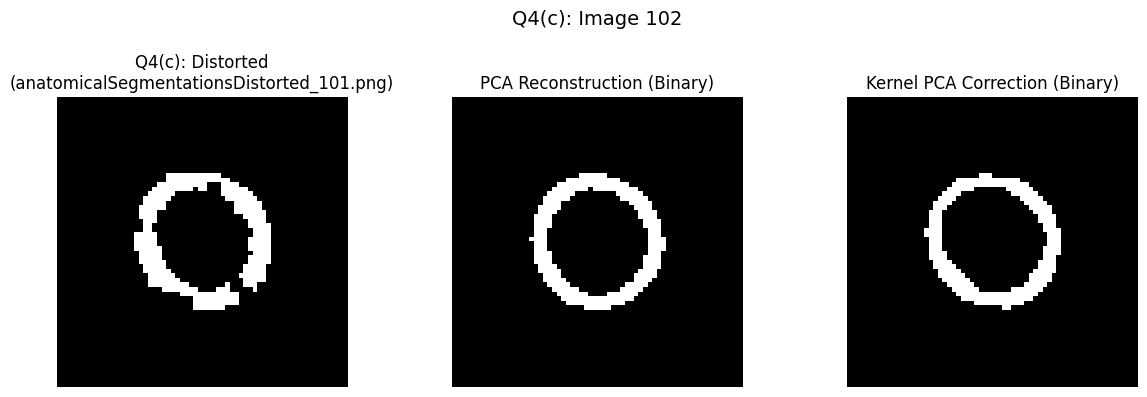

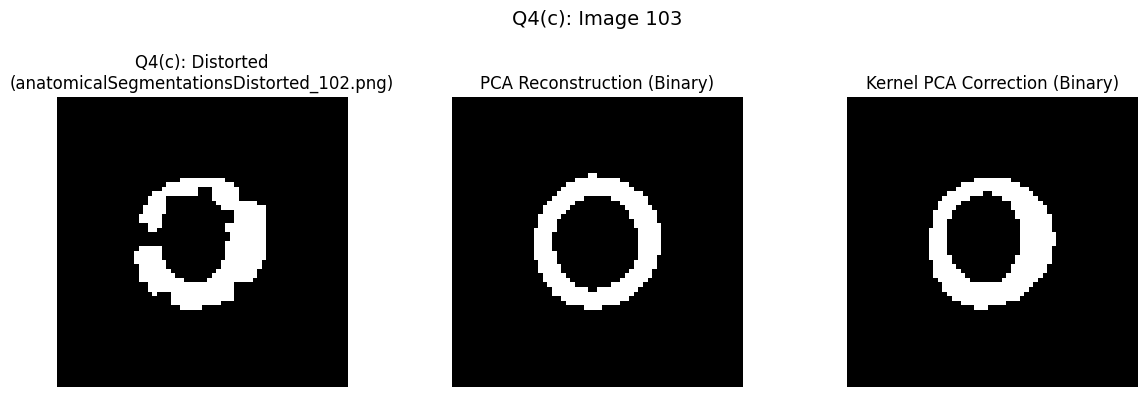

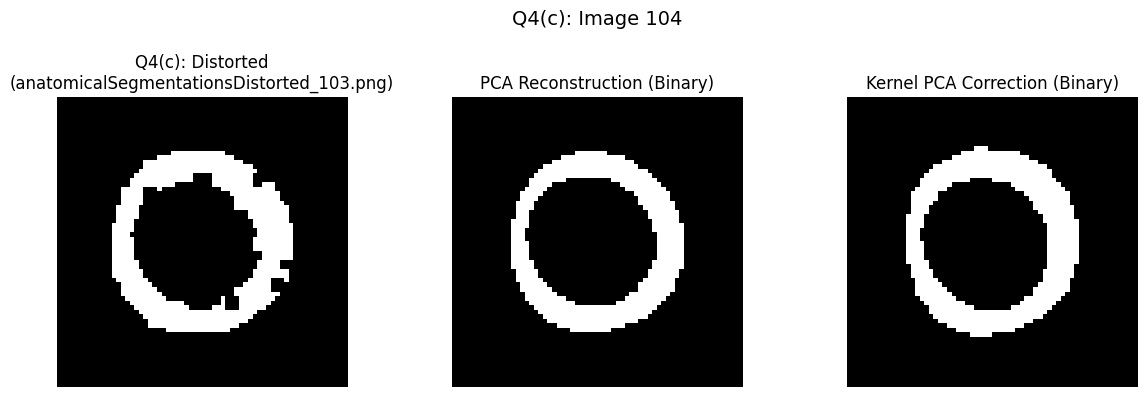

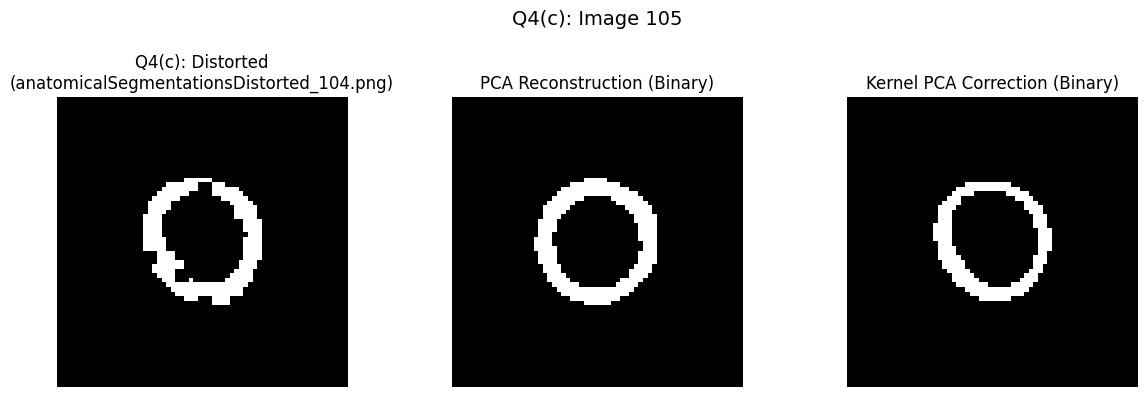

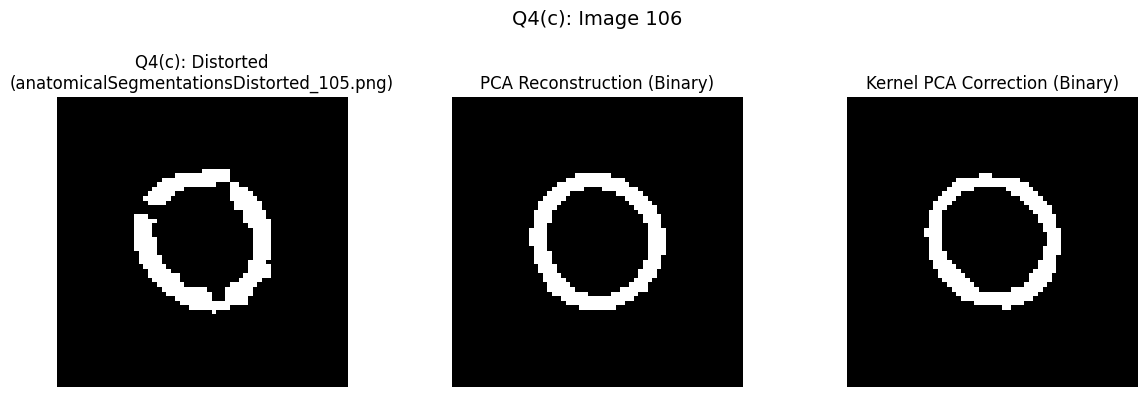

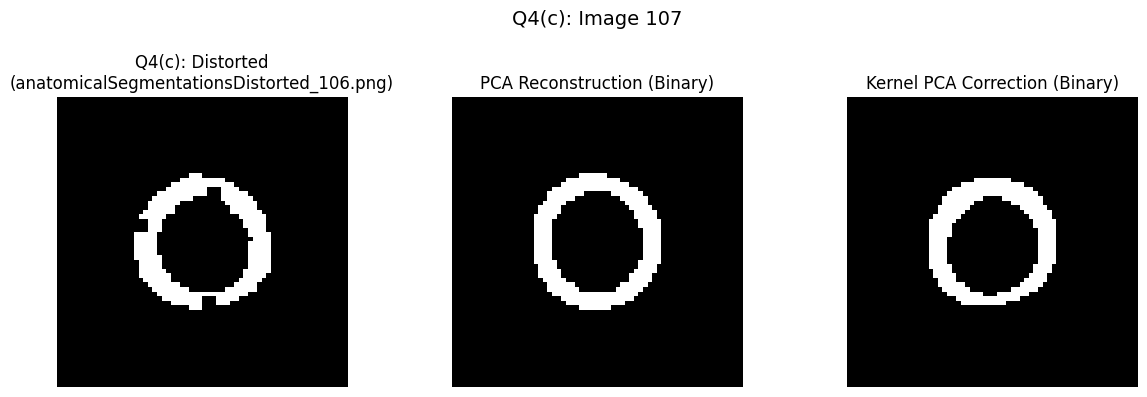

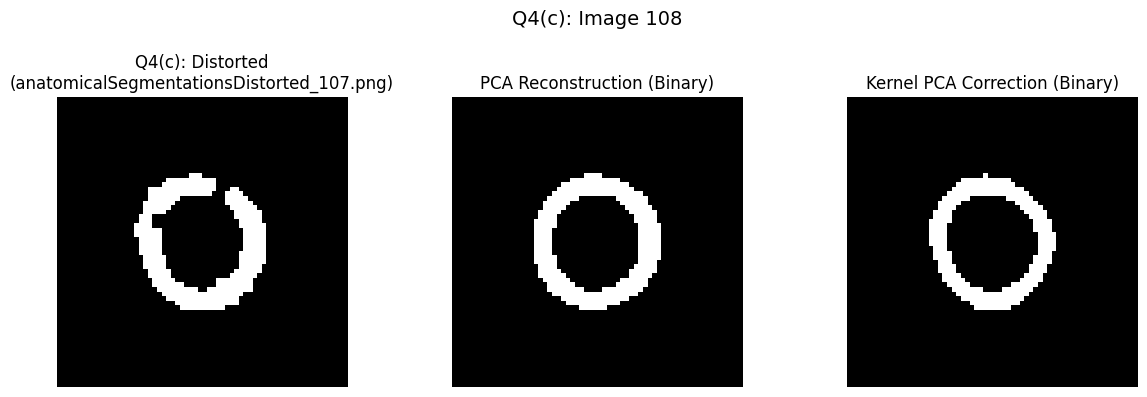

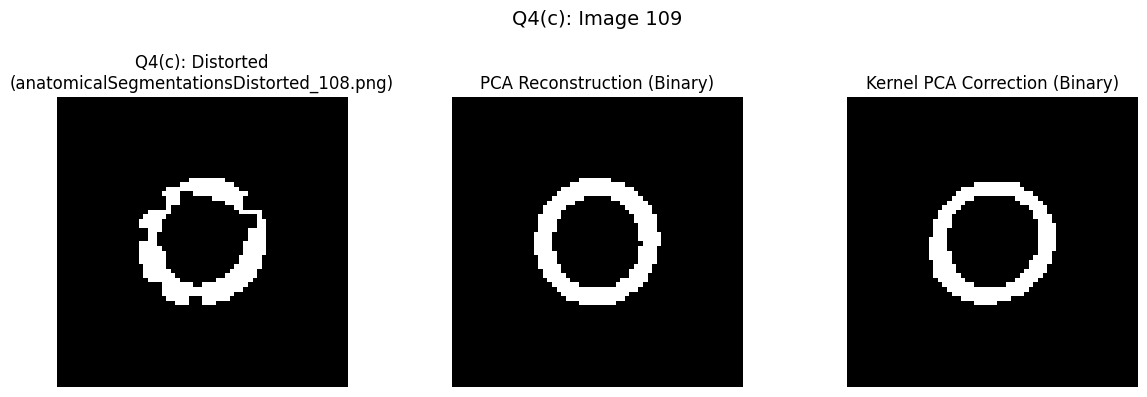

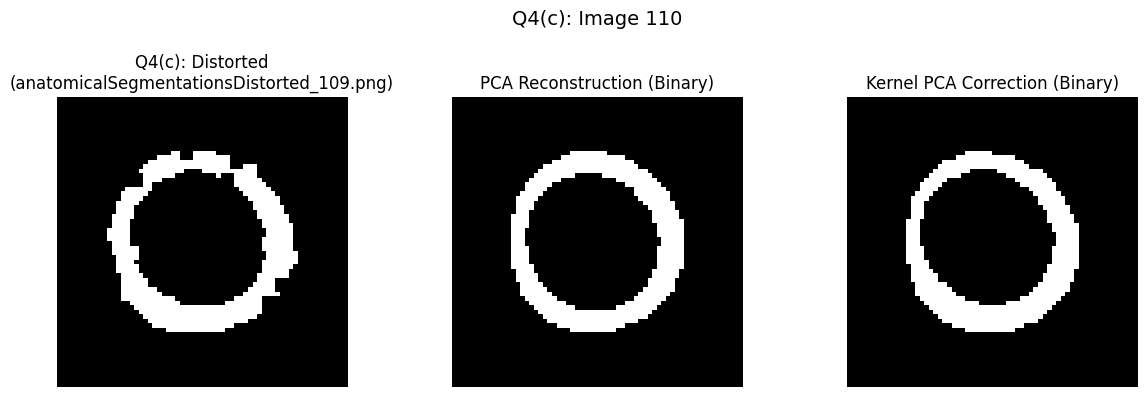

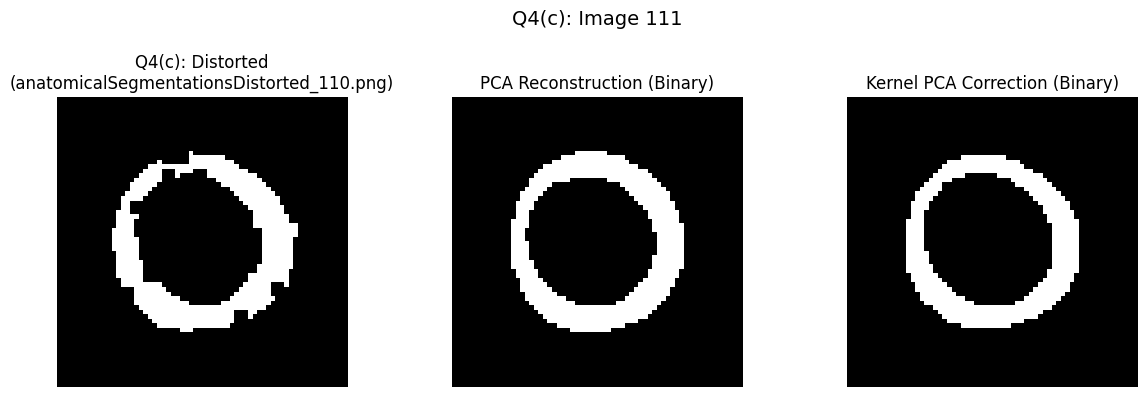

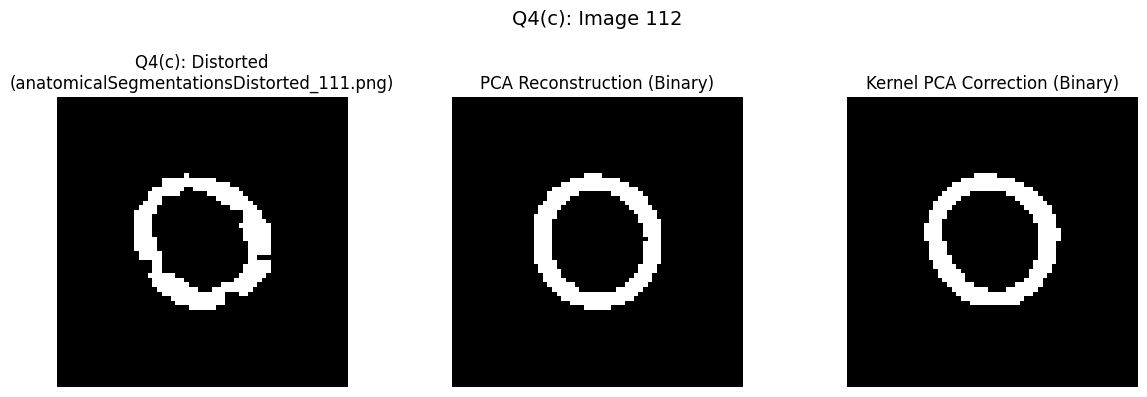

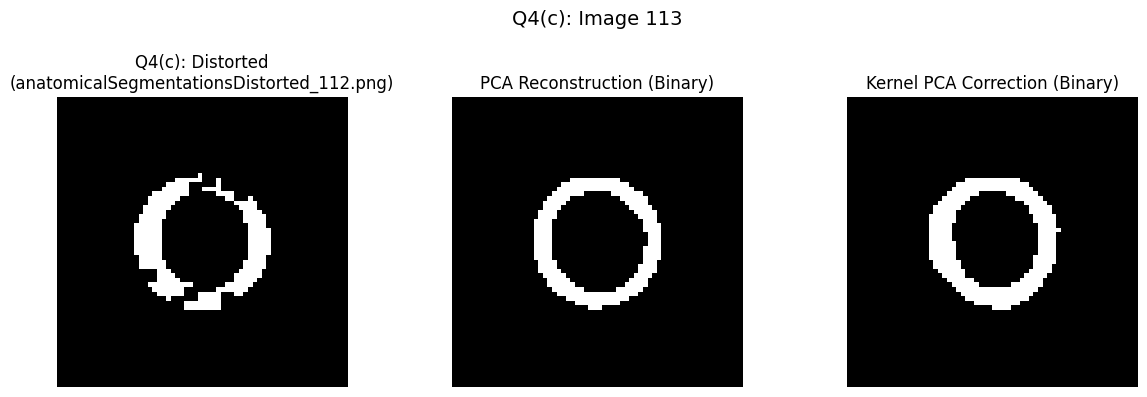

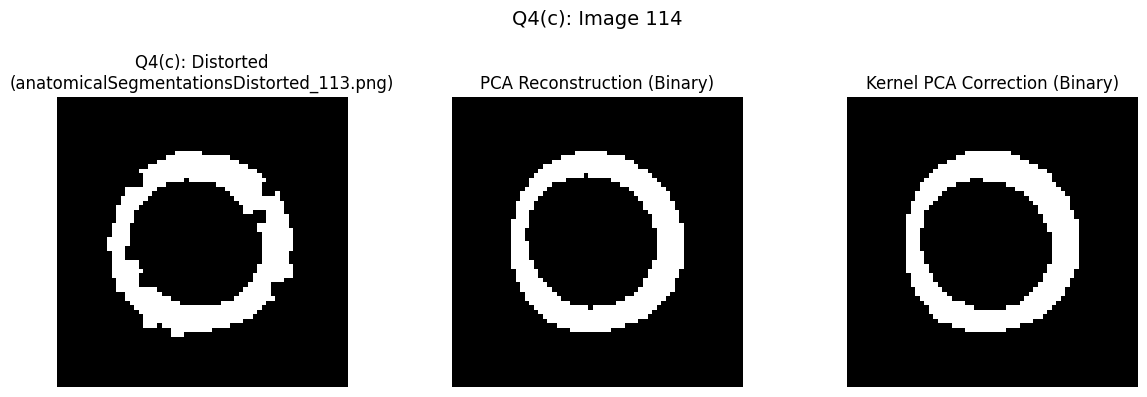

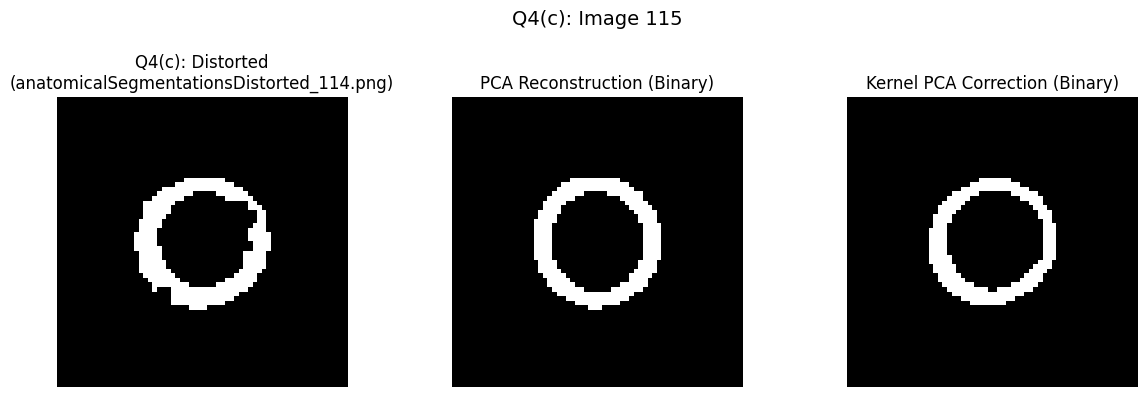

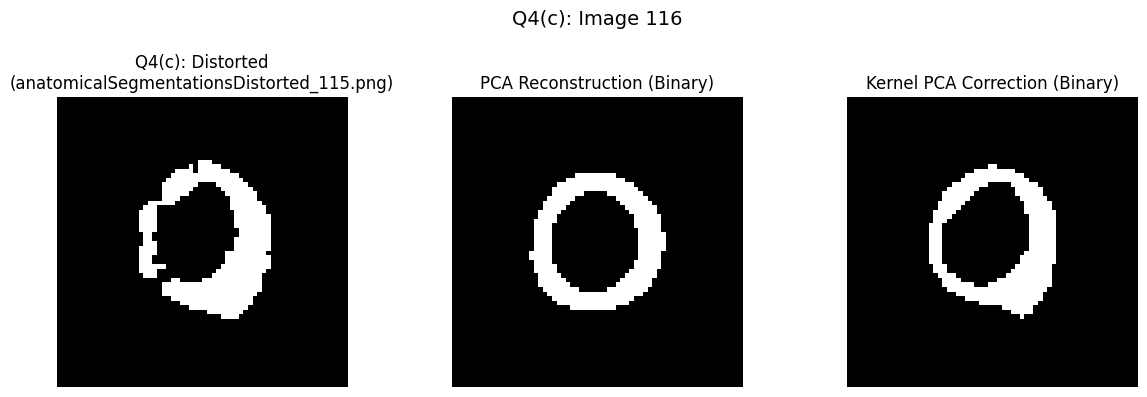

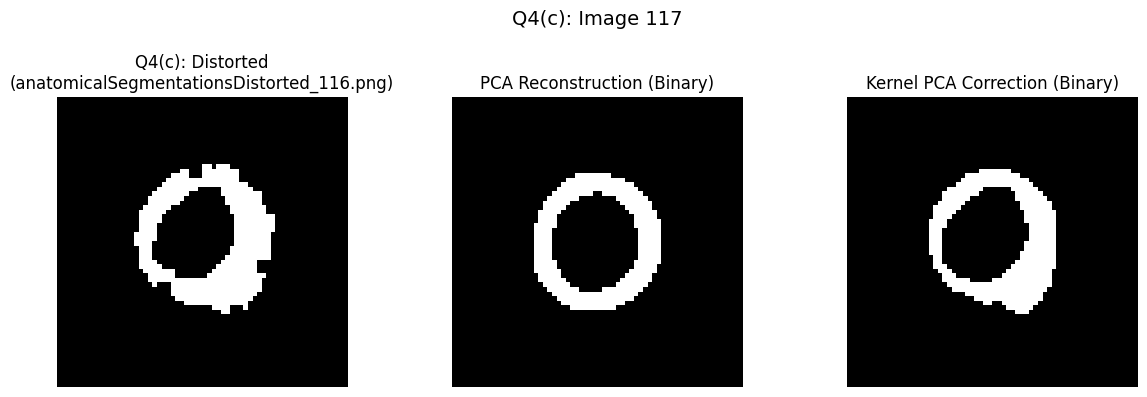

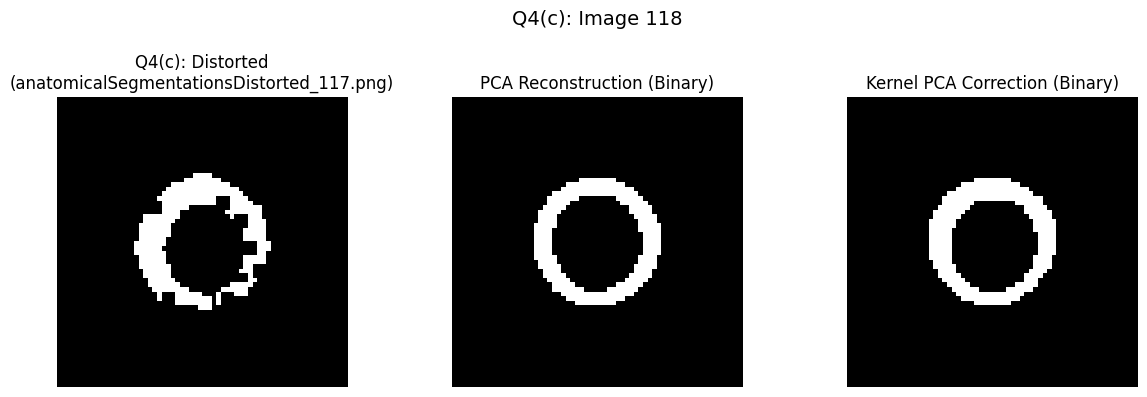

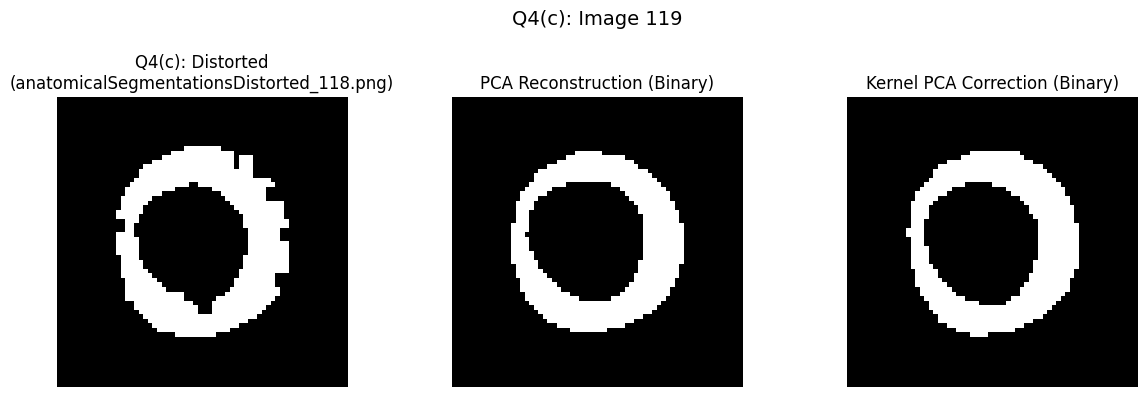

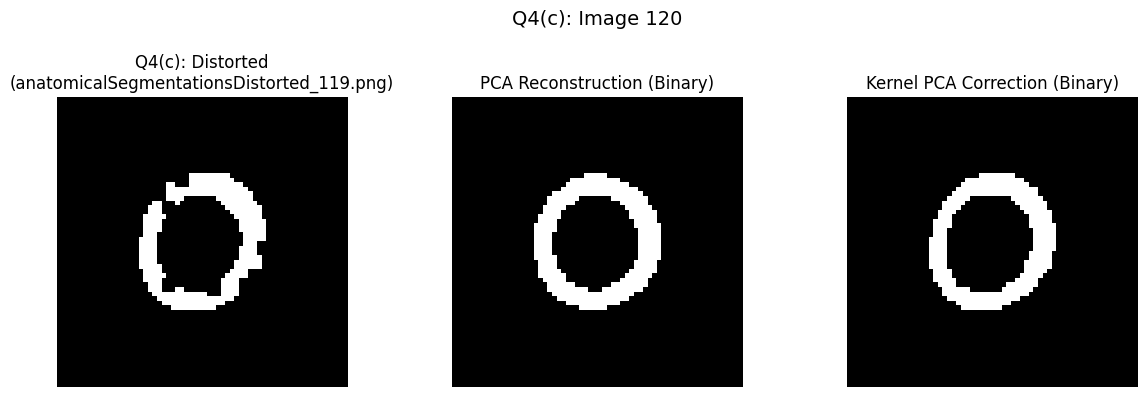

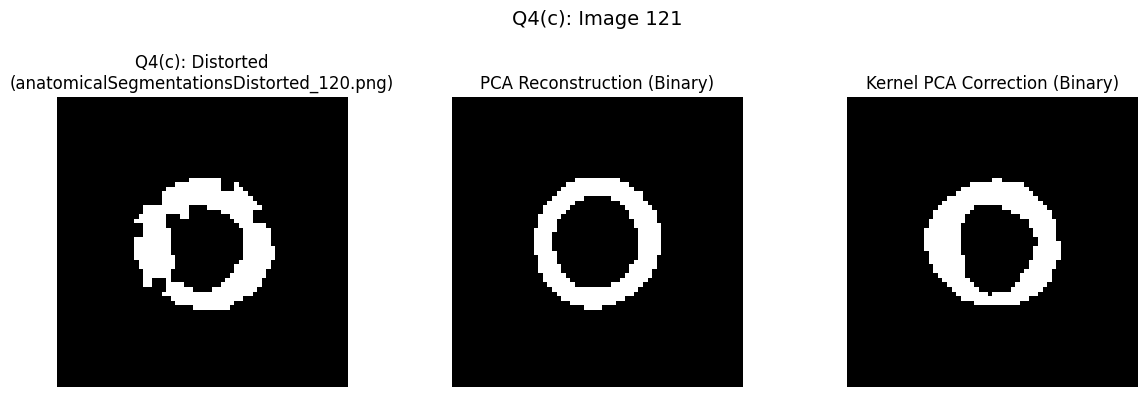

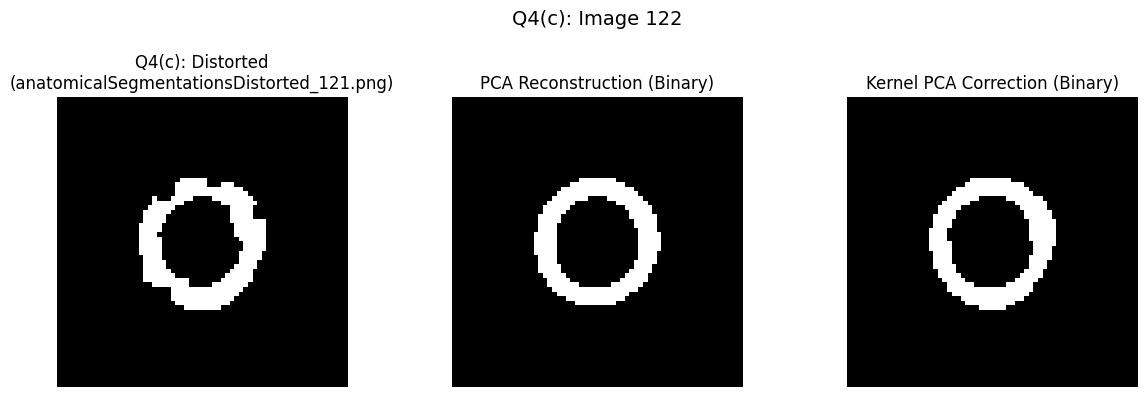

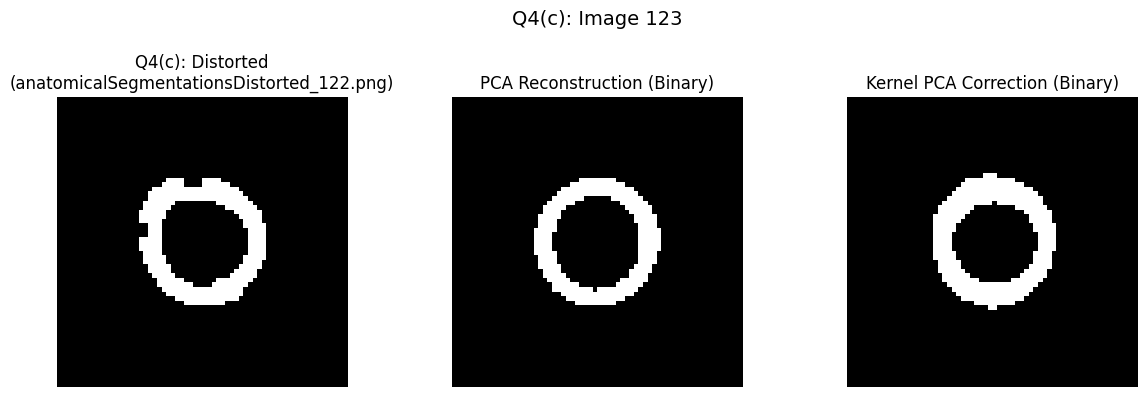

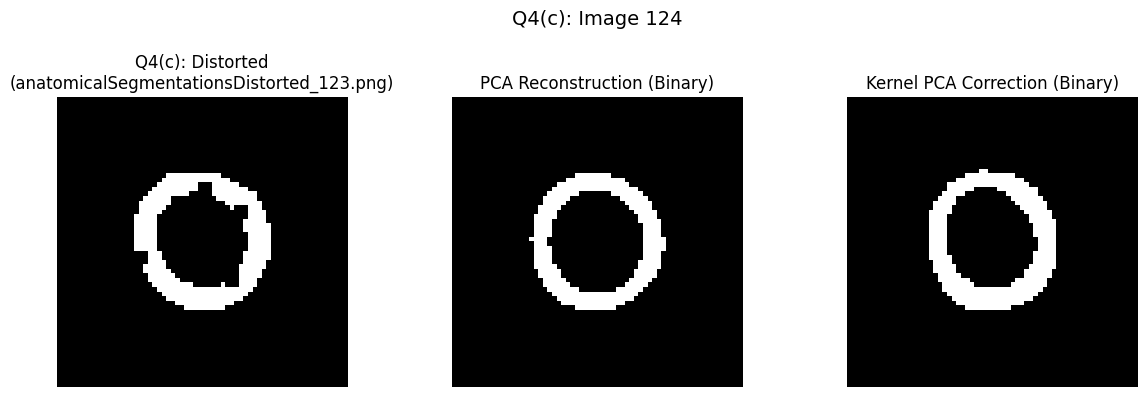

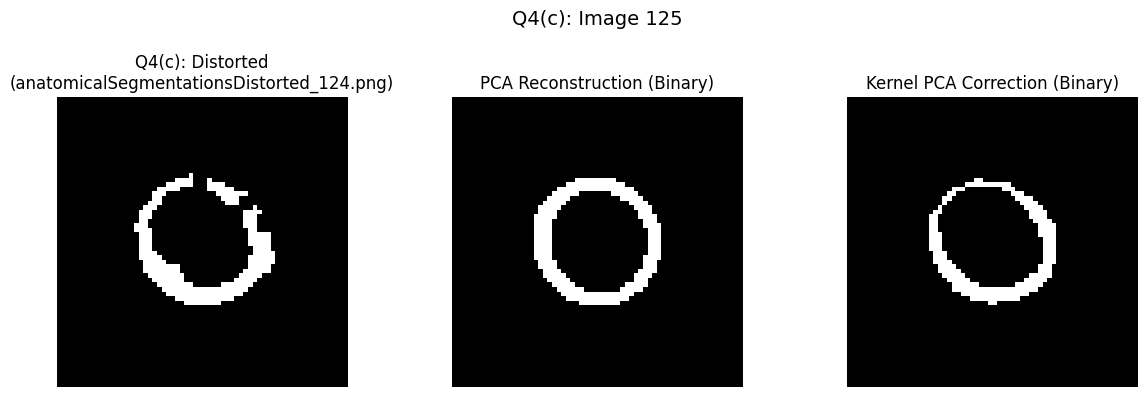

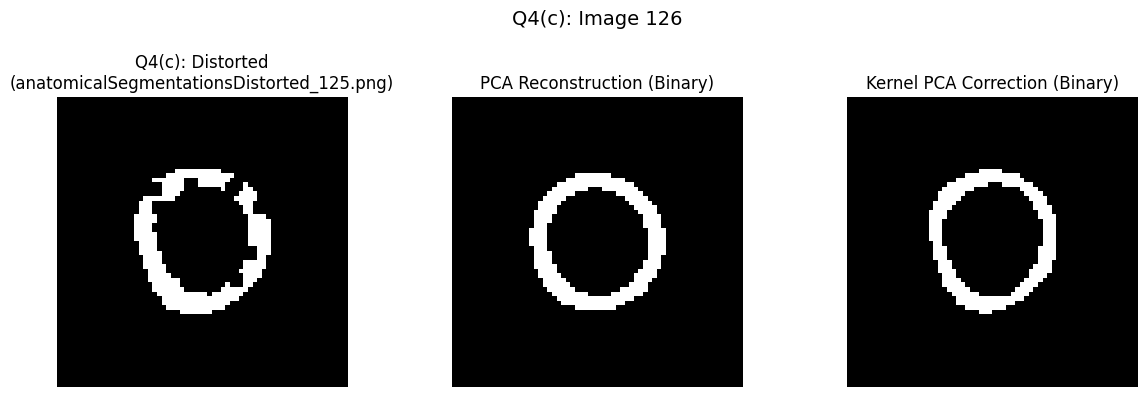

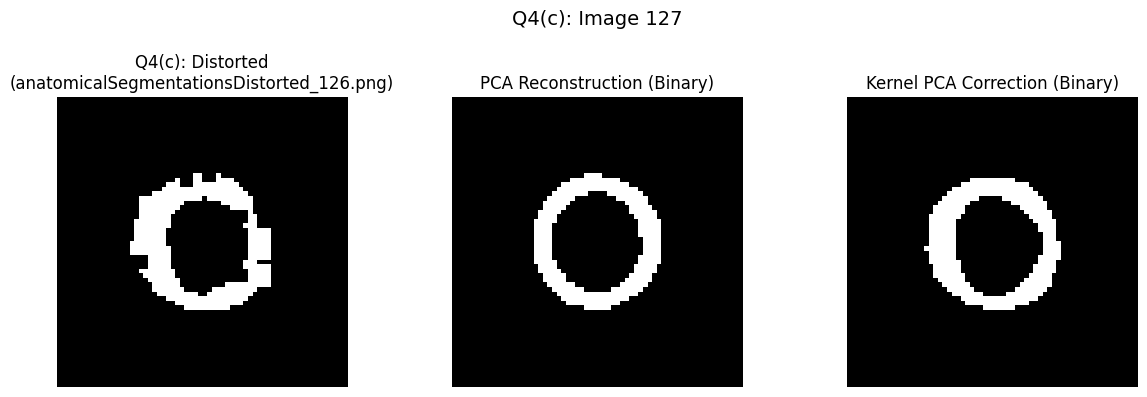

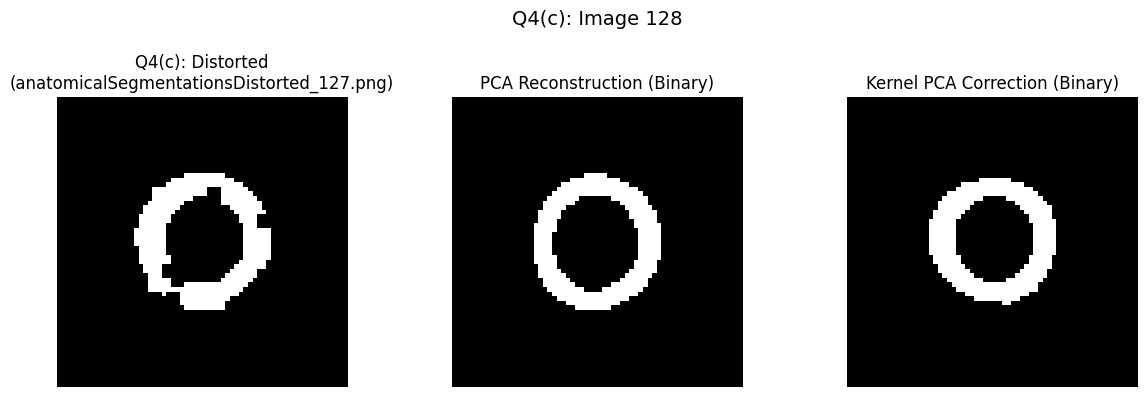

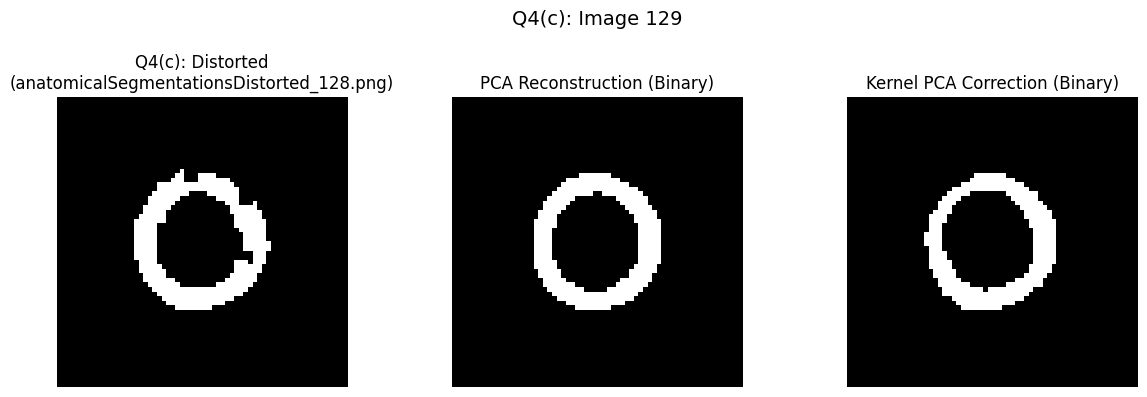

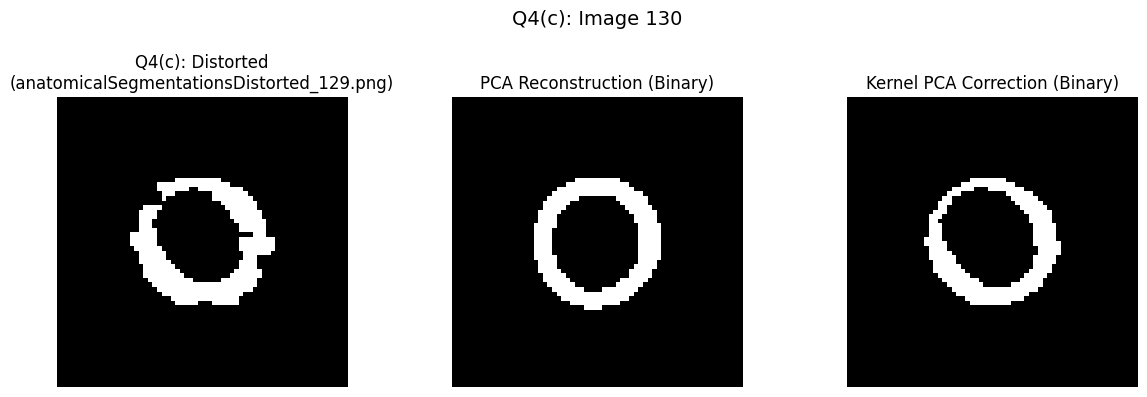

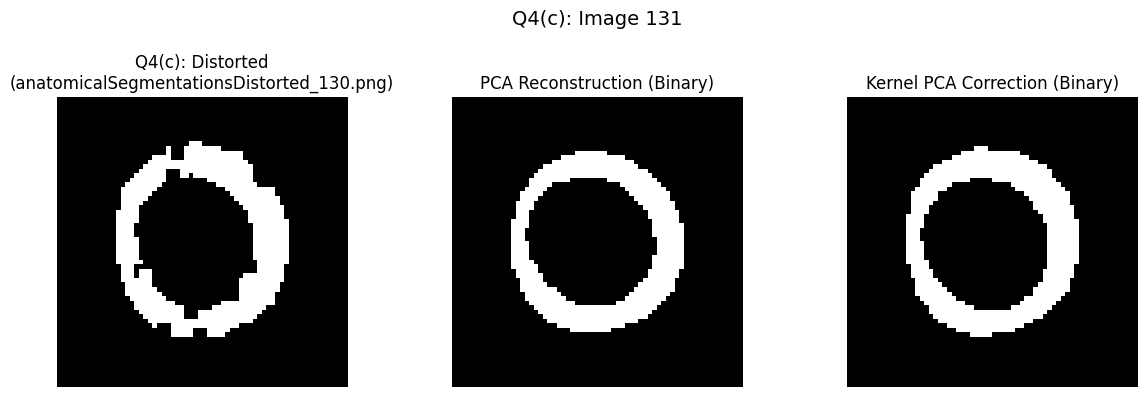

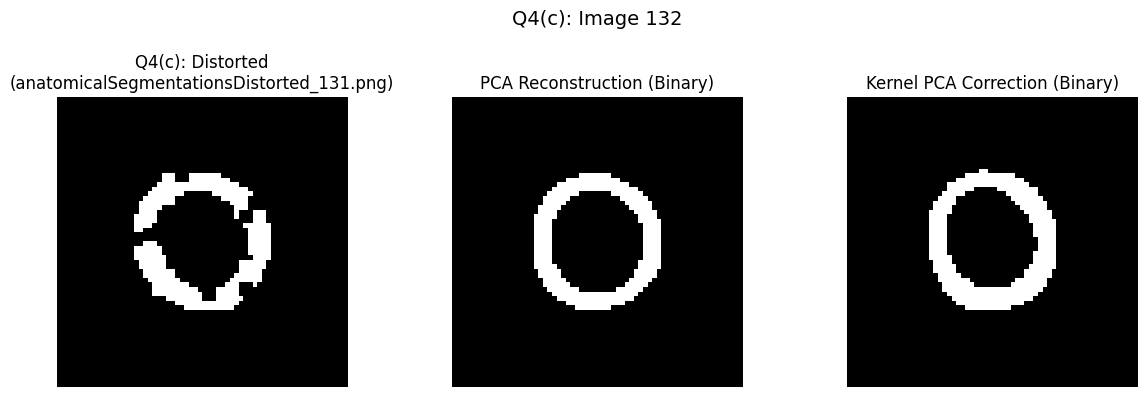

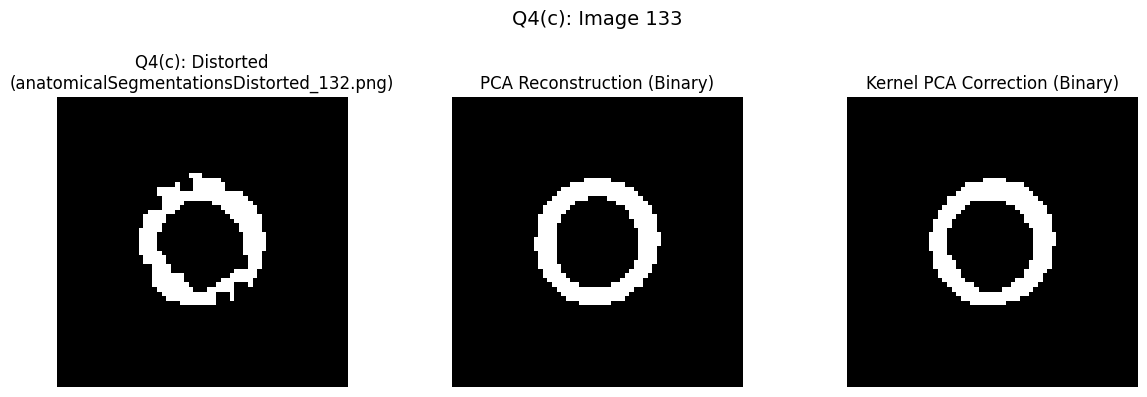

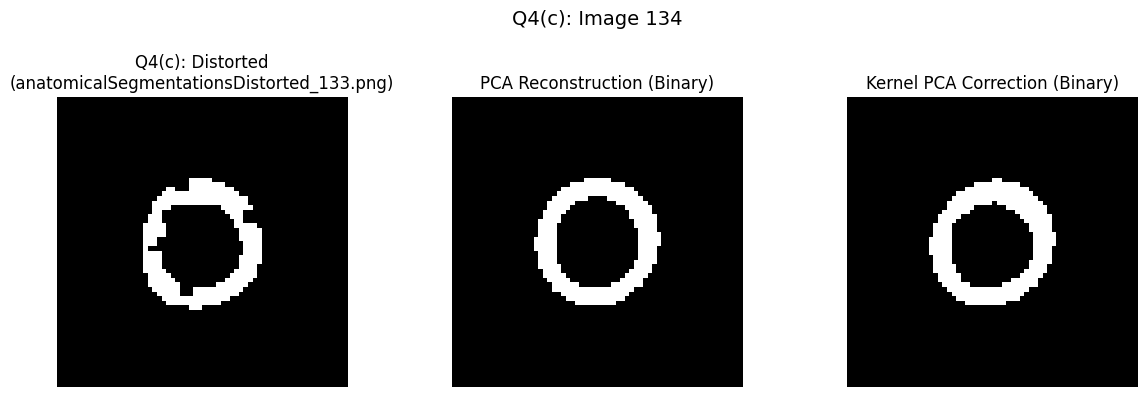

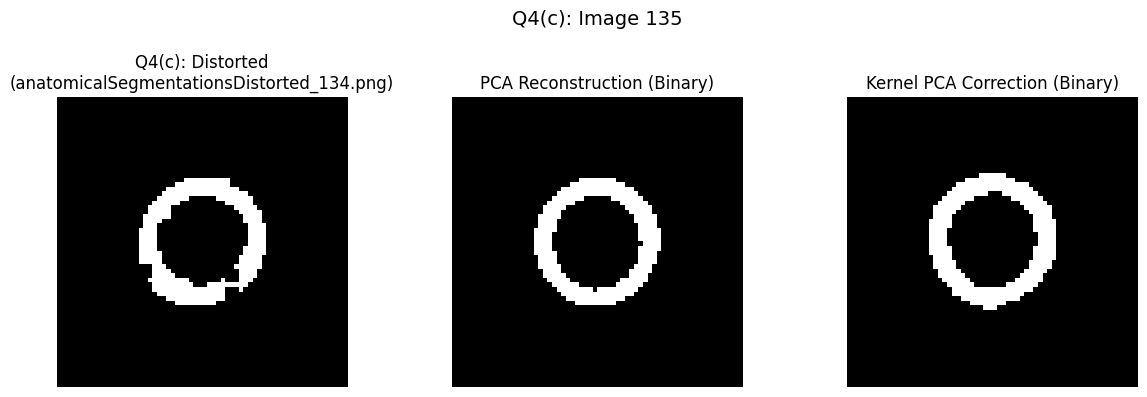

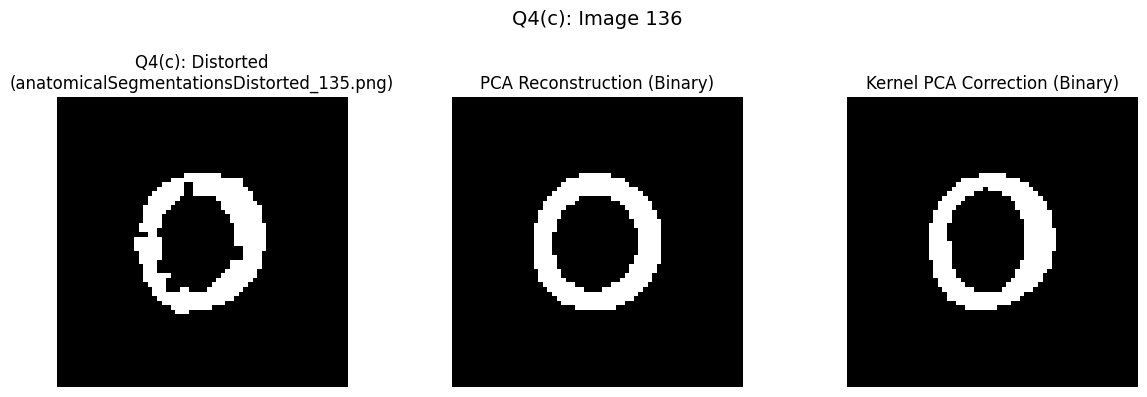

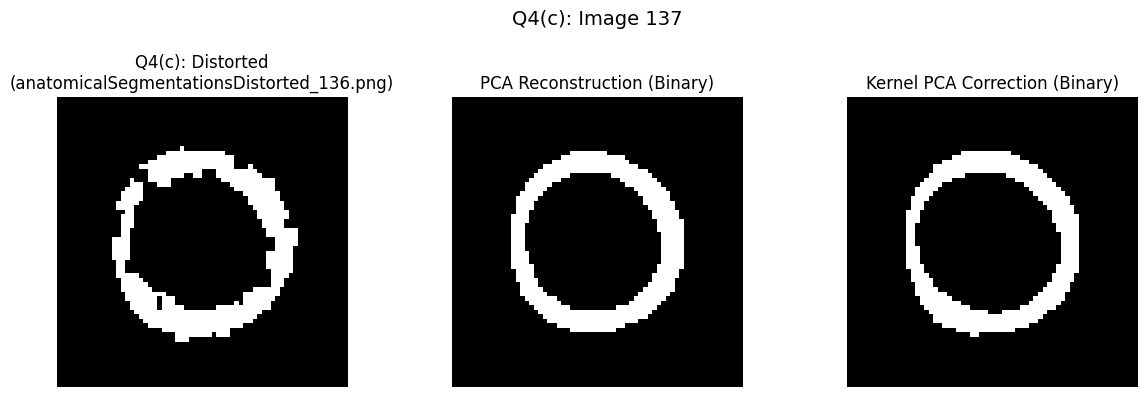

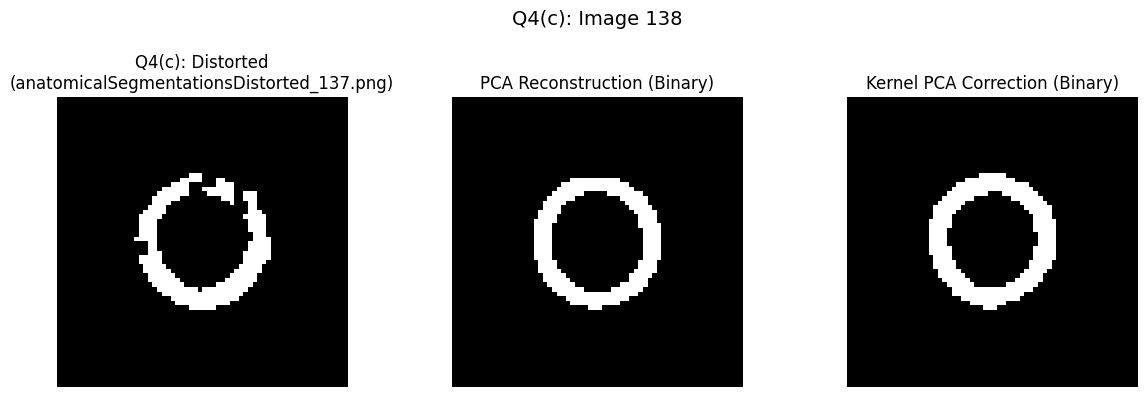

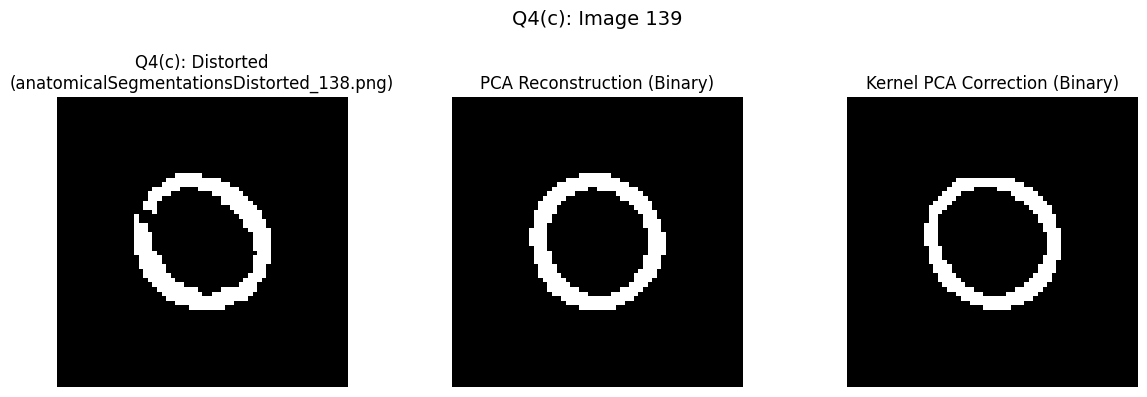

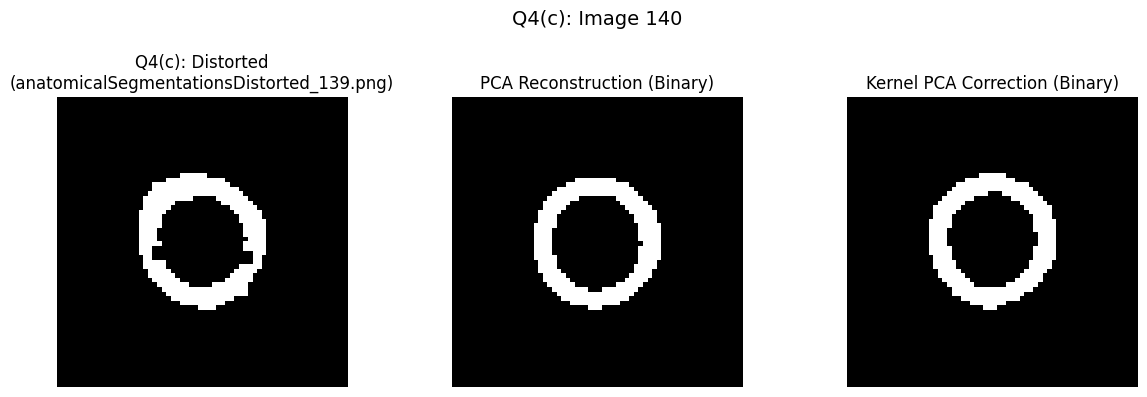

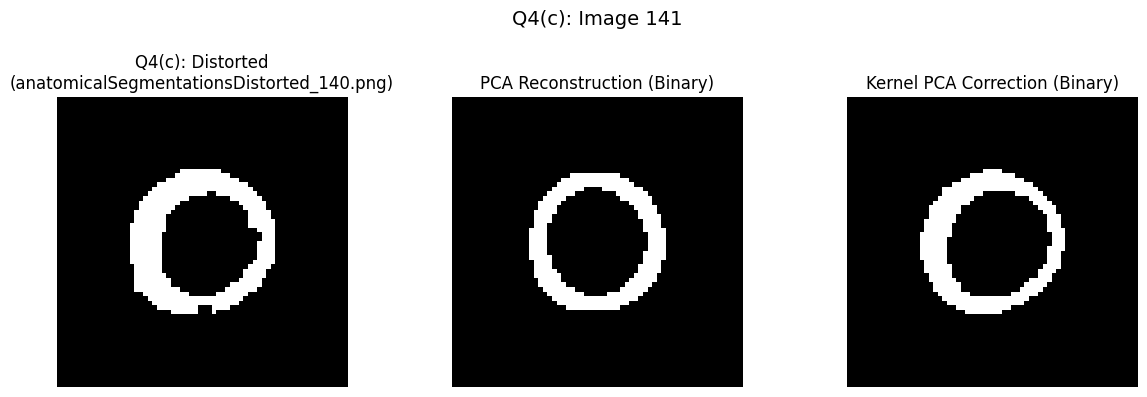

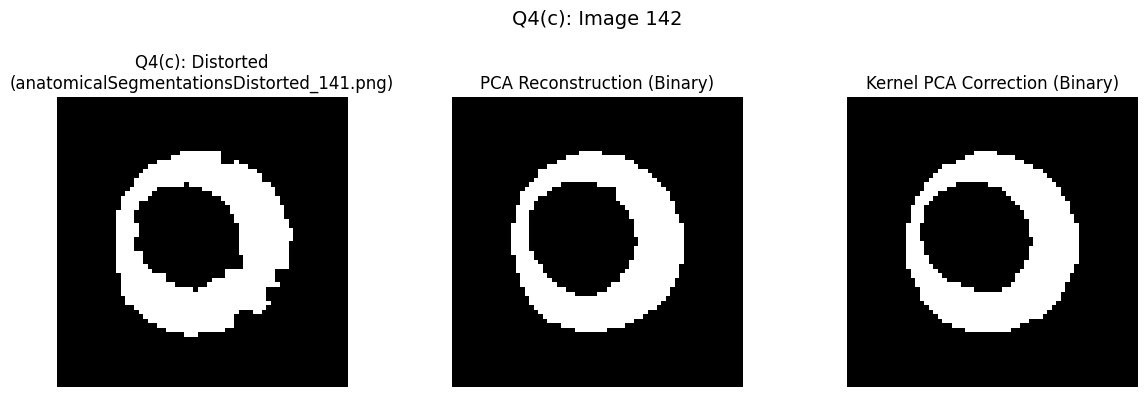

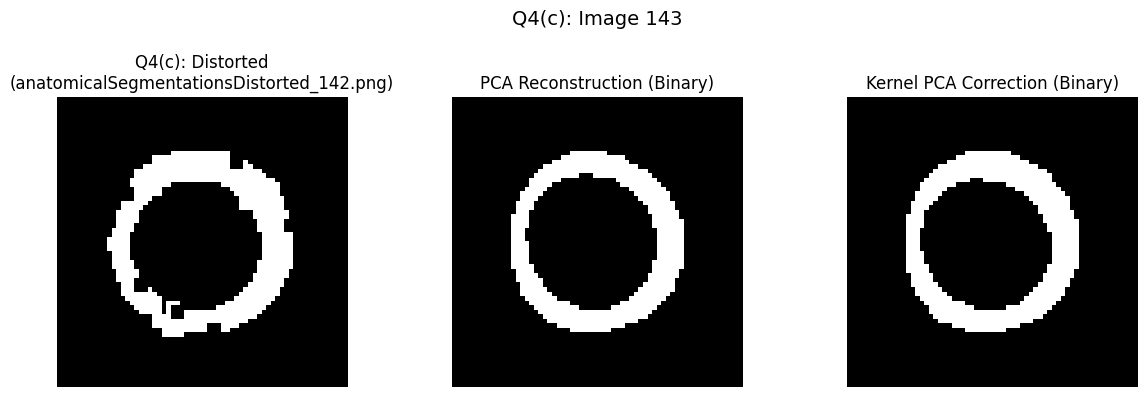

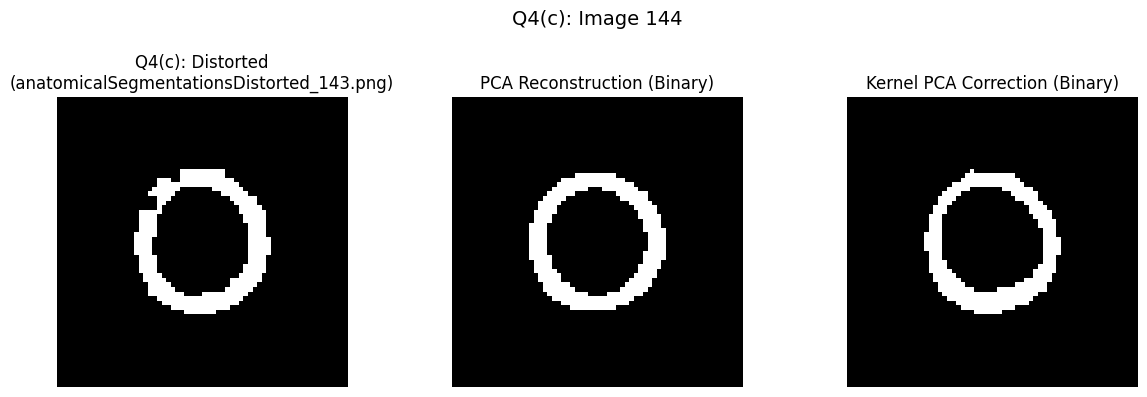

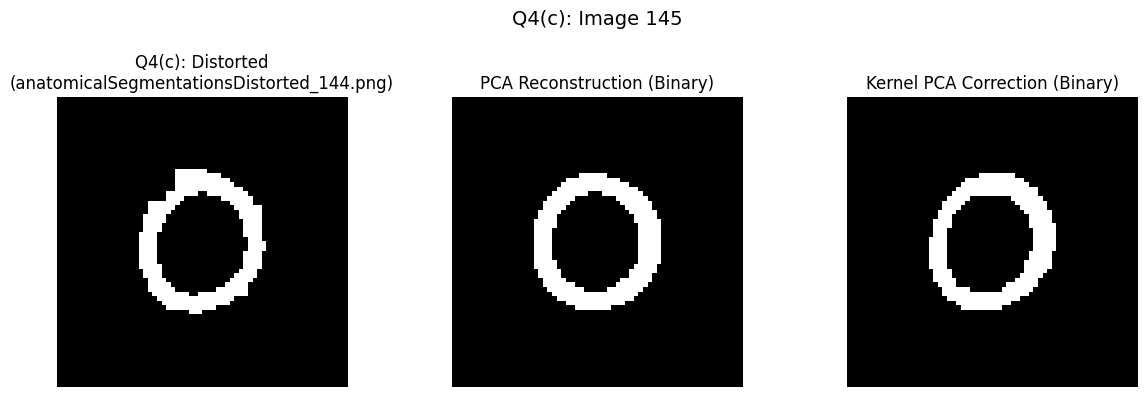

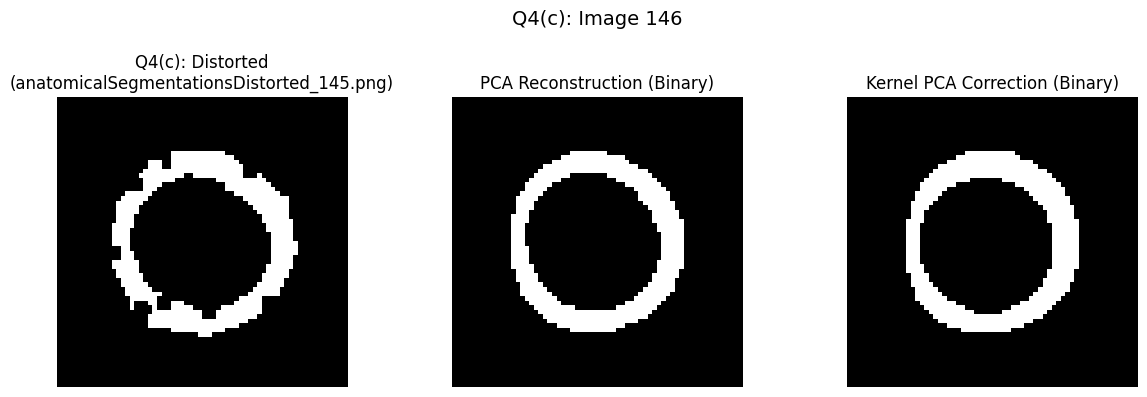

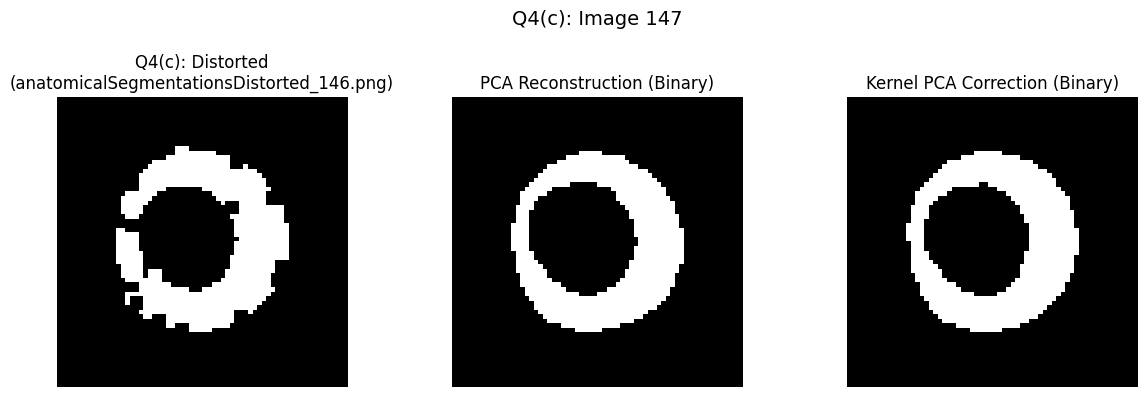

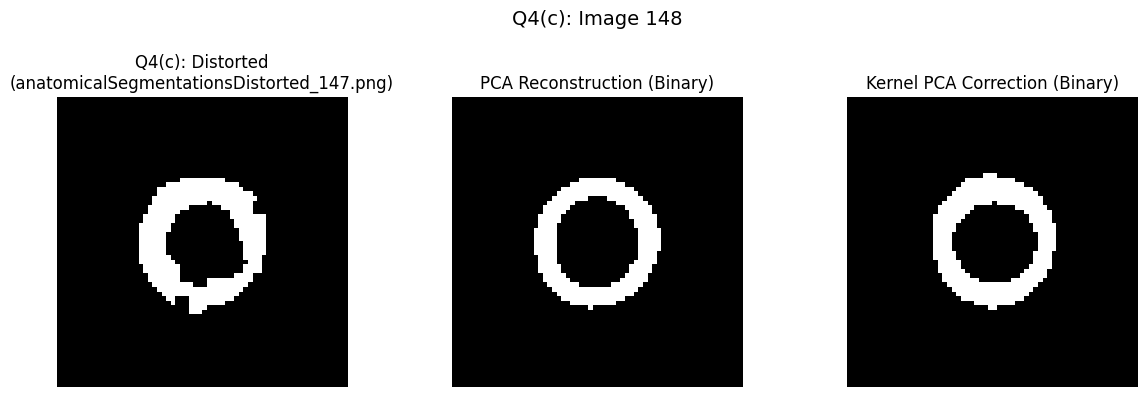

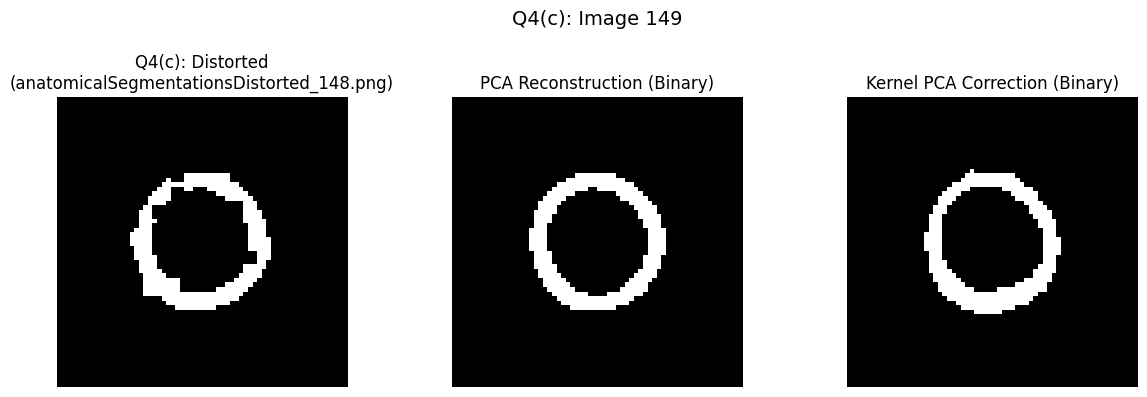

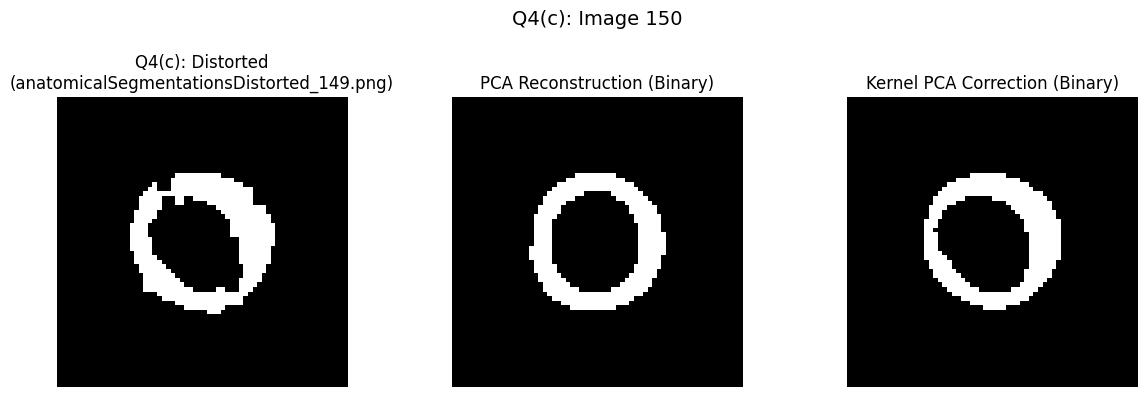

In [168]:
print("Q4(c): Correcting Distorted Segmentation Images")

dist_folder = 'data\\anatomicalSegmentationsDistorted'
dist_images, X_dist, dist_filenames = load_images_from_folder(dist_folder, size=img_size)
print("Loaded {} distorted segmentation images.".format(len(dist_images)))

# For each distorted image, compute:
# (i) PCA reconstruction (projection onto first 3 PCA modes, binary output)
# (ii) Kernel PCA correction (pre-image reconstruction in RKHS, binary output)
reconstructed_pca = []
reconstructed_kernel = []
for i in range(len(X_dist)):
    x = X_dist[i]
    # PCA reconstruction:
    rec_pca = reconstruct_pca(x, mean_seg, eigvecs_pca, num_components)
    reconstructed_pca.append(rec_pca)
    # Kernel PCA correction:
    rec_kpca = reconstruct_kernel_pca(x, X_seg, sigma, eigvecs_kpca, eigvals_kpca, K_centered_train, num_components)
    reconstructed_kernel.append(rec_kpca)
    
# Display each distorted image, its PCA reconstruction, and its Kernel PCA correction side by side.
for i in range(len(X_dist)):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(binarize_image(np.clip(X_dist[i].reshape(img_size), 0, 1)), cmap='gray')
    axs[0].set_title(f'Q4(c): Distorted\n({dist_filenames[i]})')
    axs[0].axis('off')
    axs[1].imshow(reconstructed_pca[i].reshape(img_size), cmap='gray')
    axs[1].set_title('PCA Reconstruction (Binary)')
    axs[1].axis('off')
    axs[2].imshow(reconstructed_kernel[i].reshape(img_size), cmap='gray')
    axs[2].set_title('Kernel PCA Correction (Binary)')
    axs[2].axis('off')
    plt.suptitle(f'Q4(c): Image {i+1}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.show()
    # plt.close()

In [169]:
print("Generating PDF with distorted, PCA reconstruction, and Kernel PCA correction per page...")

# Create a temporary folder for storing images to be embedded in the PDF.
temp_folder = 'temp_pdf_images'
os.makedirs(temp_folder, exist_ok=True)

Generating PDF with distorted, PCA reconstruction, and Kernel PCA correction per page...


In [170]:
# Save each distorted image and its corresponding reconstructions as temporary files.
pdf_image_paths = []  # List of tuples: (distorted_path, pca_path, kpca_path)
for i in range(len(X_dist)):
    # Save distorted image (binarized).
    distorted_img = (binarize_image(np.clip(X_dist[i].reshape(img_size), 0, 1)) * 255).astype(np.uint8)
    distorted_path = os.path.join(temp_folder, f"distorted_{i}.png")
    cv2.imwrite(distorted_path, distorted_img)
    # Save PCA reconstruction.
    pca_img = (reconstructed_pca[i].reshape(img_size) * 255).astype(np.uint8)
    pca_path = os.path.join(temp_folder, f"pca_{i}.png")
    cv2.imwrite(pca_path, pca_img)
    # Save Kernel PCA correction.
    kpca_img = (reconstructed_kernel[i].reshape(img_size) * 255).astype(np.uint8)
    kpca_path = os.path.join(temp_folder, f"kpca_{i}.png")
    cv2.imwrite(kpca_path, kpca_img)
    pdf_image_paths.append((distorted_path, pca_path, kpca_path))

In [171]:
# Generate PDF: One page per test image.
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
for i, (dist_path, pca_path, kpca_path) in enumerate(pdf_image_paths):
    pdf.add_page()
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(0, 10, f"Test Image: {dist_filenames[i]}", ln=True, align="C")
    # Insert images on the same page: left: distorted, center: PCA, right: Kernel PCA.
    pdf.image(dist_path, x=5, y=30, w=60)
    pdf.image(pca_path, x=70, y=30, w=60)
    pdf.image(kpca_path, x=135, y=30, w=60)
pdf_output = "final_results.pdf"
pdf.output(pdf_output)
print("Final PDF generated:", pdf_output)

# Clean up temporary folder.
shutil.rmtree(temp_folder)

Final PDF generated: final_results.pdf
